# 06 Visualization

# Part 1

This notebook initializes the visualization environment for comparing model performance across structured, Word2Vec, and SMOTE variants.

**Objectives:**
- Load the latest evaluation summaries (Task 6 outputs).
- Combine baseline + SMOTE results.
- Prepare DataFrames for AUROC, F1, F2 comparisons.
- Configure save paths for upcoming figures.

**Inputs:**  
`results/evaluation/{date}/*_summary.csv`  

**Outputs:**  
Preview tables + initialized plotting workspace (`results/figures/comparisons/`)


## 0 Imports

In [45]:
import os
import glob
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
from datetime import datetime

from IPython.display import Image, display;

from src.utils import resolve_path, load_latest_artifact
from src.evaluation import (
    unwrap_best_estimators_non_smote,
    unwrap_best_estimators_smote,
    plot_roc_across_datasets,
    plot_pr,
    plot_roc_curves,
    plot_shap_summary,
    plot_shap_dependence,
)

# Global settings
sns.set_style("whitegrid")
sns.set_context("talk")
plt.rcParams["figure.dpi"] = 120
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", message="The NumPy global RNG was seeded")

## 1 Locate Latest Evaluation Results

Automatically detect the most recent dated folder under  
`results/evaluation/` (e.g., `20251014/`), which contains the exported model summaries from Task 6.


In [2]:
eval_root = resolve_path("results/evaluation/")
date_folders = sorted([f for f in eval_root.iterdir() if f.is_dir()])
latest_date = date_folders[-1].name if date_folders else "unknown"
print(f"📂 Using evaluation date folder → {latest_date}")

eval_dir = eval_root / latest_date

📂 Using evaluation date folder → 20251027


## 2 Define Summary Paths

Load both baseline and SMOTE evaluation summaries for structured and Word2Vec variants.  
If any files are missing, a warning will appear.

In [5]:
summary_paths = {
    "original_baseline": eval_dir / "original_baseline_summary.csv",
    "original_baseline_smote": eval_dir / "original_baseline_smote_summary.csv",
    "w2v_radiology_baseline": eval_dir / "w2v_radiology_baseline_summary.csv",
    "w2v_radiology_baseline_smote": eval_dir / "w2v_radiology_baseline_smote_summary.csv",
}

## 3 Load Summaries

Each summary CSV contains per-classifier metrics (AUROC, Accuracy, F1, F2, etc.).  
Load all available files into a dictionary for downstream comparisons.

In [6]:
summaries = {}
for label, path in summary_paths.items():
    if path.exists():
        summaries[label] = pd.read_csv(path)
        print(f"✅ Loaded {label}: {path.name} ({summaries[label].shape[0]} rows)")
    else:
        print(f"⚠️ Missing summary: {label}")

✅ Loaded original_baseline: original_baseline_summary.csv (10 rows)
✅ Loaded original_baseline_smote: original_baseline_smote_summary.csv (10 rows)
✅ Loaded w2v_radiology_baseline: w2v_radiology_baseline_summary.csv (10 rows)
✅ Loaded w2v_radiology_baseline_smote: w2v_radiology_baseline_smote_summary.csv (10 rows)


## 4 Preview Dataframes

Inspect the first few rows from each loaded DataFrame  
to confirm that metrics and classifier names were imported correctly.

In [7]:
for label, df in summaries.items():
    print(f"\n📊 {label.upper()} (head)")
    display(df.head())


📊 ORIGINAL_BASELINE (head)


Classifier     AUROC  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.723406  0.774472   0.800000  0.033195  0.063745
1        DecisionTree  0.634860  0.770633   0.516667  0.128631  0.205980
2        RandomForest  0.726405  0.778311   0.916667  0.045643  0.086957
3    GradientBoosting  0.726701  0.775432   0.888889  0.033195  0.064000
4                 XGB  0.728923  0.772553   0.535714  0.124481  0.202020


📊 ORIGINAL_BASELINE_SMOTE (head)


Classifier     AUROC  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.716185  0.722649   0.406977  0.435685  0.420842
1        DecisionTree  0.629568  0.663148   0.335329  0.464730  0.389565
2        RandomForest  0.702074  0.699616   0.384615  0.497925  0.433996
3    GradientBoosting  0.703203  0.734165   0.391566  0.269710  0.319410
4                 XGB  0.712693  0.725528   0.405858  0.402490  0.404167


📊 W2V_RADIOLOGY_BASELINE (head)


Classifier     AUROC  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.752343  0.775432   0.620690  0.074689  0.133333
1        DecisionTree  0.597655  0.757198   0.357143  0.062241  0.106007
2        RandomForest  0.732508  0.774472   0.875000  0.029046  0.056225
3    GradientBoosting  0.753368  0.773512   0.777778  0.029046  0.056000
4                 XGB  0.752203  0.772553   0.532258  0.136929  0.217822


📊 W2V_RADIOLOGY_BASELINE_SMOTE (head)


Classifier     AUROC  Accuracy  Precision    Recall        F1
0  LogisticRegression  0.747577  0.736084   0.439286  0.510373  0.472169
1        DecisionTree  0.636051  0.648752   0.334218  0.522822  0.407767
2        RandomForest  0.713325  0.715931   0.386831  0.390041  0.388430
3    GradientBoosting  0.721349  0.761996   0.468468  0.215768  0.295455
4                 XGB  0.741951  0.762956   0.474576  0.232365  0.311978

## 5 Combine Summaries

Concatenate all loaded DataFrames into a single `combined_df`  
with an additional `Variant` column (e.g., `original_baseline`, `w2v_radiology_smote`).  
This unified dataset will be used for comparative plotting later

In [11]:
if len(summaries) > 0:
    combined_df = pd.concat(
        [df.assign(Variant=label) for label, df in summaries.items()],
        ignore_index=True
    )
    combined_df.reset_index(drop=True, inplace=True)
    print(f"✅ Combined summary shape: {combined_df.shape}")
    display(combined_df.head(40))
else:
    print("❌ No evaluation summaries found.")

✅ Combined summary shape: (40, 7)


Classifier     AUROC  Accuracy  Precision    Recall        F1  \
0   LogisticRegression  0.723406  0.774472   0.800000  0.033195  0.063745   
1         DecisionTree  0.634860  0.770633   0.516667  0.128631  0.205980   
2         RandomForest  0.726405  0.778311   0.916667  0.045643  0.086957   
3     GradientBoosting  0.726701  0.775432   0.888889  0.033195  0.064000   
4                  XGB  0.728923  0.772553   0.535714  0.124481  0.202020   
5                 LGBM  0.725975  0.765835   0.482759  0.174274  0.256098   
6             CatBoost  0.734284  0.773512   0.545455  0.124481  0.202703   
7                  SVC  0.688066  0.768714   0.000000  0.000000  0.000000   
8                  MLP  0.694930  0.761036   0.433333  0.107884  0.172757   
9           NaiveBayes  0.701084  0.721689   0.406844  0.443983  0.424603   
10  LogisticRegression  0.716185  0.722649   0.406977  0.435685  0.420842   
11        DecisionTree  0.629568  0.663148   0.335329  0.464730  0.389565   
12        RandomForest  0.702074  0.699616   0.384615  0.497925  0.433996   
13    GradientBoosting  0.703203  0.734165   0.391566  0.269710  0.319410   
14                 XGB  0.712693  0.725528   0.405858  0.402490  0.404167   
15                LGBM  0.709917  0.757198   0.461538  0.298755  0.362720   
16            CatBoost  0.724805  0.747601   0.433735  0.298755  0.353808   
17                 SVC  0.687227  0.742802   0.417178  0.282158  0.336634   
18                 MLP  0.669951  0.666987   0.346821  0.497925  0.408859   
19          NaiveBayes  0.681948  0.586372   0.322761  0.717842  0.445302   
20  LogisticRegression  0.752343  0.775432   0.620690  0.074689  0.133333   
21        DecisionTree  0.597655  0.757198   0.357143  0.062241  0.106007   
22        RandomForest  0.732508  0.774472   0.875000  0.029046  0.056225   
23    GradientBoosting  0.753368  0.773512   0.777778  0.029046  0.056000   
24                 XGB  0.752203  0.772553   0.532258  0.136929  0.217822   
25                LGBM  0.749913  0.777351   0.565217  0.161826  0.251613   
26            CatBoost  0.756803  0.775432   0.561404  0.132780  0.214765   
27                 SVC  0.731005  0.768714   0.000000  0.000000  0.000000   
28                 MLP  0.735248  0.772553   0.522727  0.190871  0.279635   
29          NaiveBayes  0.673220  0.622841   0.333333  0.630705  0.436155   
30  LogisticRegression  0.747577  0.736084   0.439286  0.510373  0.472169   
31        DecisionTree  0.636051  0.648752   0.334218  0.522822  0.407767   
32        RandomForest  0.713325  0.715931   0.386831  0.390041  0.388430   
33    GradientBoosting  0.721349  0.761996   0.468468  0.215768  0.295455   
34                 XGB  0.741951  0.762956   0.474576  0.232365  0.311978   
35                LGBM  0.737128  0.758157   0.455285  0.232365  0.307692   
36            CatBoost  0.741247  0.759117   0.464789  0.273859  0.344648   
37                 SVC  0.733823  0.715931   0.411576  0.531120  0.463768   
38                 MLP  0.705897  0.718810   0.394309  0.402490  0.398357   
39          NaiveBayes  0.649106  0.577735   0.305284  0.647303  0.414894   

                         Variant  
0              original_baseline  
1              original_baseline  
2              original_baseline  
3              original_baseline  
4              original_baseline  
5              original_baseline  
6              original_baseline  
7              original_baseline  
8              original_baseline  
9              original_baseline  
10       original_baseline_smote  
11       original_baseline_smote  
12       original_baseline_smote  
13       original_baseline_smote  
14       original_baseline_smote  
15       original_baseline_smote  
16       original_baseline_smote  
17       original_baseline_smote  
18       original_baseline_smote  
19       original_baseline_smote  
20        w2v_radiology_baseline  
21        w2v_radiology_baseline  
22        w2v_radiology_baseline  
23        w2v_

## 6 Set Up Output Directories

Define the folder where comparative figures (AUROC, F1, F2 plots)  
will be stored for Subtask 7.2.

In [12]:
fig_root = resolve_path("results/figures/comparisons/")
fig_root.mkdir(parents=True, exist_ok=True)
print(f"📁 Figures will be saved to: {fig_root}")

📁 Figures will be saved to: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\comparisons


# Part 2 Aggregate Performance Visualizations

In this section, we compare classifier performance across structured and Word2Vec models, with and without SMOTE.  

**Objectives**
- Summarize AUROC, F1, and F2 scores from `combined_df`.
- Produce grouped bar charts for each metric.
- Optionally add violin plots for distribution overview.
- Save all plots to `results/figures/comparisons/`.

## 7 Metric Preparation

In [13]:
if 'combined_df' not in locals():
    raise ValueError("Run Part 1 first to create combined_df.")

# Identify available metric columns
available_metrics = [m for m in ['AUROC','F1','F2'] if m in combined_df.columns]
print(f"📊 Metrics available for comparison → {available_metrics}")

# Melt for long-format plotting
metric_long = combined_df.melt(
    id_vars=['Classifier','Variant'],
    value_vars=available_metrics,
    var_name='Metric',
    value_name='Score'
)
display(metric_long.head())

📊 Metrics available for comparison → ['AUROC', 'F1']


Classifier            Variant Metric     Score
0  LogisticRegression  original_baseline  AUROC  0.723406
1        DecisionTree  original_baseline  AUROC  0.634860
2        RandomForest  original_baseline  AUROC  0.726405
3    GradientBoosting  original_baseline  AUROC  0.726701
4                 XGB  original_baseline  AUROC  0.728923

## 8 Grouped Bar Plots

Create side-by-side bar plots to compare each classifier across dataset variants.  
Each metric will be plotted individually for clarity.

In [18]:
palette = {
    'original_baseline_smote': '#2ca02c',
    'w2v_radiology_baseline_smote': '#d62728',
    'original_baseline': '#1f77b4',
    'w2v_radiology_baseline': '#ff7f0e',
}

hue_order = [
    'original_baseline_smote',
    'w2v_radiology_baseline_smote',
    'original_baseline',
    'w2v_radiology_baseline',
]

for metric in available_metrics:
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=metric_long.query("Metric == @metric"),
        x='Classifier', y='Score', hue='Variant',
        hue_order=hue_order, palette=palette
    )
    plt.title(f'{metric} Comparison Across Datasets', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric)
    plt.xlabel('Classifier')
    plt.legend(title='Variant', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    save_path = fig_root / f"{metric.lower()}_comparison_bar.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"📈 Saved → {save_path}")


📈 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\comparisons\auroc_comparison_bar.png
📈 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\comparisons\f1_comparison_bar.png


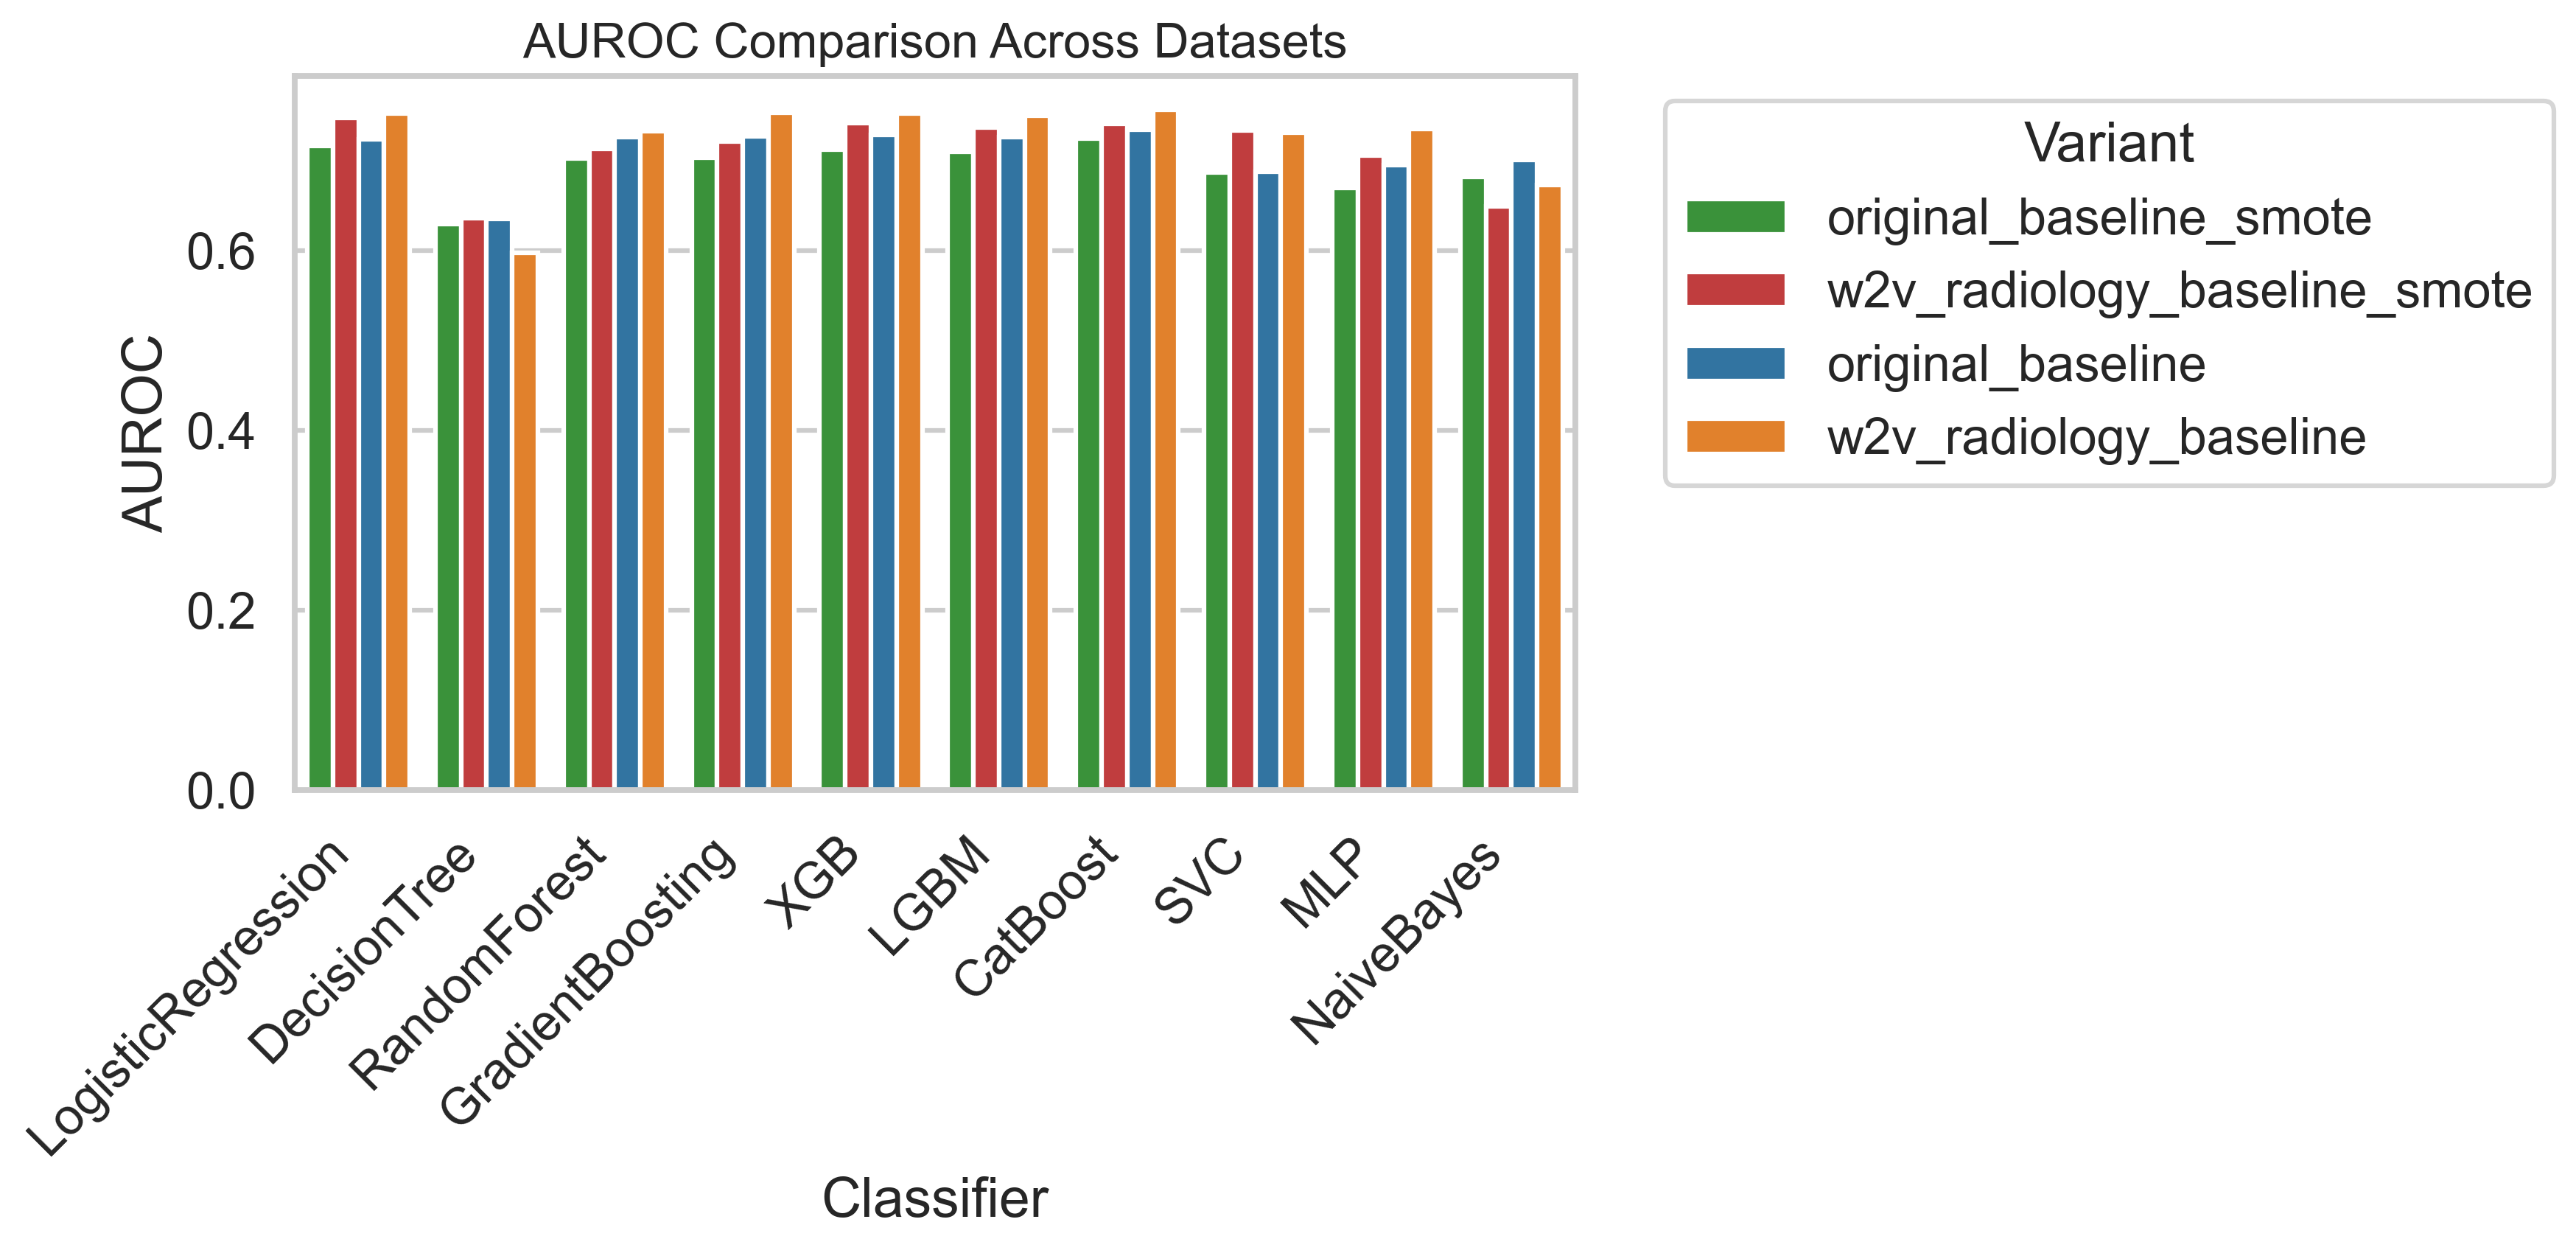

In [19]:
display(Image(filename=resolve_path("results/figures/comparisons/auroc_comparison_bar.png")))

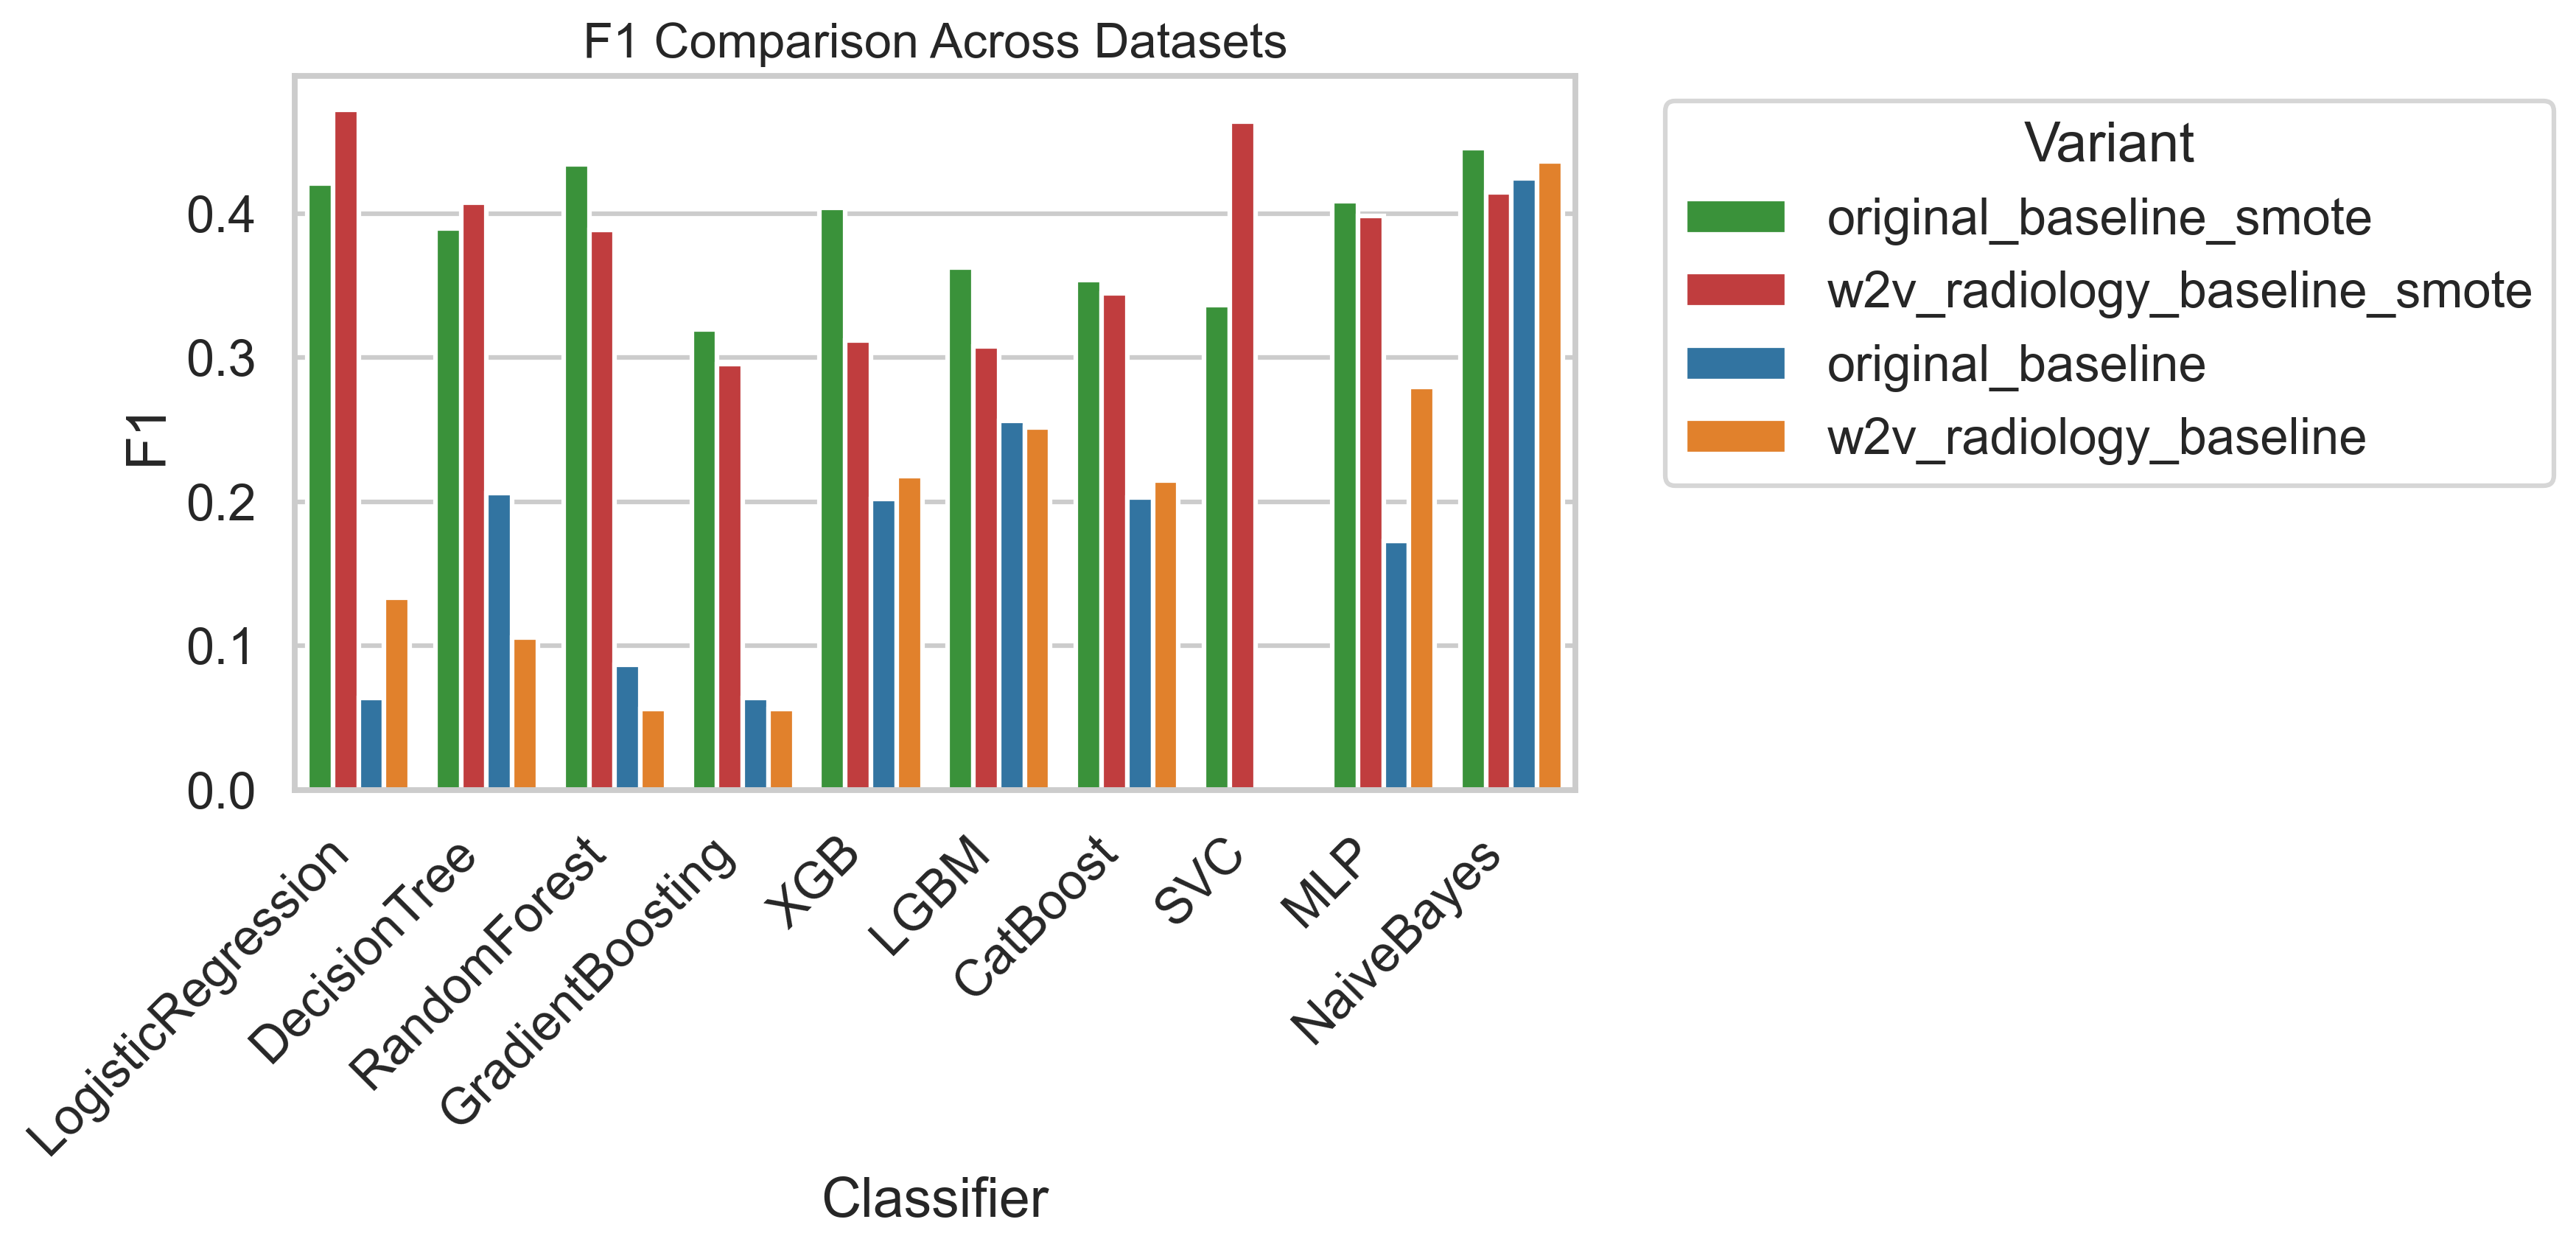

In [20]:
display(Image(filename=resolve_path("results/figures/comparisons/f1_comparison_bar.png")))

## 9 Metric Distribution (Violin Plots)

Visualize the spread and variance of scores for each metric and dataset variant.  
Useful for identifying consistent vs volatile model behavior.

In [25]:
variant_labels = {
    'original_baseline_smote': 'Original + SMOTE',
    'w2v_radiology_baseline_smote': 'W2V + SMOTE',
    'original_baseline': 'Original',
    'w2v_radiology_baseline': 'W2V',
}

for metric in available_metrics:
    plt.figure(figsize=(9,6))
    ax = sns.violinplot(
        data=metric_long.query("Metric == @metric"),
        x='Variant', y='Score', hue='Variant',
        order=hue_order, hue_order=hue_order,
        palette=palette, inner='quartile', legend=False
    )
    ax.set_xticklabels([variant_labels[v] for v in hue_order])
    plt.title(f'{metric} Score Distribution Across Variants', fontsize=16)
    plt.ylabel(metric)
    plt.xlabel('')
    plt.tight_layout()
    
    save_path = fig_root / f"{metric.lower()}_comparison_violin.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"🎻 Saved → {save_path}")


🎻 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\comparisons\auroc_comparison_violin.png
🎻 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\comparisons\f1_comparison_violin.png


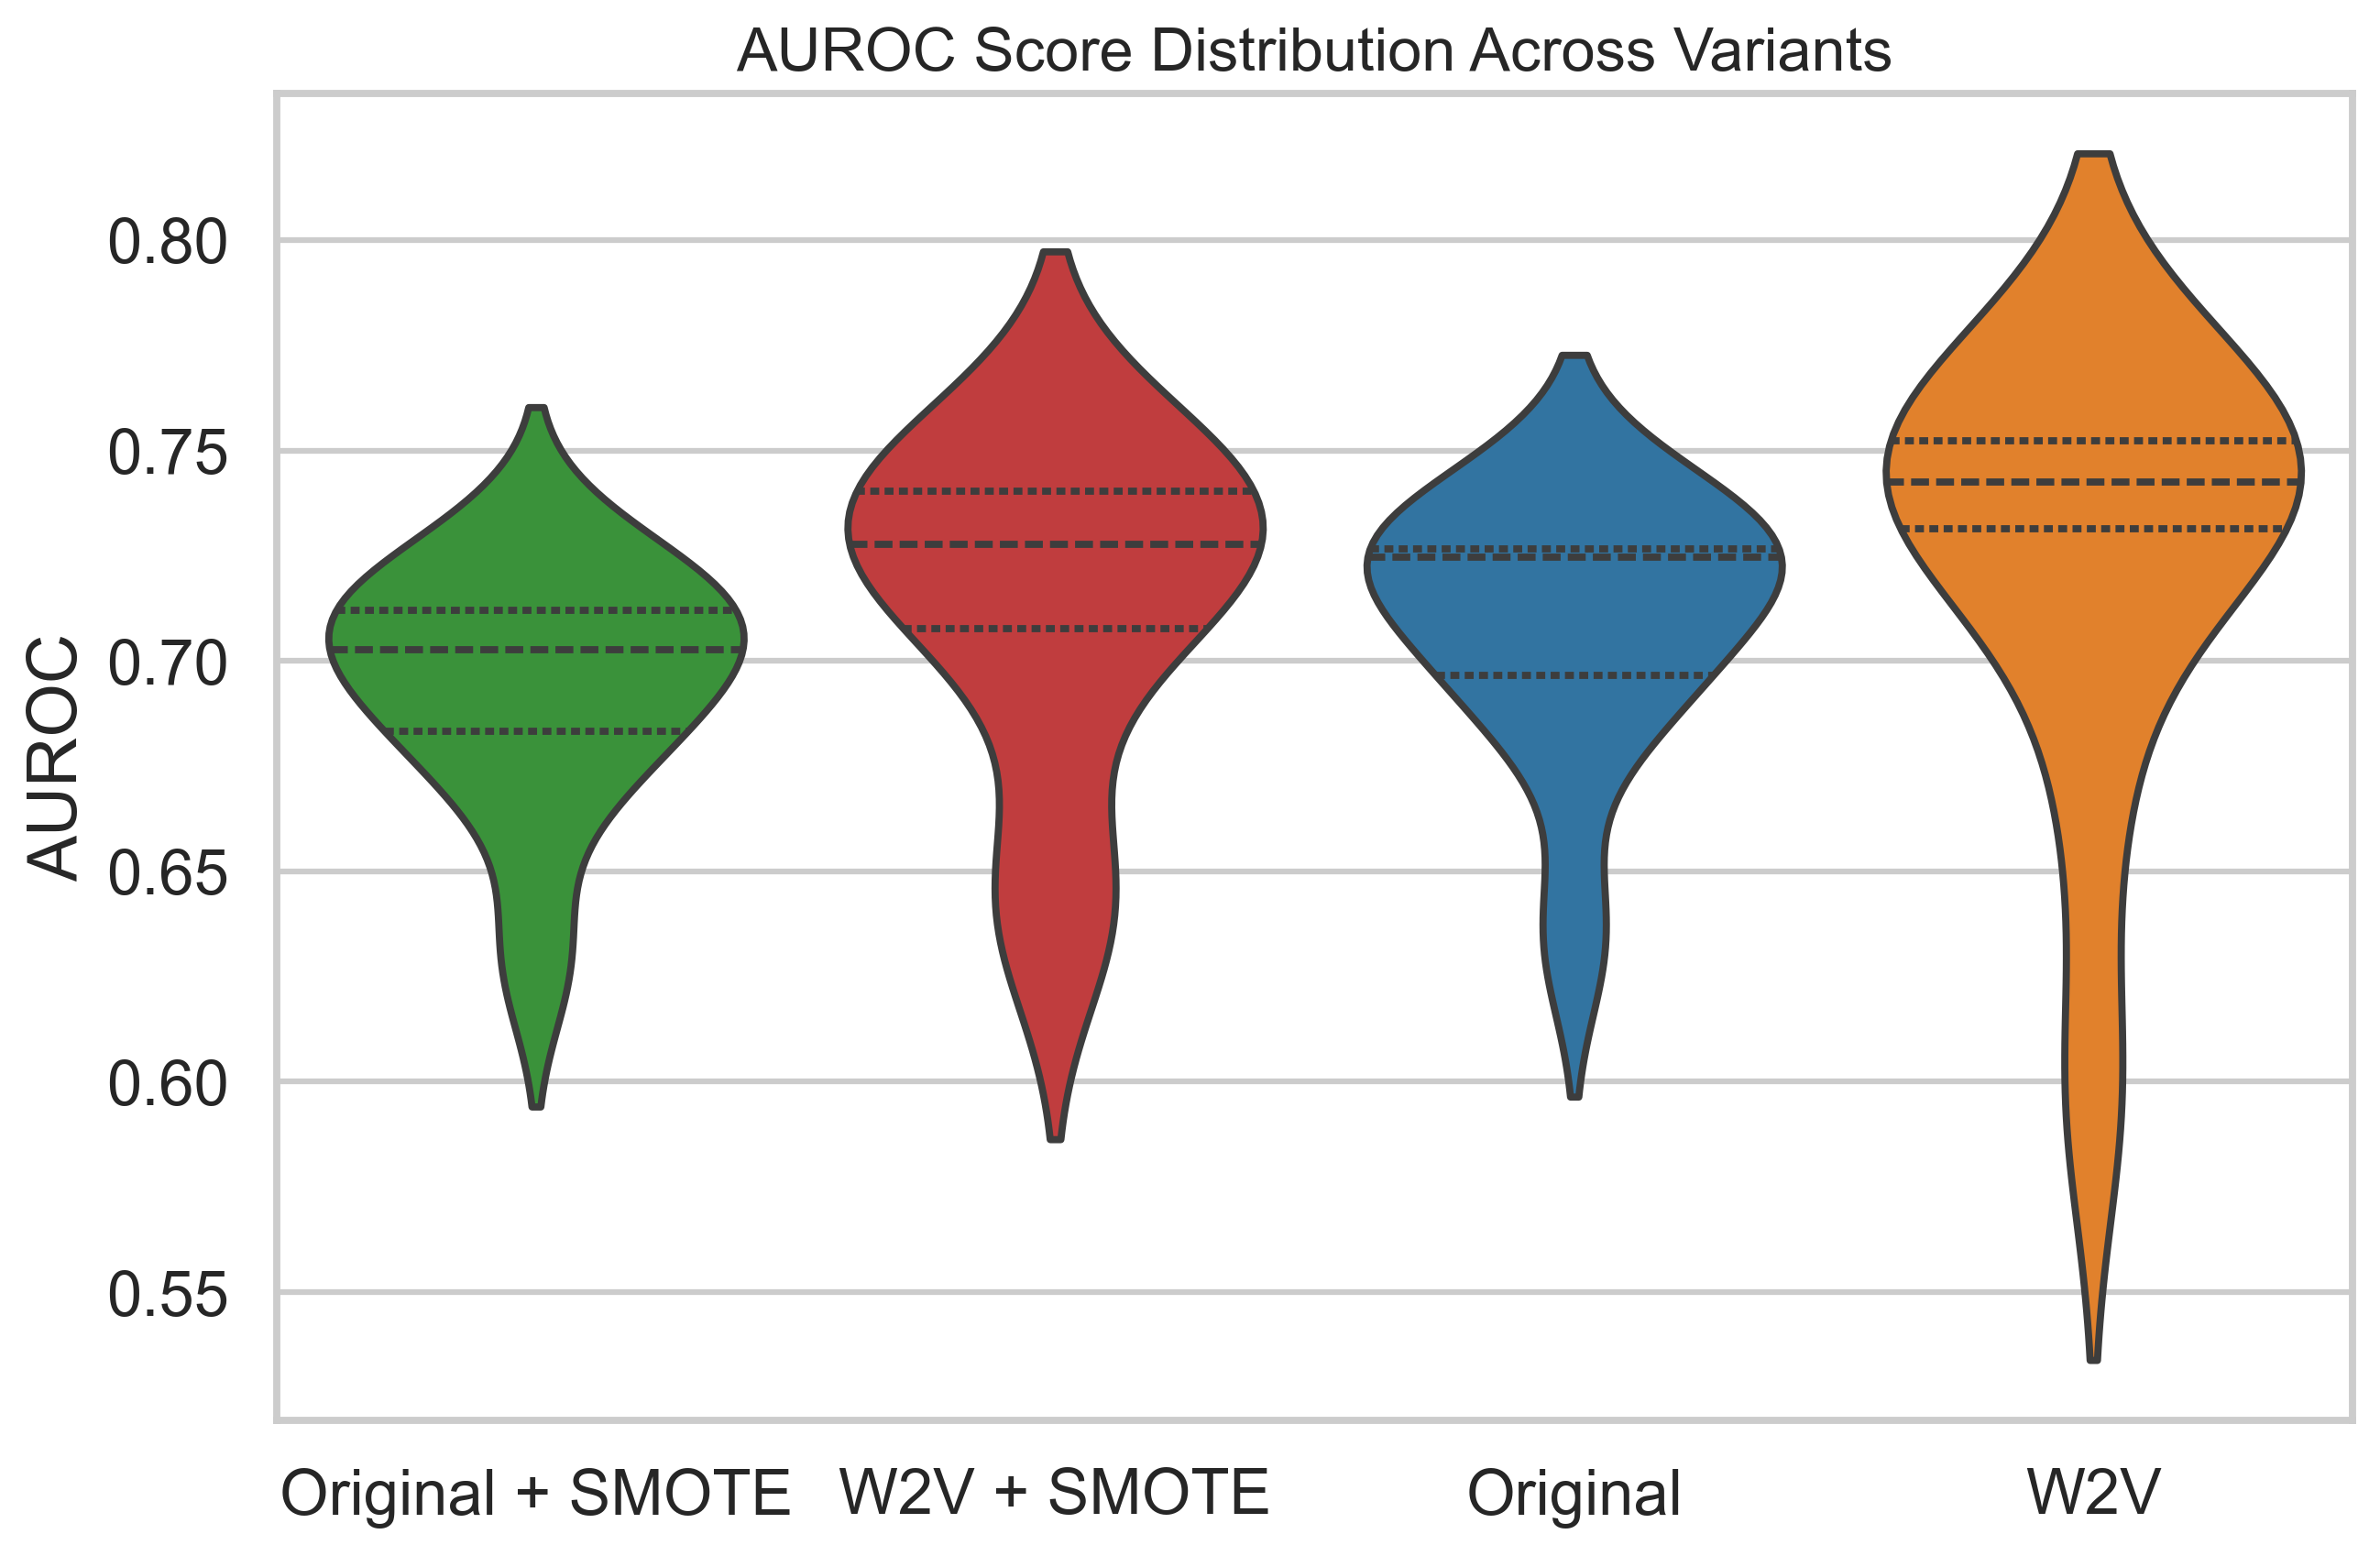

In [26]:
display(Image(filename=resolve_path("results/figures/comparisons/auroc_comparison_violin.png")))

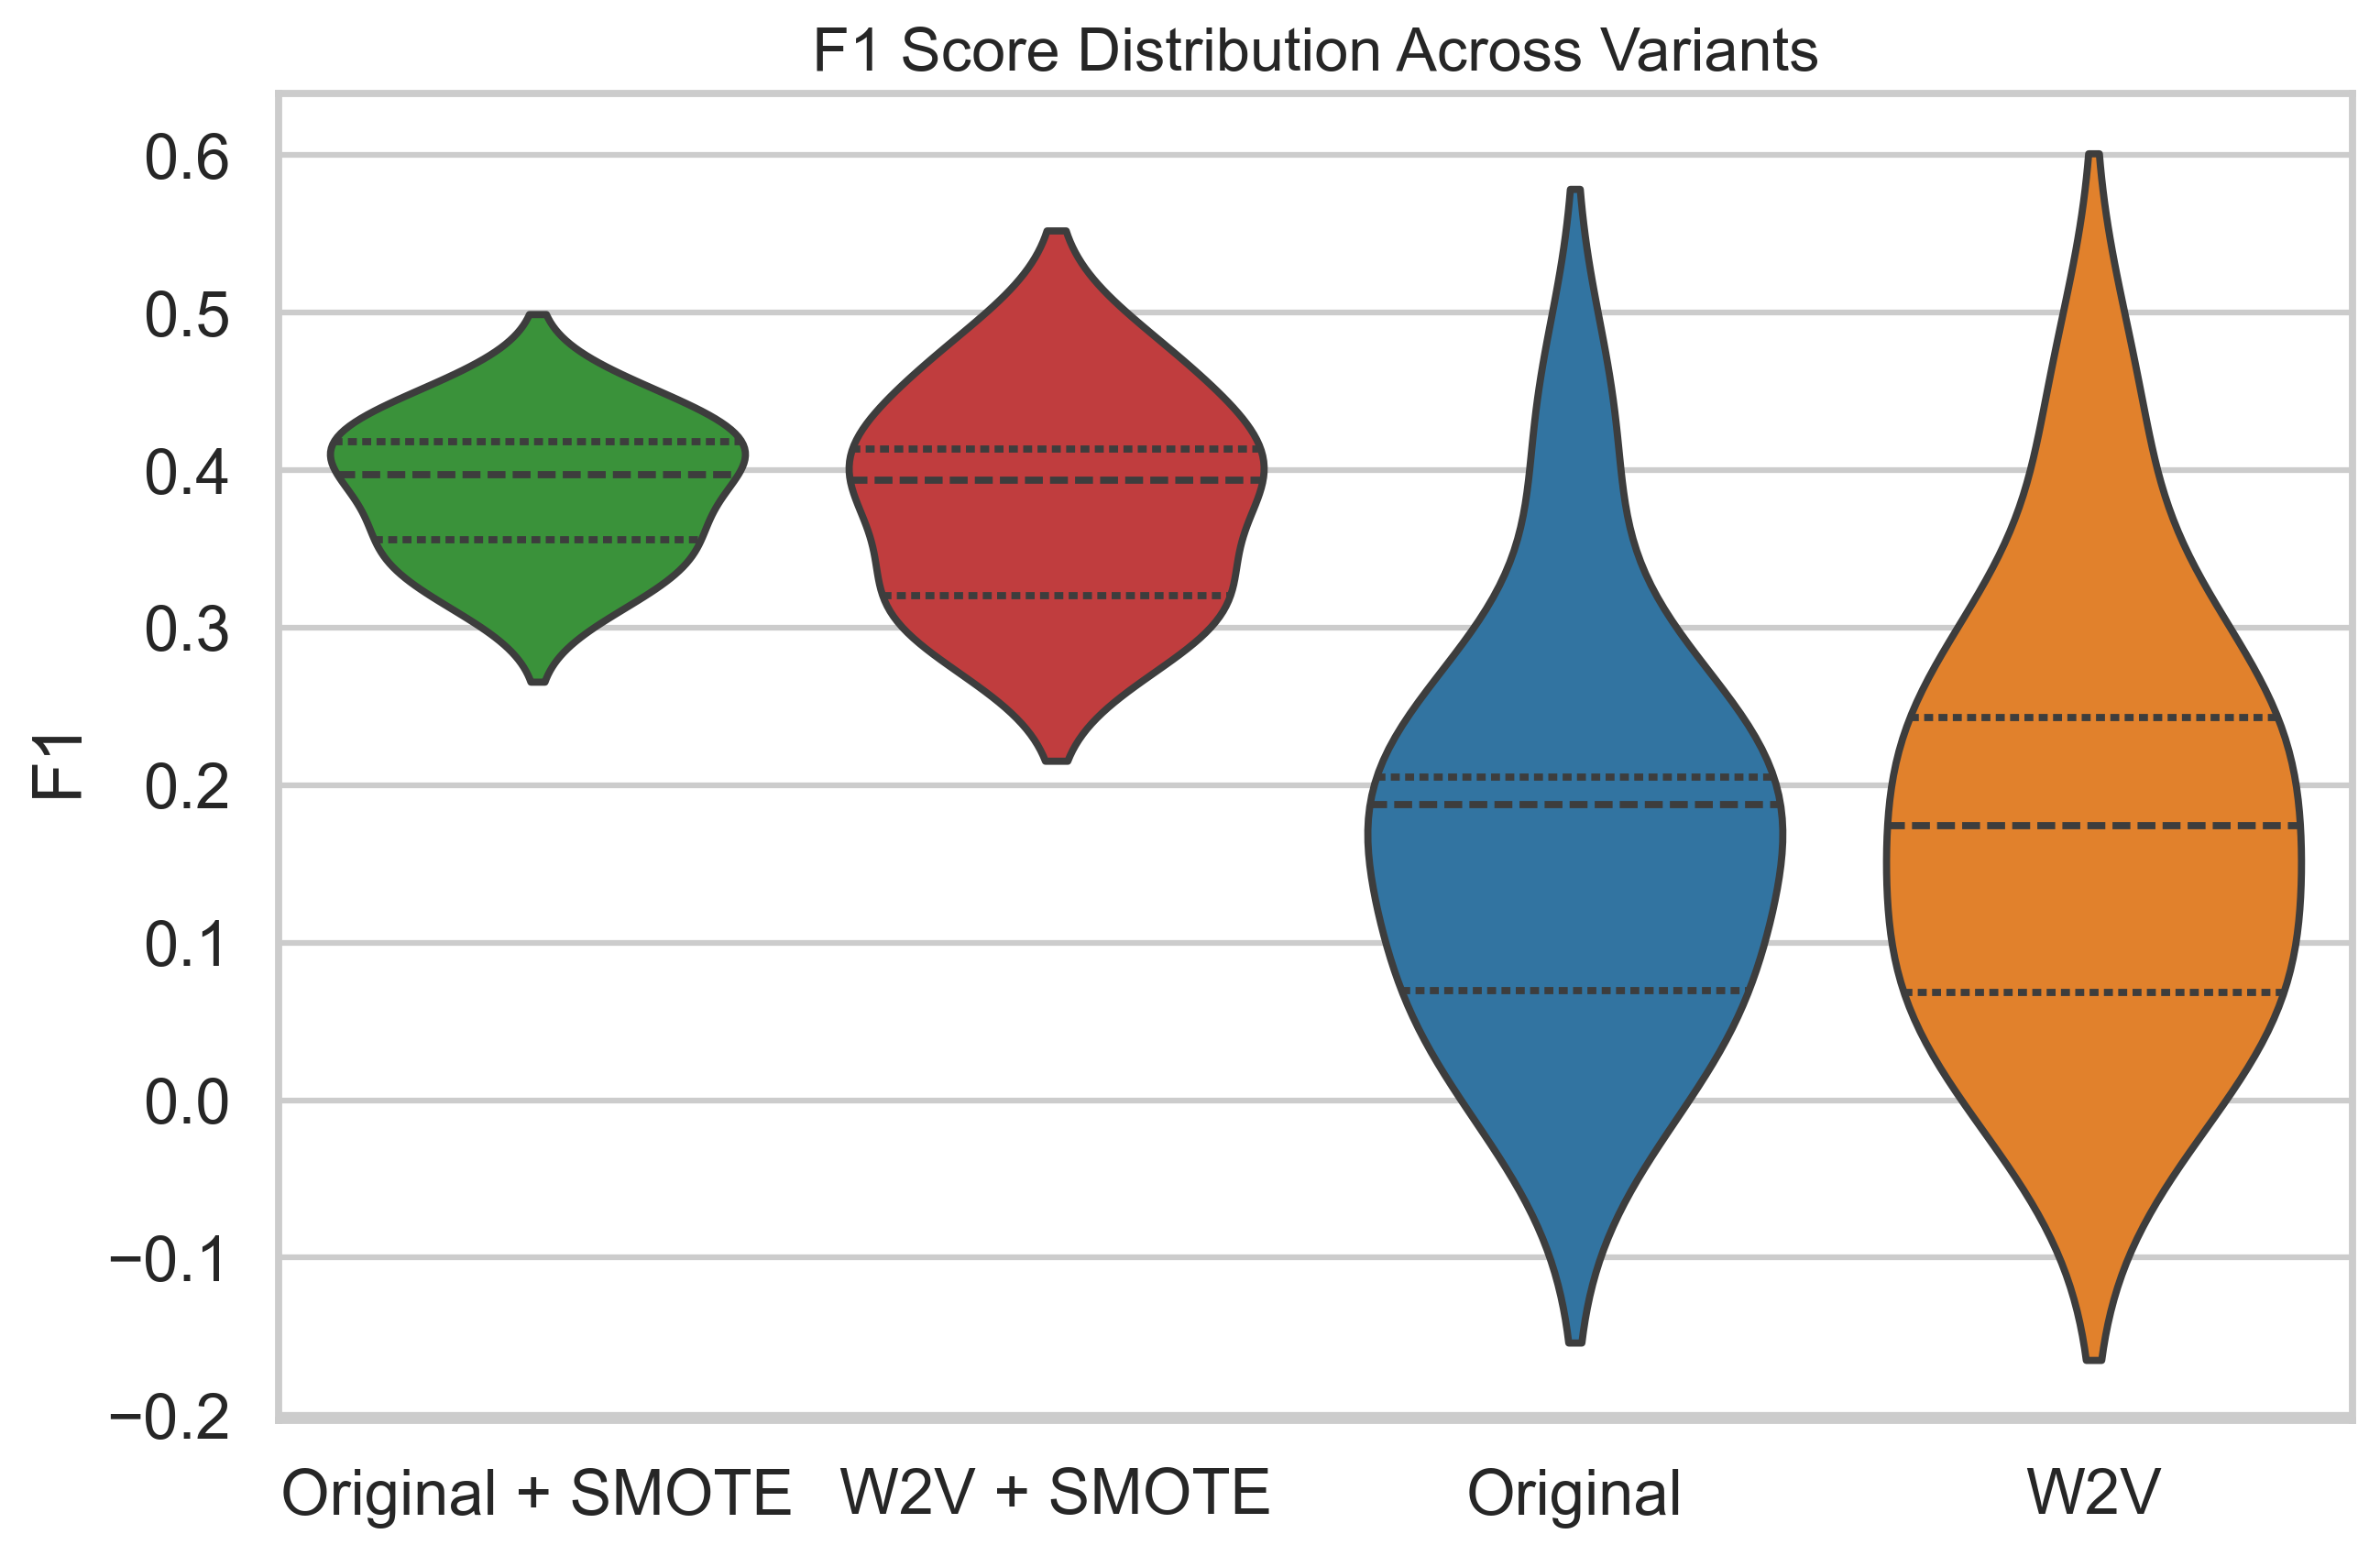

In [27]:
display(Image(filename=resolve_path("results/figures/comparisons/f1_comparison_violin.png")))

# Part 3 Explainability and Feature Importance (SHAP)

In this section we interpret model behavior using:

- **SHAP values** (SHapley Additive exPlanations) for nonlinear tree-based models (XGB, LGBM, CatBoost)
- **Coefficient weights** for linear models (Logistic Regression)

**Objectives**
- Load trained pipelines for XGB, LGBM, CatBoost, and Logistic Regression.  
- Generate SHAP summary/dependence plots for tree models.  
- Generate coefficient bar plots for Logistic Regression.  
- Save all figures to `results/figures/{variant}/`.

## 10 Load Top Models

Select the final tuned or baseline best models for interpretation.  
(These were saved in `results/models/{variant}/` during Task 4 or Task 9.)

In [28]:
# ----------------------------------------------------------
# 1️⃣ Setup
# ----------------------------------------------------------
model_variants = ["original_baseline", "w2v_radiology_baseline"]
loaded_models_baseline, loaded_models_smote = {}, {}

# ----------------------------------------------------------
# 2️⃣ Locate and load all *_model.pkl files
# ----------------------------------------------------------
for variant in model_variants:
    variant_dir = Path(resolve_path(f"results/models/{variant}"))
    subdirs = sorted(
        [p for p in variant_dir.iterdir() if p.is_dir()],
        key=lambda x: x.stat().st_mtime,
        reverse=True
    )
    if not subdirs:
        print(f"⚠️ No run folders found for {variant}")
        continue

    latest_run = subdirs[0]
    print(f"📂 Using latest run folder for {variant} → {latest_run.name}")

    # Include all *_model.pkl except *_full*.pkl
    all_model_files = [
        f for f in glob.glob(str(resolve_path(f"{latest_run}/*.pkl")))
        if "_model.pkl" in f and "_full" not in f
    ]
    if not all_model_files:
        print(f"⚠️ No individual model.pkl files found in {latest_run}")
        continue

    for file in all_model_files:
        file_path = Path(file)
        name = file_path.stem  # e.g., original_baseline_20251027_0818_SVC_smote_model
        model = joblib.load(file_path)

        # Detect classifier name automatically
        clf_name = name.split("_")[-3] if "smote" in name.lower() else name.split("_")[-2]
        key = f"{variant}_{clf_name}"

        # Assign to baseline or SMOTE dictionary
        if "smote" in name.lower():
            loaded_models_smote[key.replace("_baseline", "_smote_baseline")] = model
        else:
            loaded_models_baseline[key] = model

        print(f"✅ Loaded {clf_name:<18} | {'SMOTE' if 'smote' in name.lower() else 'Baseline'}")

# ----------------------------------------------------------
# 3️⃣ Unwrap nested estimators
# ----------------------------------------------------------
loaded_models_baseline = unwrap_best_estimators_non_smote(loaded_models_baseline)
loaded_models_smote    = unwrap_best_estimators_smote(loaded_models_smote)

# ----------------------------------------------------------
# 4️⃣ Summary
# ----------------------------------------------------------
print("\n📊 Summary of loaded models")
print(f"Baseline models → {len(loaded_models_baseline)}")
print(f"SMOTE models    → {len(loaded_models_smote)}")
print("Baseline keys:", list(loaded_models_baseline.keys()))
print("SMOTE keys:", list(loaded_models_smote.keys()))


📂 Using latest run folder for original_baseline → original_baseline_20251027_0818
✅ Loaded best               | Baseline
✅ Loaded best               | SMOTE
✅ Loaded CatBoost           | Baseline
✅ Loaded CatBoost           | SMOTE
✅ Loaded DecisionTree       | Baseline
✅ Loaded DecisionTree       | SMOTE
✅ Loaded GradientBoosting   | Baseline
✅ Loaded GradientBoosting   | SMOTE
✅ Loaded LGBM               | Baseline
✅ Loaded LGBM               | SMOTE
✅ Loaded LogisticRegression | Baseline
✅ Loaded LogisticRegression | SMOTE
✅ Loaded MLP                | Baseline
✅ Loaded MLP                | SMOTE
✅ Loaded NaiveBayes         | Baseline
✅ Loaded NaiveBayes         | SMOTE
✅ Loaded RandomForest       | Baseline
✅ Loaded RandomForest       | SMOTE
✅ Loaded SVC                | Baseline
✅ Loaded SVC                | SMOTE
✅ Loaded XGB                | Baseline
✅ Loaded XGB                | SMOTE
📂 Using latest run folder for w2v_radiology_baseline → w2v_radiology_baseline_20251026_1338
✅

In [31]:
from pprint import pprint

for key, model in loaded_models_smote.items():
    clf = model.named_steps["clf"] if hasattr(model, "named_steps") and "clf" in model.named_steps else model

    # try to get feature names if scaler exists
    scaler = model.named_steps.get("scaler", None) if hasattr(model, "named_steps") else None
    feature_names = getattr(scaler, "feature_names_in_", None)
    n_features = len(feature_names) if feature_names is not None else getattr(clf, "n_features_in_", "unknown")

    if type(clf).__name__ == "CatBoostClassifier":
        n_features = getattr(clf, "feature_names_", None)
        n_features = len(n_features) if n_features else "unknown"


    print(f"\n🔎 {key}")
    print(f"• Type: {type(clf).__name__}")
    print(f"• Number of input features used in training: {n_features}")
    print(f"• Has feature_importances_? {'Yes' if hasattr(clf, 'feature_importances_') else 'No'}")
    print(f"• Has coef_? {'Yes' if hasattr(clf, 'coef_') else 'No'}")



🔎 original_smote_baseline_best
• Type: CatBoostClassifier
• Number of input features used in training: 43
• Has feature_importances_? Yes
• Has coef_? No

🔎 original_smote_baseline_CatBoost
• Type: CatBoostClassifier
• Number of input features used in training: 43
• Has feature_importances_? Yes
• Has coef_? No

🔎 original_smote_baseline_DecisionTree
• Type: DecisionTreeClassifier
• Number of input features used in training: 43
• Has feature_importances_? Yes
• Has coef_? No

🔎 original_smote_baseline_GradientBoosting
• Type: GradientBoostingClassifier
• Number of input features used in training: 43
• Has feature_importances_? Yes
• Has coef_? No

🔎 original_smote_baseline_LGBM
• Type: LGBMClassifier
• Number of input features used in training: 43
• Has feature_importances_? Yes
• Has coef_? No

🔎 original_smote_baseline_LogisticRegression
• Type: LogisticRegression
• Number of input features used in training: 43
• Has feature_importances_? No
• Has coef_? Yes

🔎 original_smote_baseli

## 12 Prepare Representative Sample Data

Use a manageable subset (≈ 1 500 rows) of each test dataset for SHAP or coefficient visualization.

In [32]:
variants = ["original", "w2v_radiology"]
X_tests, y_tests = {}, {}

for variant in variants:
    x_path = resolve_path(f"data/processed/{variant}/data_{variant}_xtest.csv")
    y_path = resolve_path(f"data/processed/{variant}/data_{variant}_ytest.csv")

    if x_path.exists() and y_path.exists():
        X_tests[variant] = pd.read_csv(x_path)
        y_tests[variant] = pd.read_csv(y_path).squeeze()
        print(f"✅ Loaded test data for {variant}: {X_tests[variant].shape}")
    else:
        print(f"⚠️ Missing test data for {variant}")

# --- Create representative samples for SHAP/visualization ---
X_samples = {
    v: X_tests[v].sample(n=min(1500, len(X_tests[v])), random_state=42)
    for v in X_tests
}
print(f"📦 Created samples for {len(X_samples)} variants → {list(X_samples.keys())}")

✅ Loaded test data for original: (1042, 43)
✅ Loaded test data for w2v_radiology: (1042, 143)
📦 Created samples for 2 variants → ['original', 'w2v_radiology']


## 13 Compute SHAP Values and Coefficient Importances

- **Tree Models:** Use SHAP to derive feature contributions.  
- **Logistic Regression:** Use model coefficients (after scaling) as feature importances.


### Baseline Non-Smote

In [47]:
for key, model in loaded_models_baseline.items():
    full_variant, clf_name = key.rsplit("_", 1)
    variant_lookup = full_variant.replace("_baseline", "")

    print(f"\n🔍 Explainability for {clf_name} ({full_variant})")

    X_sample = X_samples.get(variant_lookup)
    if X_sample is None:
        print(f"⚠️ No sample data for {variant_lookup}, skipping.")
        continue

    # --- Safe unwrapping for both pipelines and direct estimators ---
    if hasattr(model, "named_steps"):
        clf = model.named_steps.get("clf", model)
    else:
        clf = model  # e.g., pure SVC, DecisionTree

    variant_fig_dir = resolve_path(f"results/figures/{full_variant}/")
    variant_fig_dir.mkdir(parents=True, exist_ok=True)

    # Skip SVC explainability
    if clf_name == "SVC":
        print(f"ℹ️ Skipping explainability for {clf_name} (computationally expensive, low added value).")
        continue

    # ---------- Logistic Regression ----------
    if "LogisticRegression" in clf_name:
        coef = clf.coef_.ravel()
        features = getattr(model.named_steps.get("scaler", None), "feature_names_in_", None) \
                   if hasattr(model, "named_steps") else X_sample.columns
        if features is None:
            features = X_sample.columns
        importance_df = pd.DataFrame({"Feature": features, "Coefficient": coef})
        importance_df["AbsValue"] = importance_df["Coefficient"].abs()
        topn = importance_df.sort_values("AbsValue", ascending=False).head(15)

        plt.figure(figsize=(8,6))
        plt.barh(topn["Feature"][::-1], topn["Coefficient"][::-1], color="steelblue")
        plt.xlabel("Coefficient Value")
        plt.title(f"Top 15 Coefficients ({clf_name}, {full_variant})")
        plt.tight_layout()
        save_coef = variant_fig_dir / f"coefficients_{full_variant}_{clf_name}.png"
        plt.savefig(save_coef, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"📊 Saved coefficient plot → {save_coef}")
        continue

    # ---------- SHAP Explainability ----------
    try:
        X_bg = X_sample.sample(n=min(800, len(X_sample)), random_state=42)

        # TreeExplainer for trees; fallback otherwise
        if hasattr(clf, "get_booster") or hasattr(clf, "feature_importances_"):
            try:
                explainer = shap.TreeExplainer(clf, X_bg, feature_perturbation="interventional")
                shap_values = explainer(X_sample, check_additivity=False)
            except Exception:
                explainer = shap.Explainer(clf.predict, X_bg)
                shap_values = explainer(X_sample)
        else:
            if hasattr(clf, "predict_proba"):
                explainer = shap.Explainer(clf.predict_proba, X_bg)
            elif hasattr(clf, "decision_function"):
                explainer = shap.Explainer(clf.decision_function, X_bg)
            else:
                print(f"⚠️ No callable probability or decision function for {clf_name}, skipping.")
                continue
            shap_values = explainer(X_sample)

        # Summary Plot
        shap.summary_plot(shap_values, X_sample, show=False, plot_type="bar", max_display=15)
        save_bar = variant_fig_dir / f"shap_summary_{full_variant}_{clf_name}.png"
        plt.title(f"Top 15 SHAP Features ({clf_name}, {full_variant})")
        plt.tight_layout()
        plt.savefig(save_bar, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"📊 Saved SHAP summary → {save_bar}")

        # ---------- Dependence Plot (Robust + Fallback) ----------
        try:
            # Special handling for RandomForest and DecisionTree
            if isinstance(clf, (DecisionTreeClassifier, RandomForestClassifier)):
                vals = shap_values.values
                if isinstance(vals, list):
                    vals = vals[1] if len(vals) > 1 else vals[0]
                elif vals.ndim == 3:
                    vals = vals[:, :, 1]  # use positive class
                else:
                    vals = np.array(vals)

                if vals.ndim != 2 or vals.shape[1] != X_sample.shape[1]:
                    raise ValueError("Tree-based SHAP mismatch, falling back to permutation importance.")

                abs_mean = np.abs(vals).mean(0)
                top_feature = X_sample.columns[abs_mean.argmax()]
                shap.dependence_plot(top_feature, vals, X_sample, show=False)
                save_dep = variant_fig_dir / f"shap_dependence_{full_variant}_{clf_name}_{top_feature}.png"
                plt.title(f"Dependence: {top_feature} ({clf_name}, {full_variant})")
                plt.tight_layout()
                plt.savefig(save_dep, dpi=300, bbox_inches="tight")
                plt.close()
                print(f"📈 Saved dependence plot → {save_dep}")

            else:
                vals = getattr(shap_values, "values", shap_values)
                if vals is None or np.ndim(vals) != 2:
                    raise ValueError("Invalid SHAP output shape for dependence plot.")

                abs_mean = np.abs(vals).mean(0)
                top_feature = X_sample.columns[abs_mean.argmax()]
                shap.dependence_plot(top_feature, vals, X_sample, show=False)
                save_dep = variant_fig_dir / f"shap_dependence_{full_variant}_{clf_name}_{top_feature}.png"
                plt.title(f"Dependence: {top_feature} ({clf_name}, {full_variant})")
                plt.tight_layout()
                plt.savefig(save_dep, dpi=300, bbox_inches="tight")
                plt.close()
                print(f"📈 Saved dependence plot → {save_dep}")

        except Exception as e:
            # Fallback to permutation importance
            print(f"⚠️ Dependence SHAP failed for {clf_name} ({full_variant}): {e}")
            try:
                result = permutation_importance(
                    clf, X_sample, y_tests[variant_lookup],
                    n_repeats=10, random_state=42
                )
                importances = pd.Series(result.importances_mean, index=X_sample.columns)
                top_imp = importances.sort_values(ascending=False).head(15)

                plt.figure(figsize=(8,6))
                plt.barh(top_imp.index[::-1], top_imp.values[::-1], color="darkorange")
                plt.title(f"Top 15 Permutation Importances ({clf_name}, {full_variant})")
                plt.xlabel("Mean Importance (Δ Accuracy)")
                plt.tight_layout()
                save_perm = variant_fig_dir / f"perm_importance_{full_variant}_{clf_name}.png"
                plt.savefig(save_perm, dpi=300, bbox_inches="tight")
                plt.close()
                print(f"🪄 Fallback: saved permutation importance plot → {save_perm}")
            except Exception as e2:
                print(f"⚠️ Dependence skipped for {clf_name} ({full_variant}): {e2}")

    except Exception as e:
        print(f"⚠️ SHAP failed for {clf_name} ({full_variant}): {e}")


🔍 Explainability for best (original_baseline)


 97%|=================== | 1013/1042 [00:12<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_best.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_dependence_original_baseline_best_avg_urineoutput.png

🔍 Explainability for CatBoost (original_baseline)


 99%|===================| 1035/1042 [00:12<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_CatBoost.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_dependence_original_baseline_CatBoost_avg_urineoutput.png

🔍 Explainability for DecisionTree (original_baseline)
📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_DecisionTree.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_dependence_original_baseline_DecisionTree_avg_urineoutput.png

🔍 Explainability for GradientBoosting (original_baseline)
📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Ma

 99%|===================| 1030/1042 [00:33<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_LGBM.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_dependence_original_baseline_LGBM_avg_urineoutput.png

🔍 Explainability for LogisticRegression (original_baseline)
📊 Saved coefficient plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\coefficients_original_baseline_LogisticRegression.png

🔍 Explainability for MLP (original_baseline)


PermutationExplainer explainer: 1043it [00:37, 20.11it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_MLP.png
⚠️ Dependence SHAP failed for MLP (original_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\perm_importance_original_baseline_MLP.png

🔍 Explainability for NaiveBayes (original_baseline)


PermutationExplainer explainer: 1043it [00:56, 15.25it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_NaiveBayes.png
⚠️ Dependence SHAP failed for NaiveBayes (original_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\perm_importance_original_baseline_NaiveBayes.png

🔍 Explainability for RandomForest (original_baseline)


100%|===================| 2077/2084 [03:42<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_RandomForest.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_dependence_original_baseline_RandomForest_avg_urineoutput.png

🔍 Explainability for SVC (original_baseline)
ℹ️ Skipping explainability for SVC (computationally expensive, low added value).

🔍 Explainability for XGB (original_baseline)


 97%|=================== | 1014/1042 [00:14<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_summary_original_baseline_XGB.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\shap_dependence_original_baseline_XGB_avg_urineoutput.png

🔍 Explainability for best (w2v_radiology_baseline)


 98%|===================| 1024/1042 [00:38<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_best.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_dependence_w2v_radiology_baseline_best_avg_urineoutput.png

🔍 Explainability for CatBoost (w2v_radiology_baseline)


 98%|===================| 1020/1042 [00:37<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_CatBoost.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_dependence_w2v_radiology_baseline_CatBoost_avg_urineoutput.png

🔍 Explainability for DecisionTree (w2v_radiology_baseline)
📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_DecisionTree.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_dependence_w2v_radiology_baseline_DecisionTree_sbp_min.png

🔍 Explainability for GradientBoosting (w2v_radiology_baseline)
📊 Saved SHAP summary → C:\Users\tyler\OneDrive - Uni

 99%|===================| 1032/1042 [00:33<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_LGBM.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_dependence_w2v_radiology_baseline_LGBM_avg_urineoutput.png

🔍 Explainability for LogisticRegression (w2v_radiology_baseline)
📊 Saved coefficient plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\coefficients_w2v_radiology_baseline_LogisticRegression.png

🔍 Explainability for MLP (w2v_radiology_baseline)


PermutationExplainer explainer: 1043it [01:05, 13.45it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_MLP.png
⚠️ Dependence SHAP failed for MLP (w2v_radiology_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\perm_importance_w2v_radiology_baseline_MLP.png

🔍 Explainability for NaiveBayes (w2v_radiology_baseline)


PermutationExplainer explainer: 1043it [02:33,  6.34it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_NaiveBayes.png
⚠️ Dependence SHAP failed for NaiveBayes (w2v_radiology_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\perm_importance_w2v_radiology_baseline_NaiveBayes.png

🔍 Explainability for RandomForest (w2v_radiology_baseline)


 99%|===================| 2061/2084 [01:29<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_RandomForest.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_dependence_w2v_radiology_baseline_RandomForest_avg_urineoutput.png

🔍 Explainability for SVC (w2v_radiology_baseline)
ℹ️ Skipping explainability for SVC (computationally expensive, low added value).

🔍 Explainability for XGB (w2v_radiology_baseline)


 99%|===================| 1028/1042 [00:57<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_summary_w2v_radiology_baseline_XGB.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_baseline\shap_dependence_w2v_radiology_baseline_XGB_avg_urineoutput.png


#### Original Baseline Displays

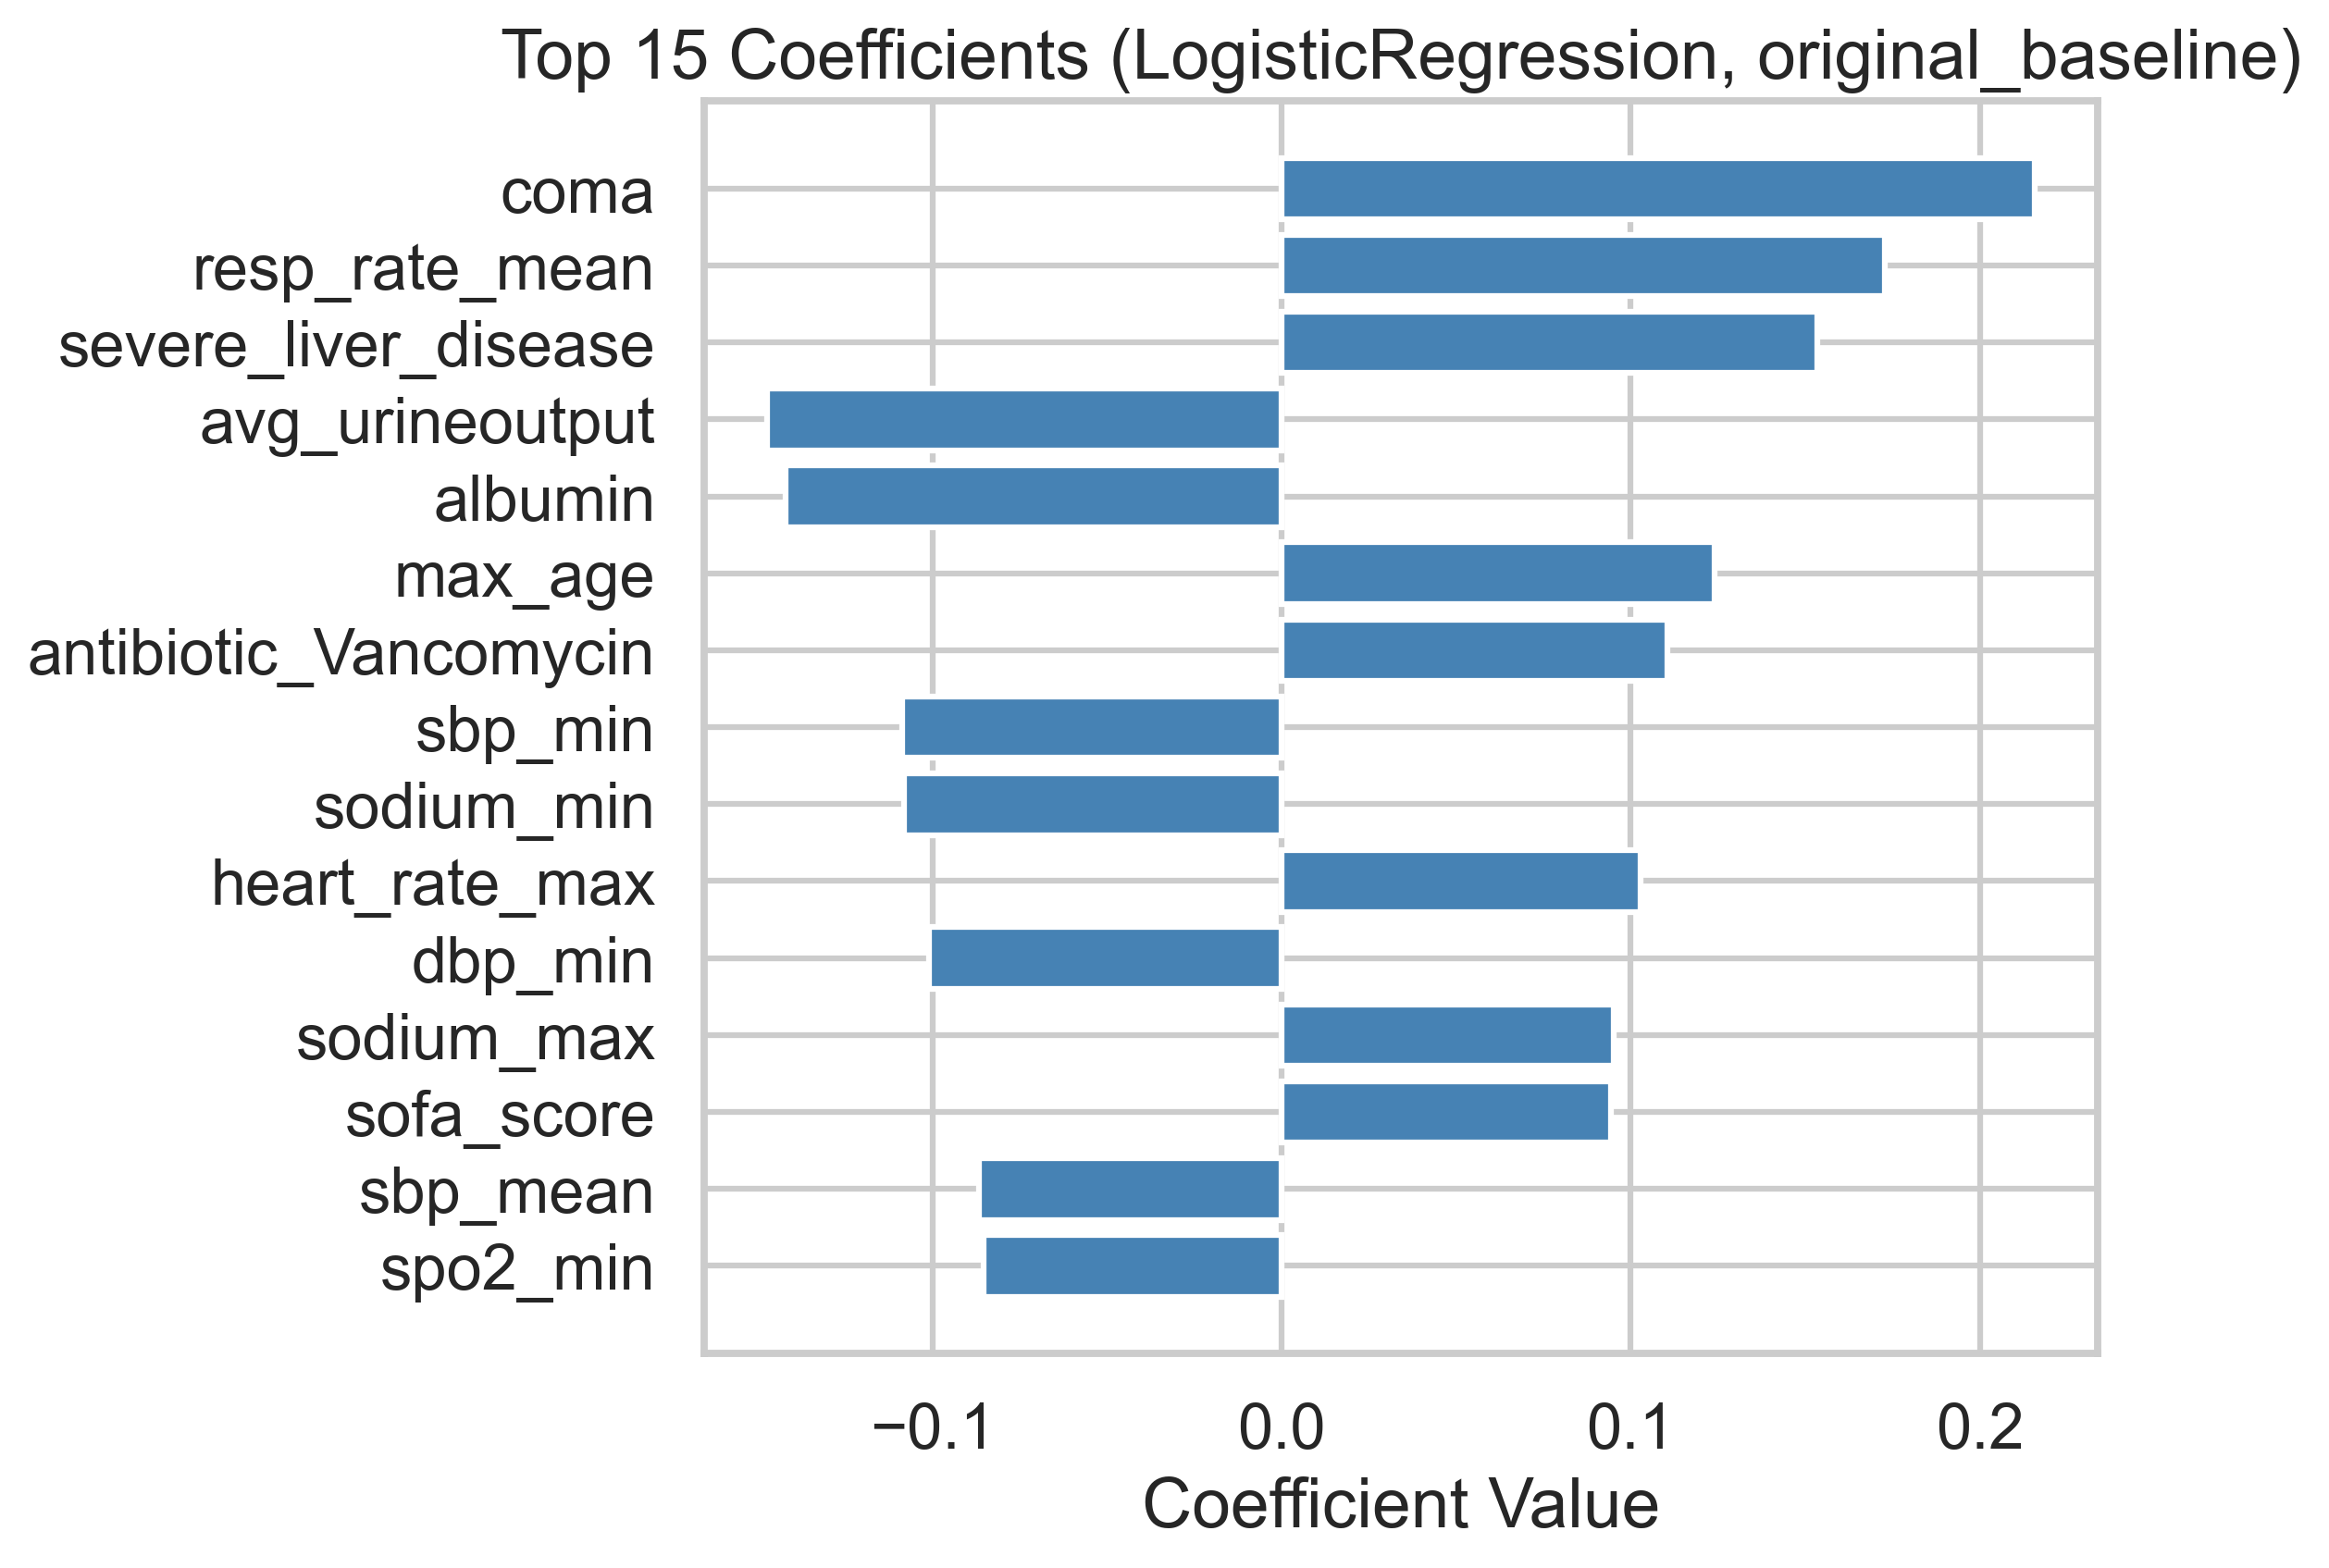

In [48]:
display(Image(filename=resolve_path("results/figures/original_baseline/coefficients_original_baseline_LogisticRegression.png")))

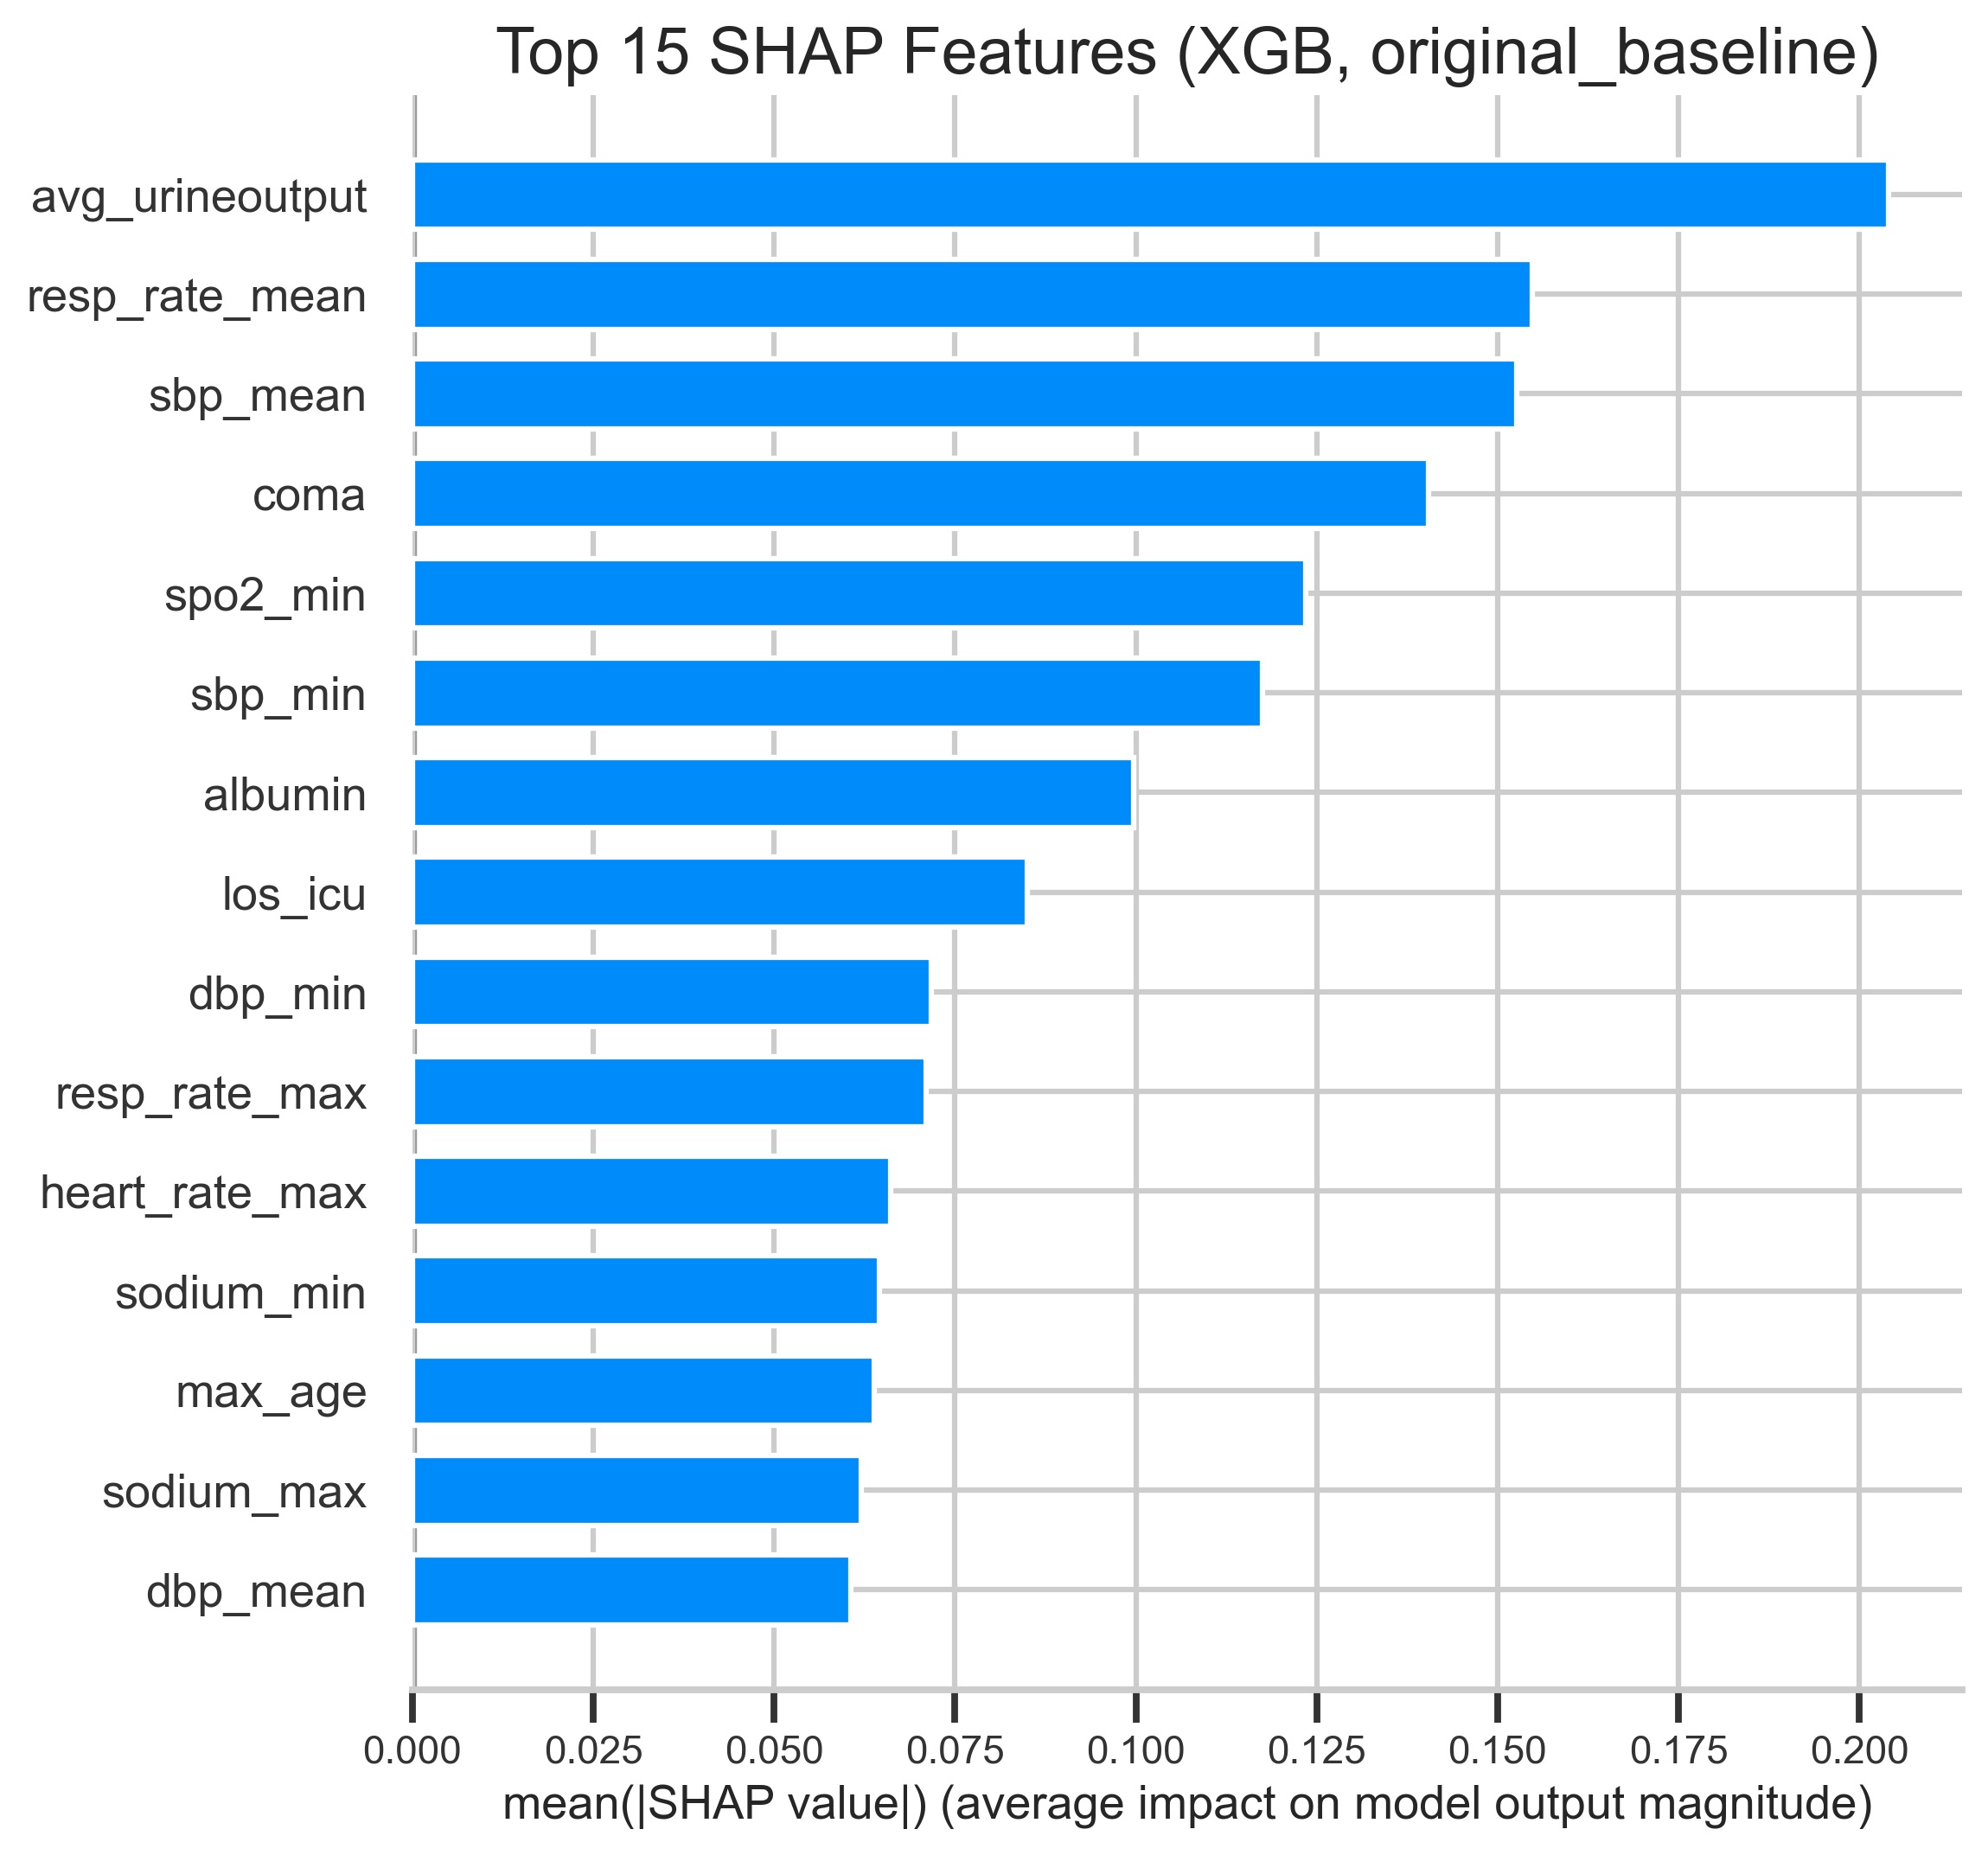

In [49]:
display(Image(filename=resolve_path("results/figures/original_baseline/shap_summary_original_baseline_XGB.png")))

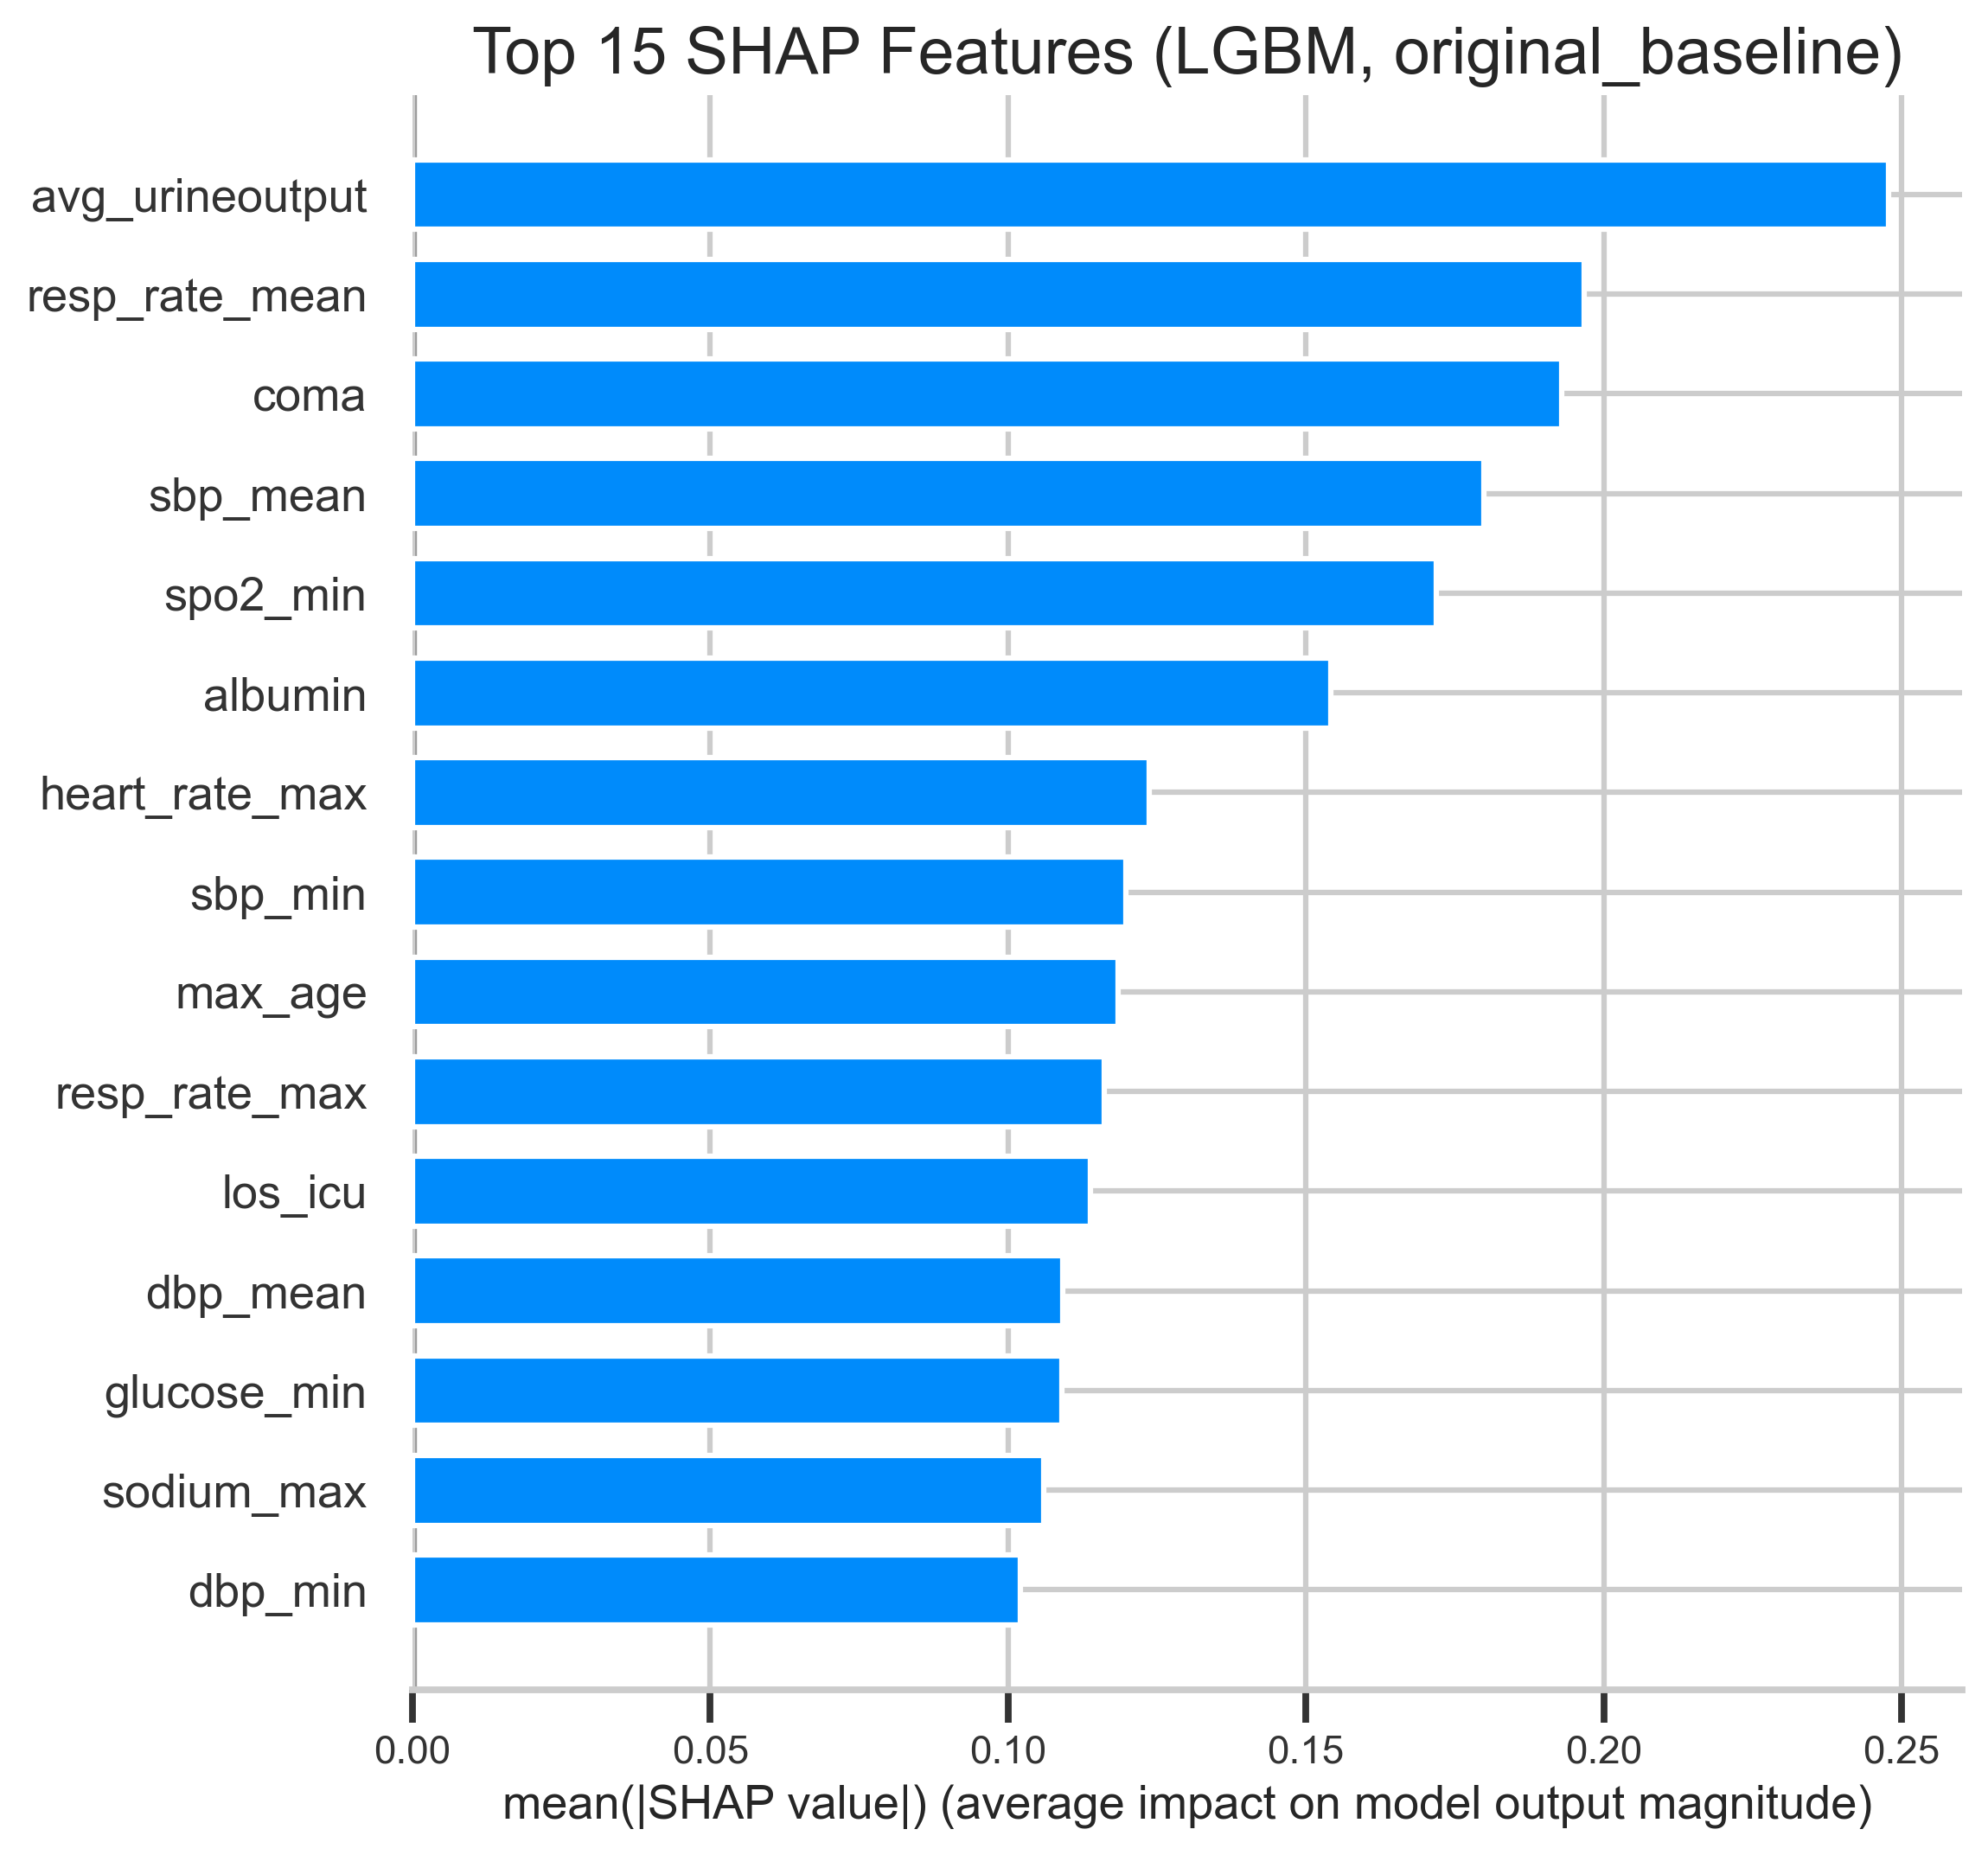

In [50]:
display(Image(filename=resolve_path("results/figures/original_baseline/shap_summary_original_baseline_LGBM.png")))

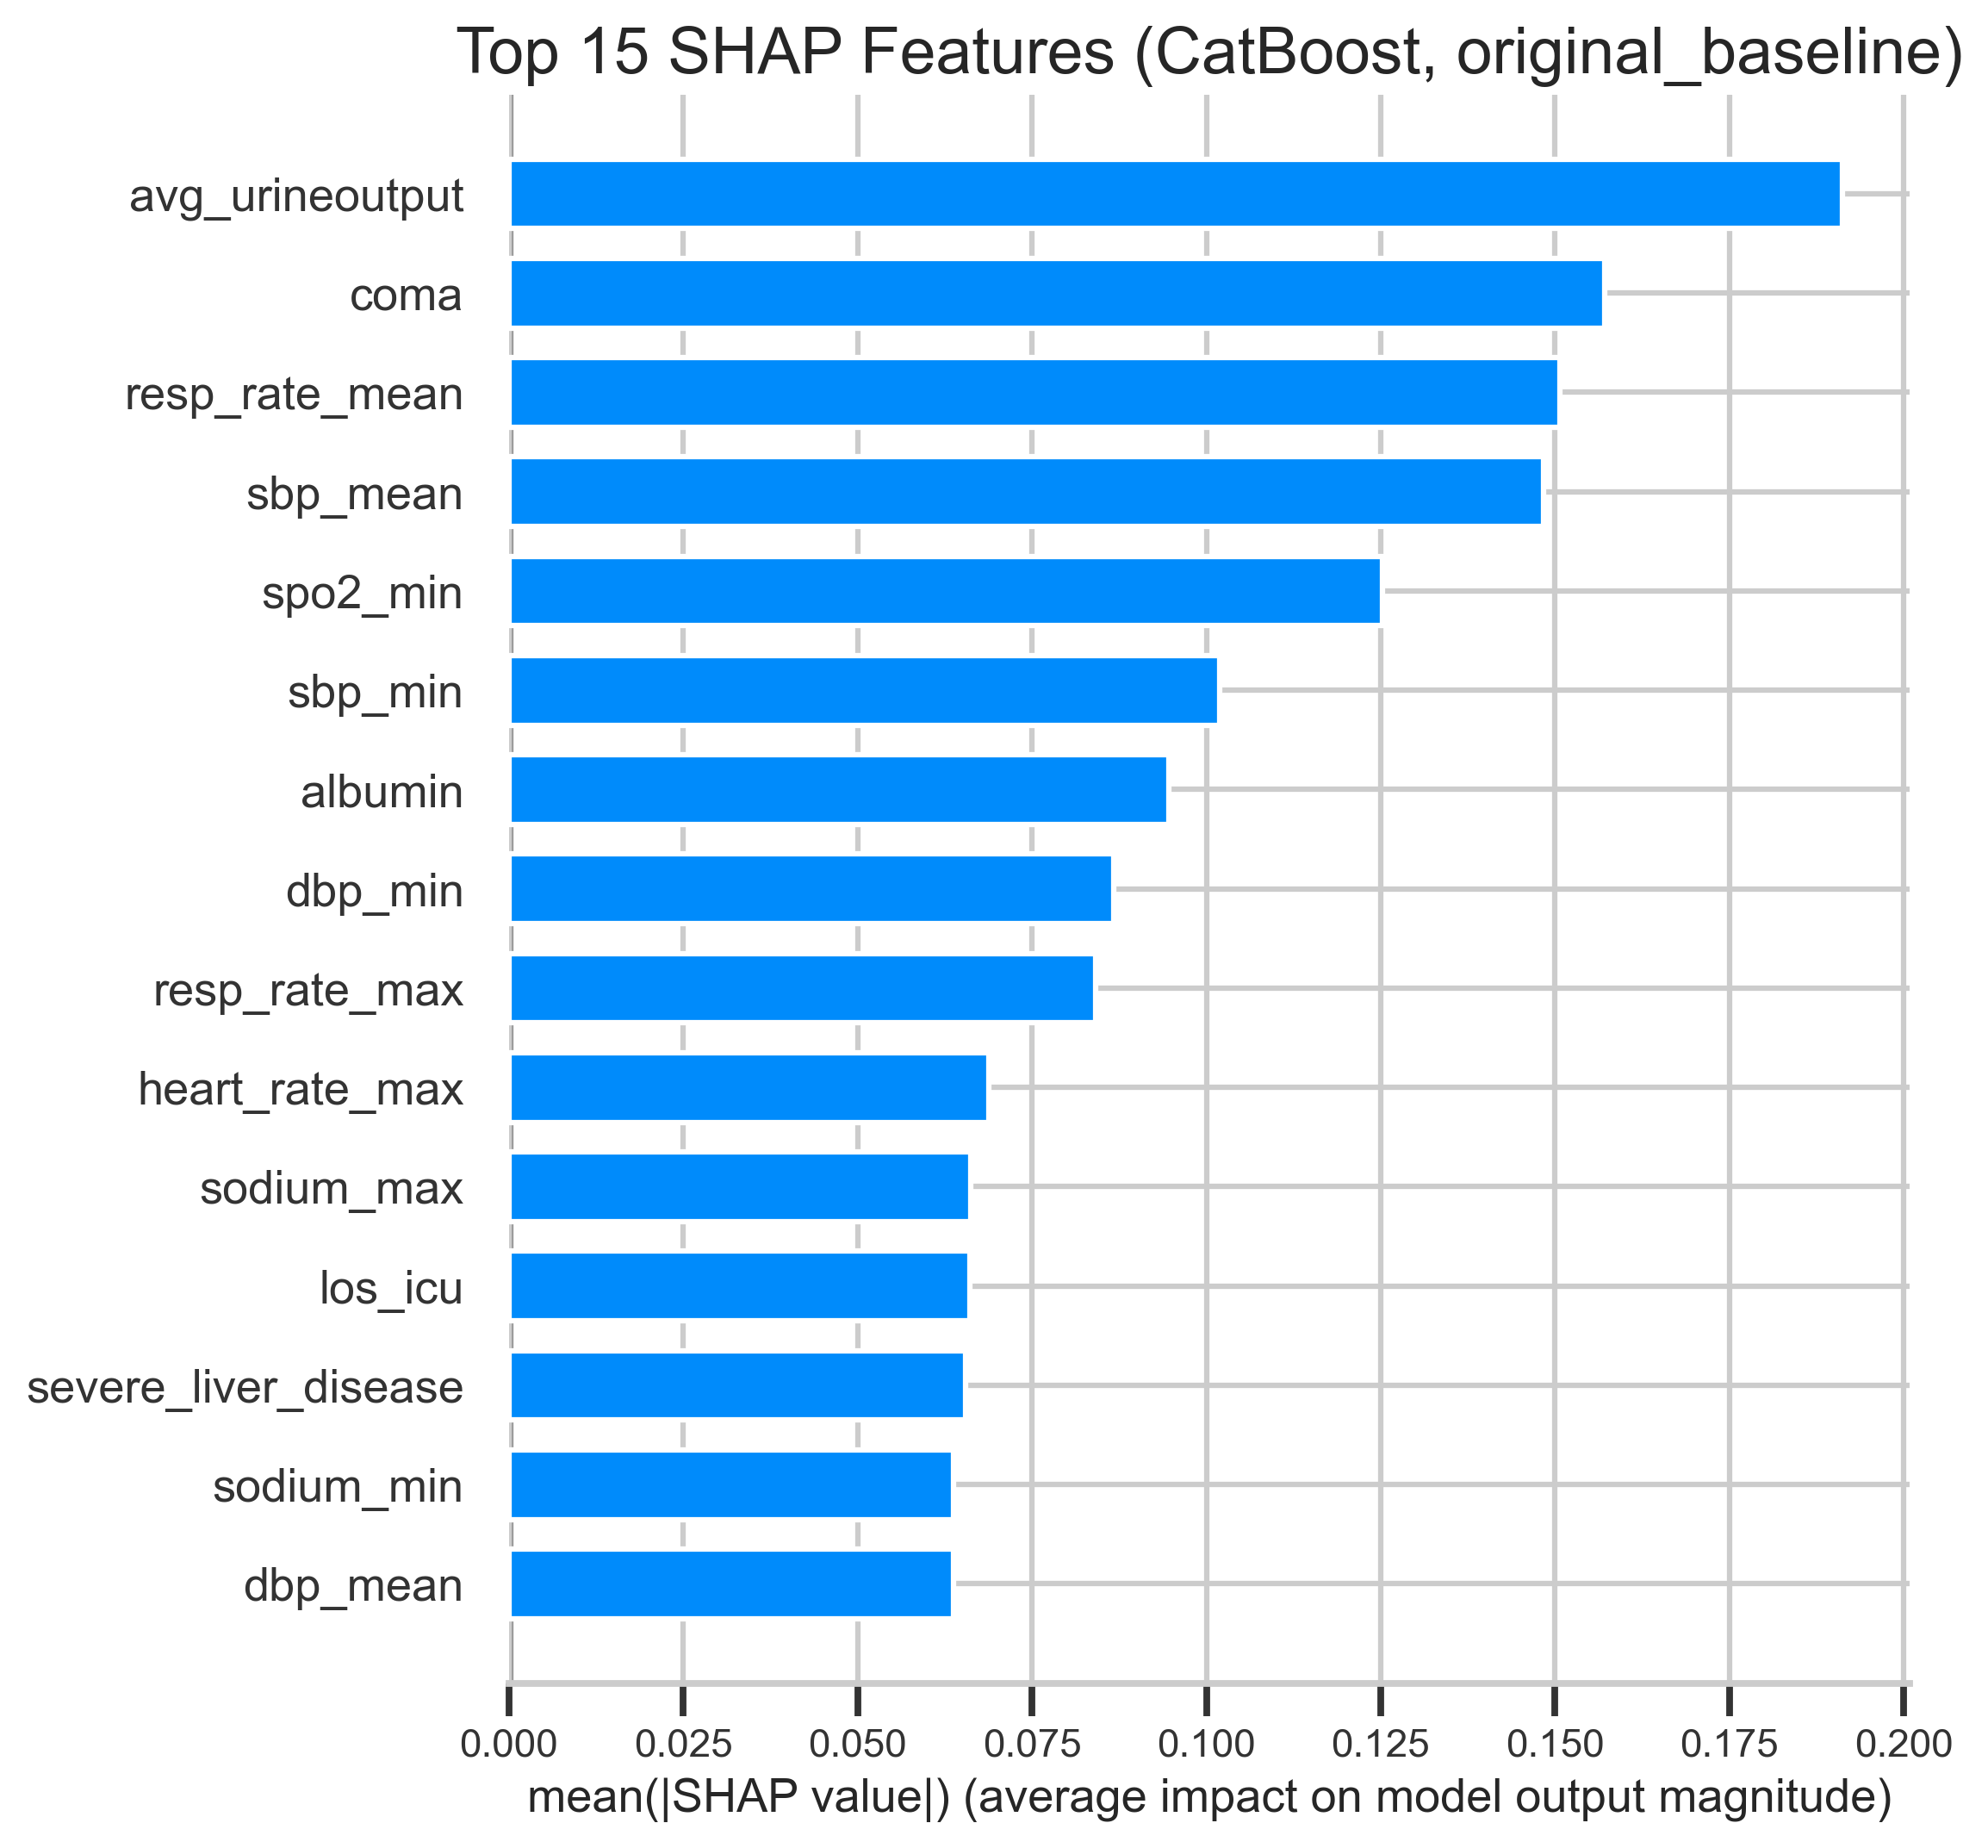

In [51]:
display(Image(filename=resolve_path("results/figures/original_baseline/shap_summary_original_baseline_CatBoost.png")))

#### W2V Baseline Displays

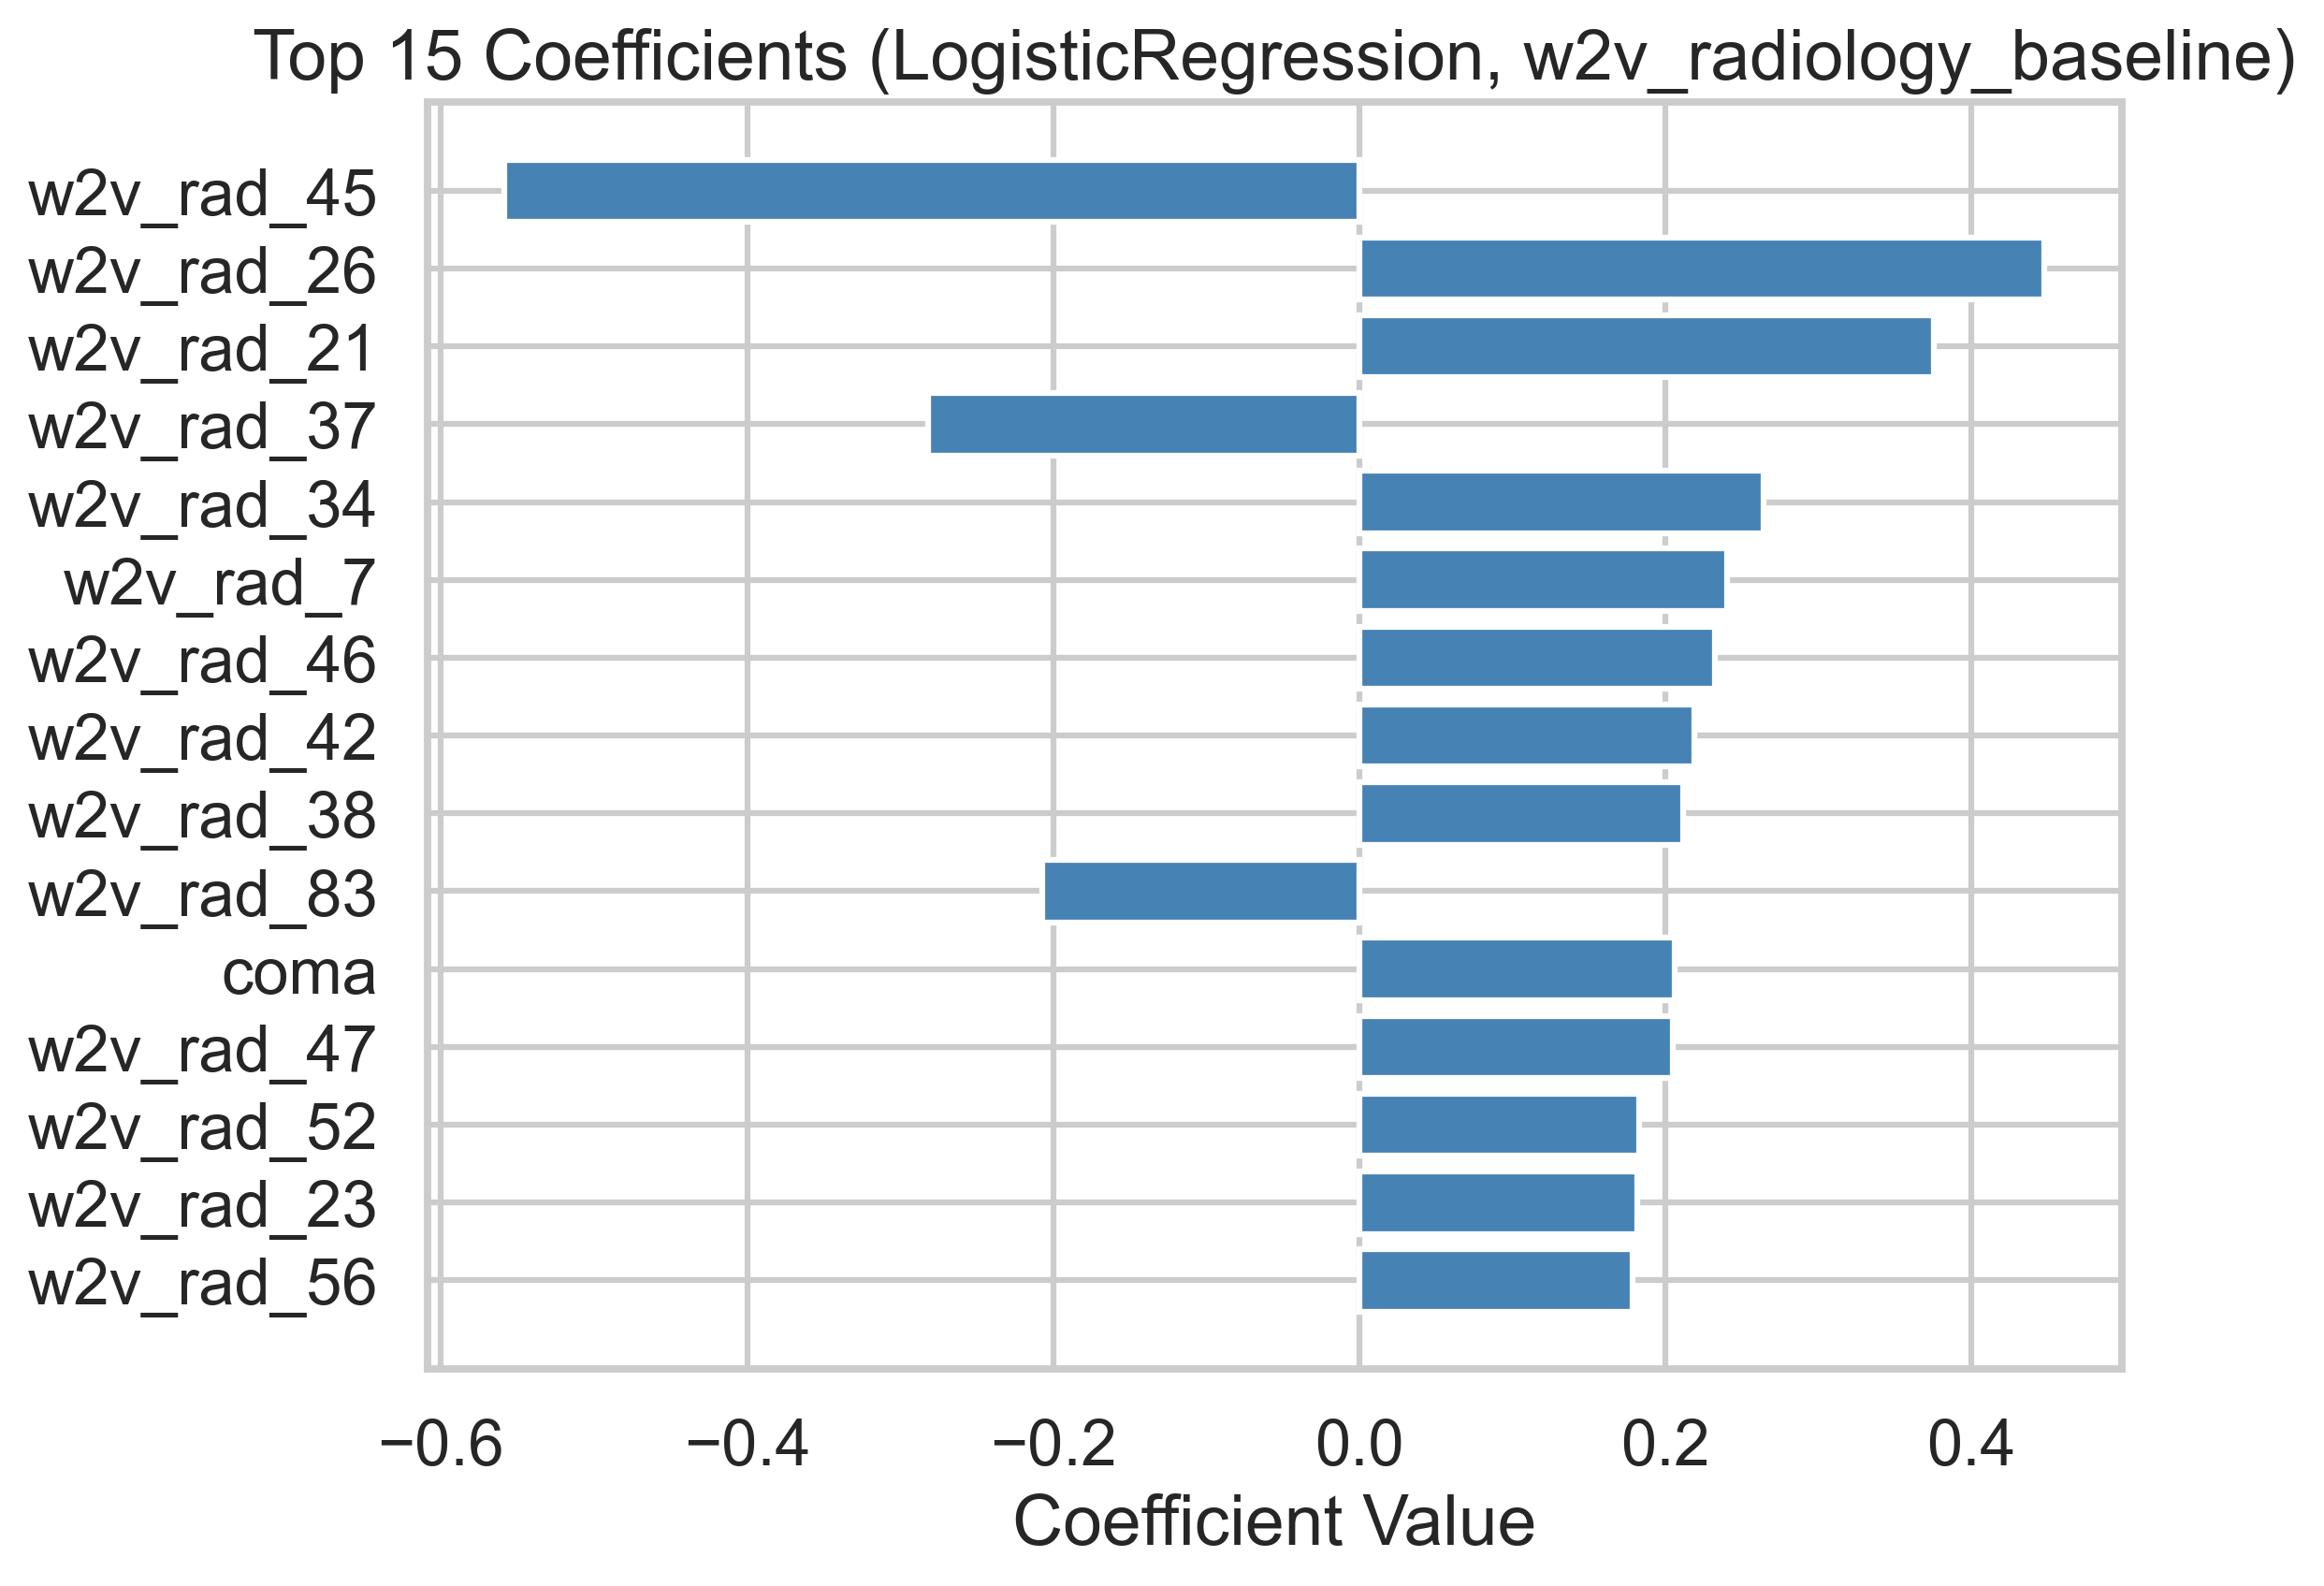

In [52]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_baseline/coefficients_w2v_radiology_baseline_LogisticRegression.png")))

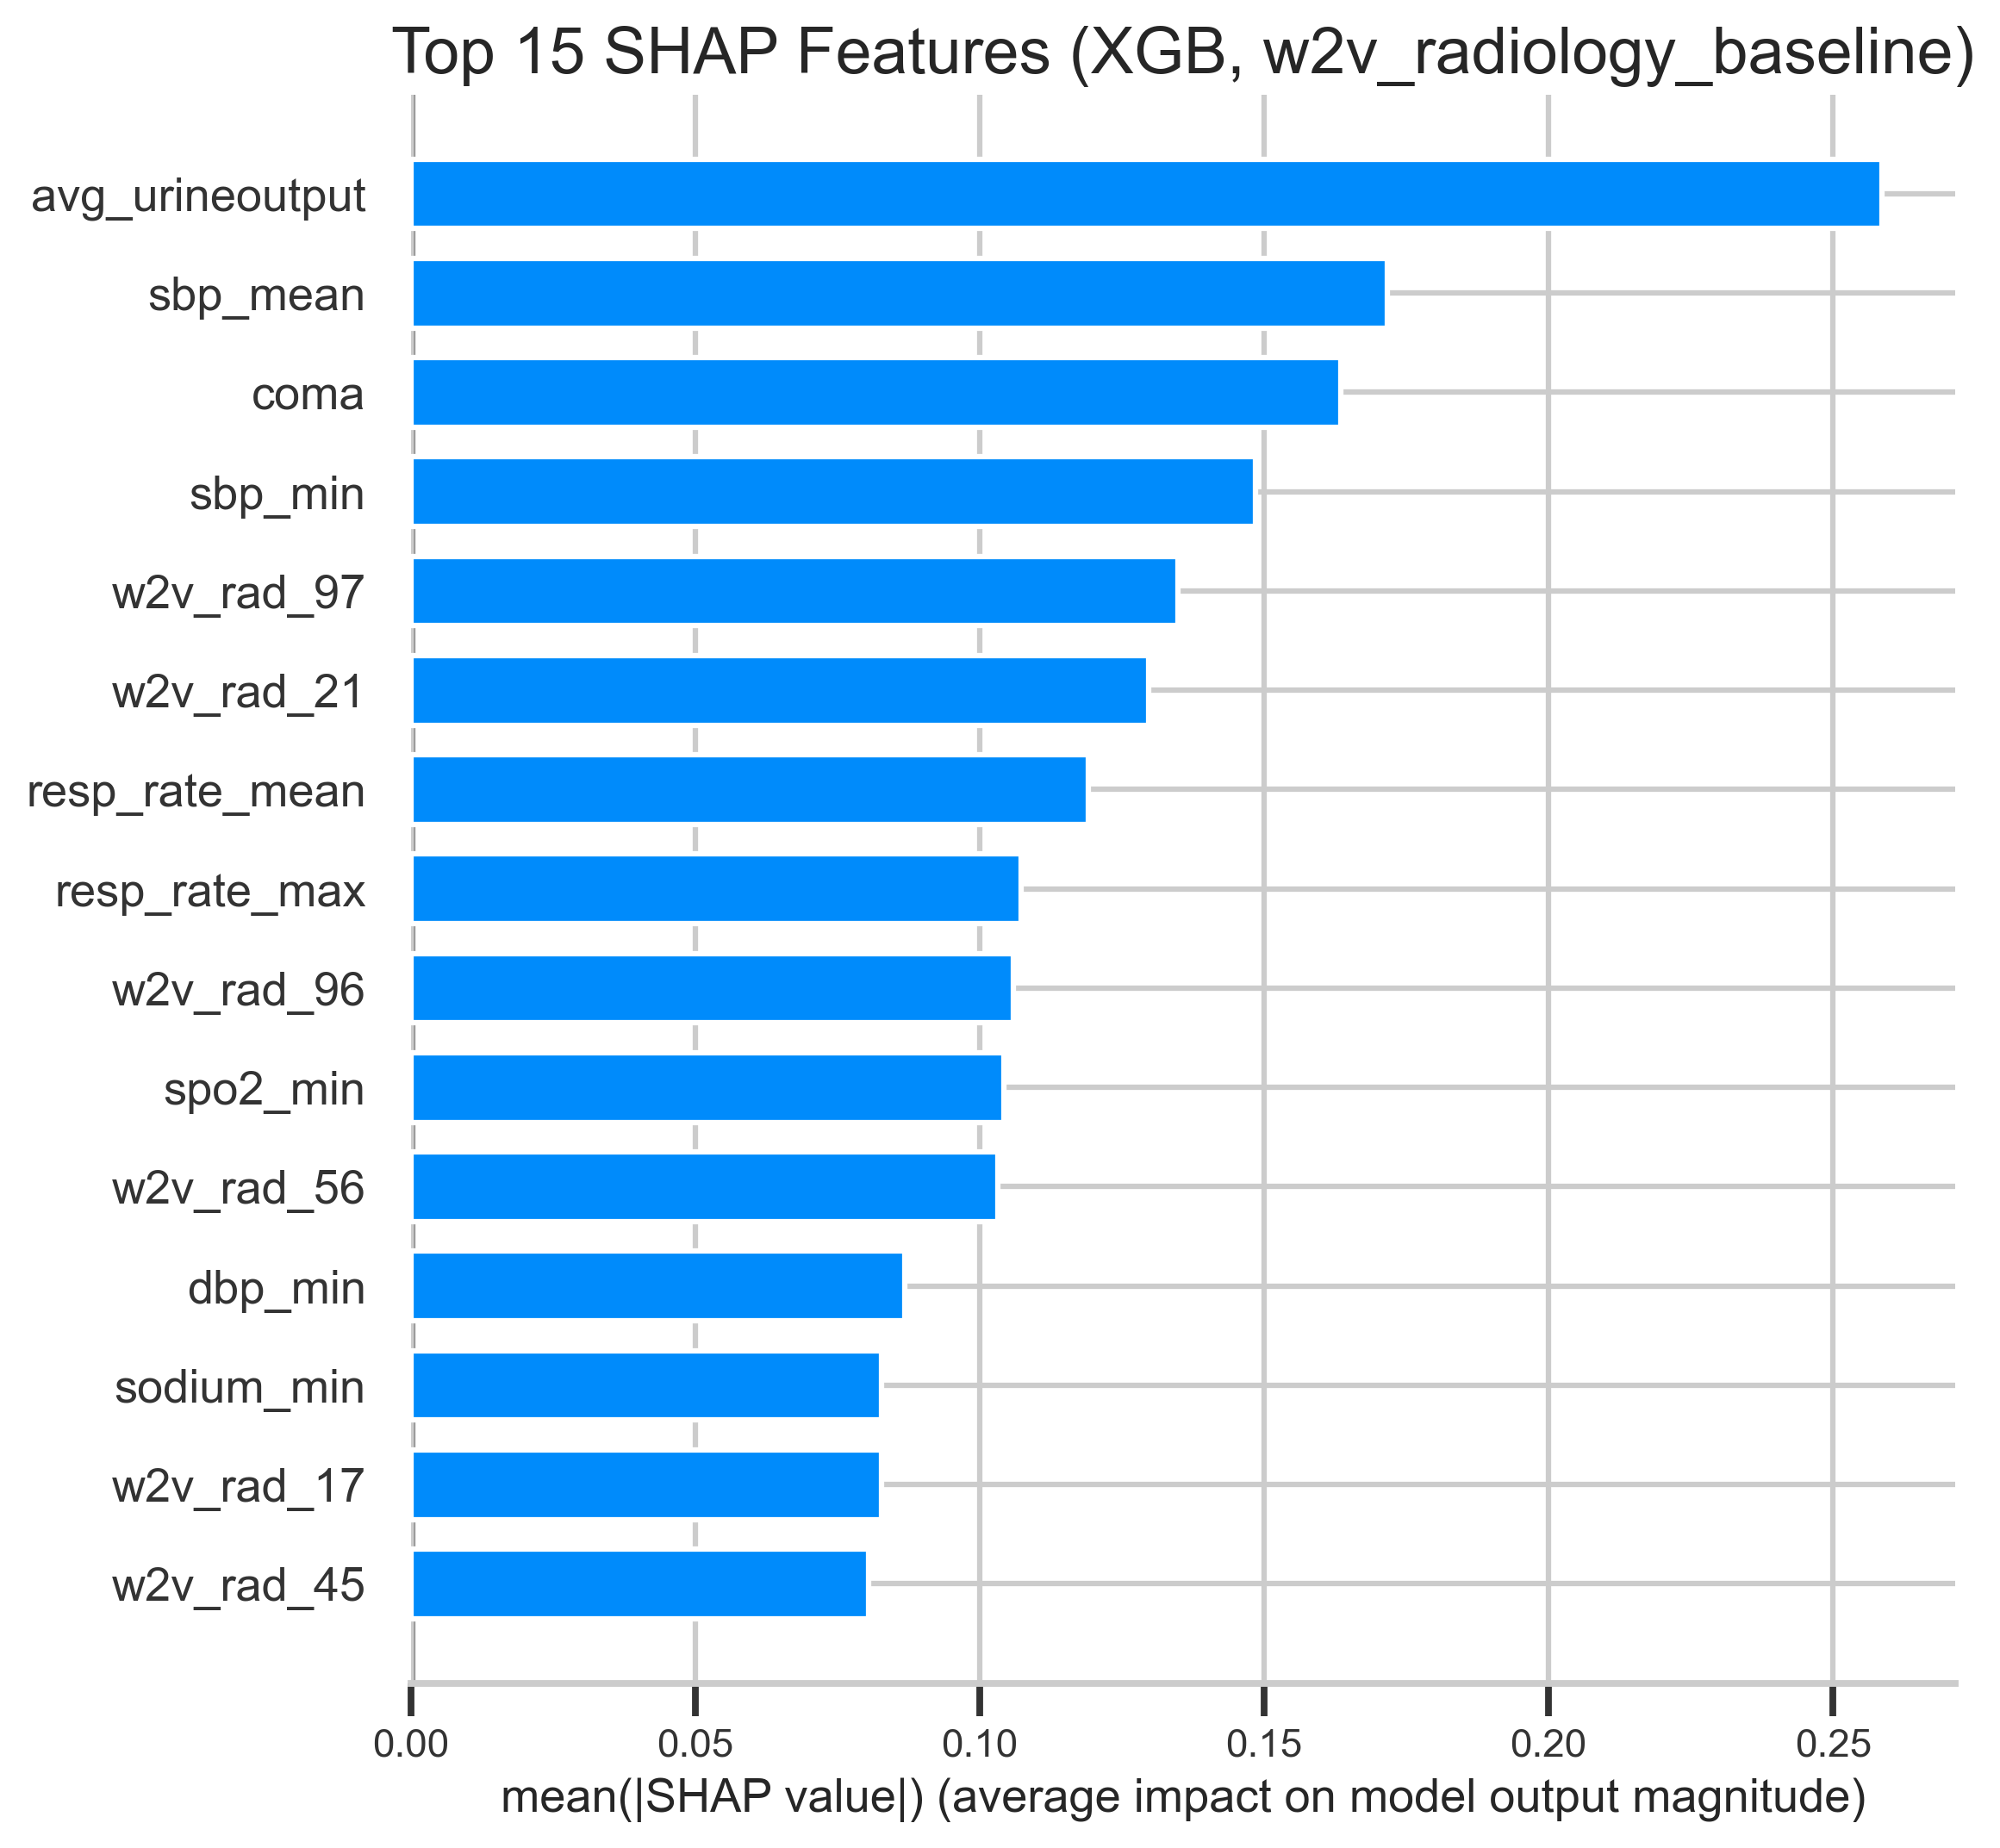

In [53]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_baseline/shap_summary_w2v_radiology_baseline_XGB.png")))

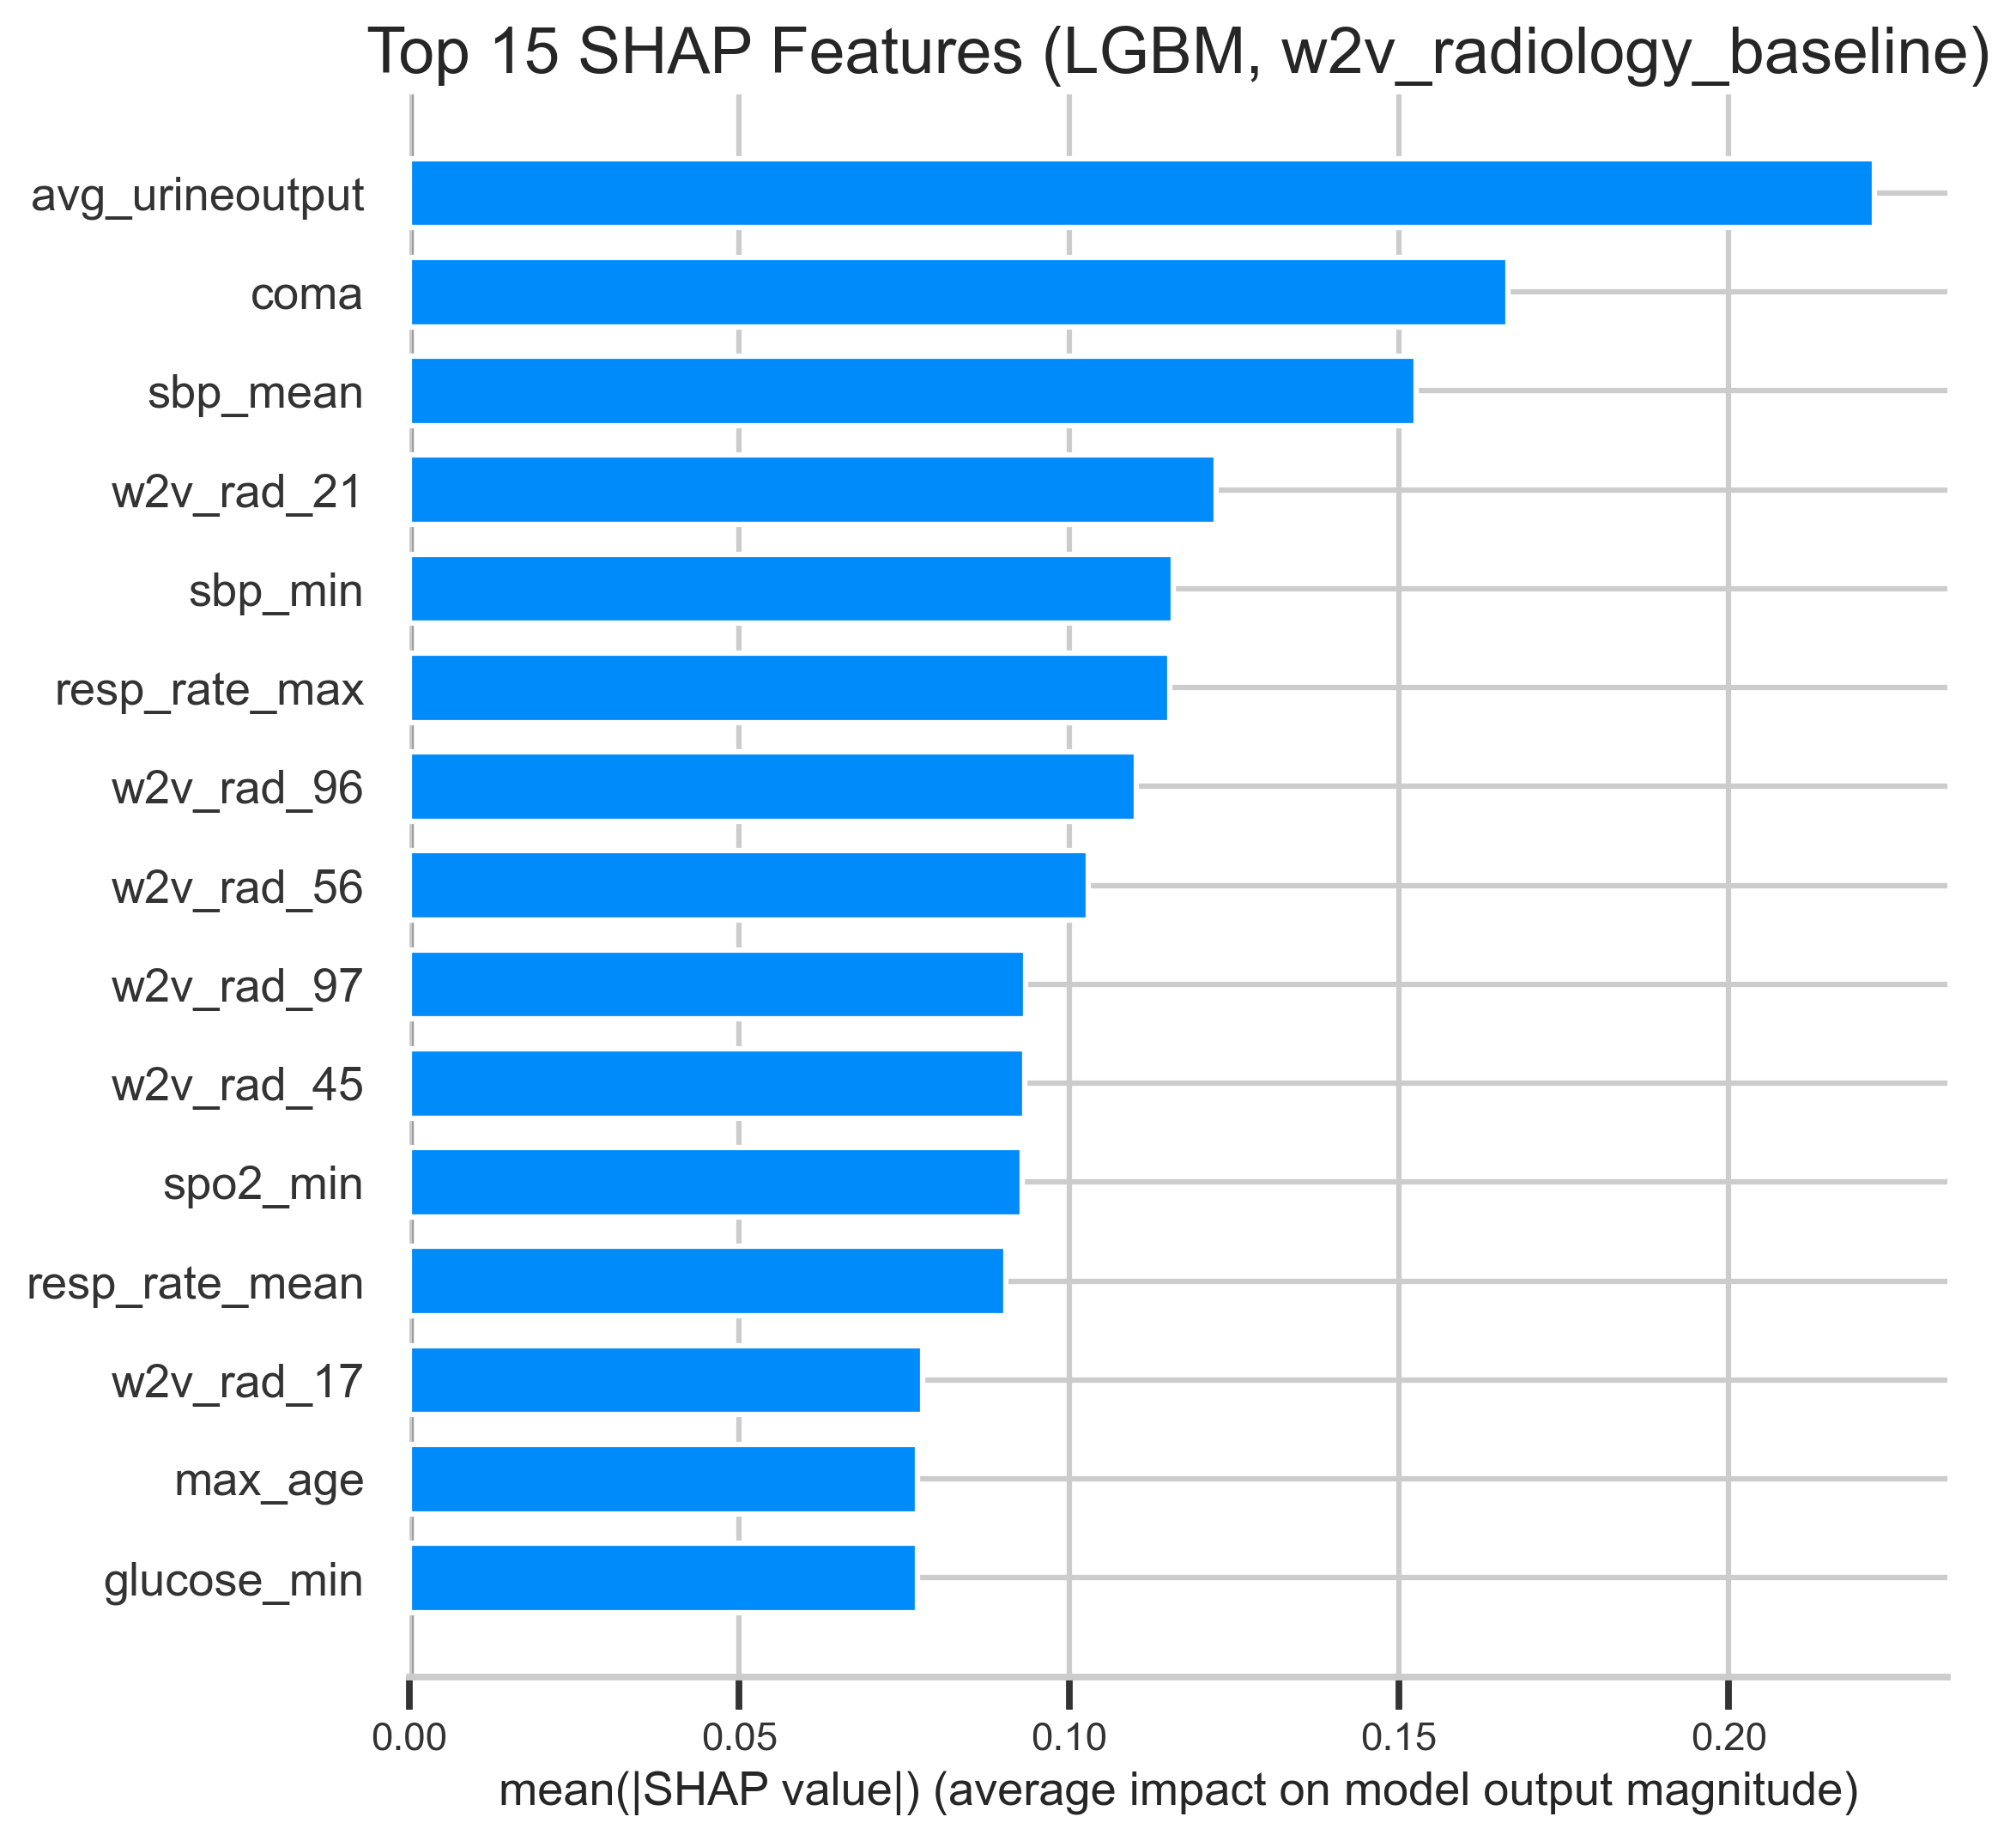

In [54]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_baseline/shap_summary_w2v_radiology_baseline_LGBM.png")))

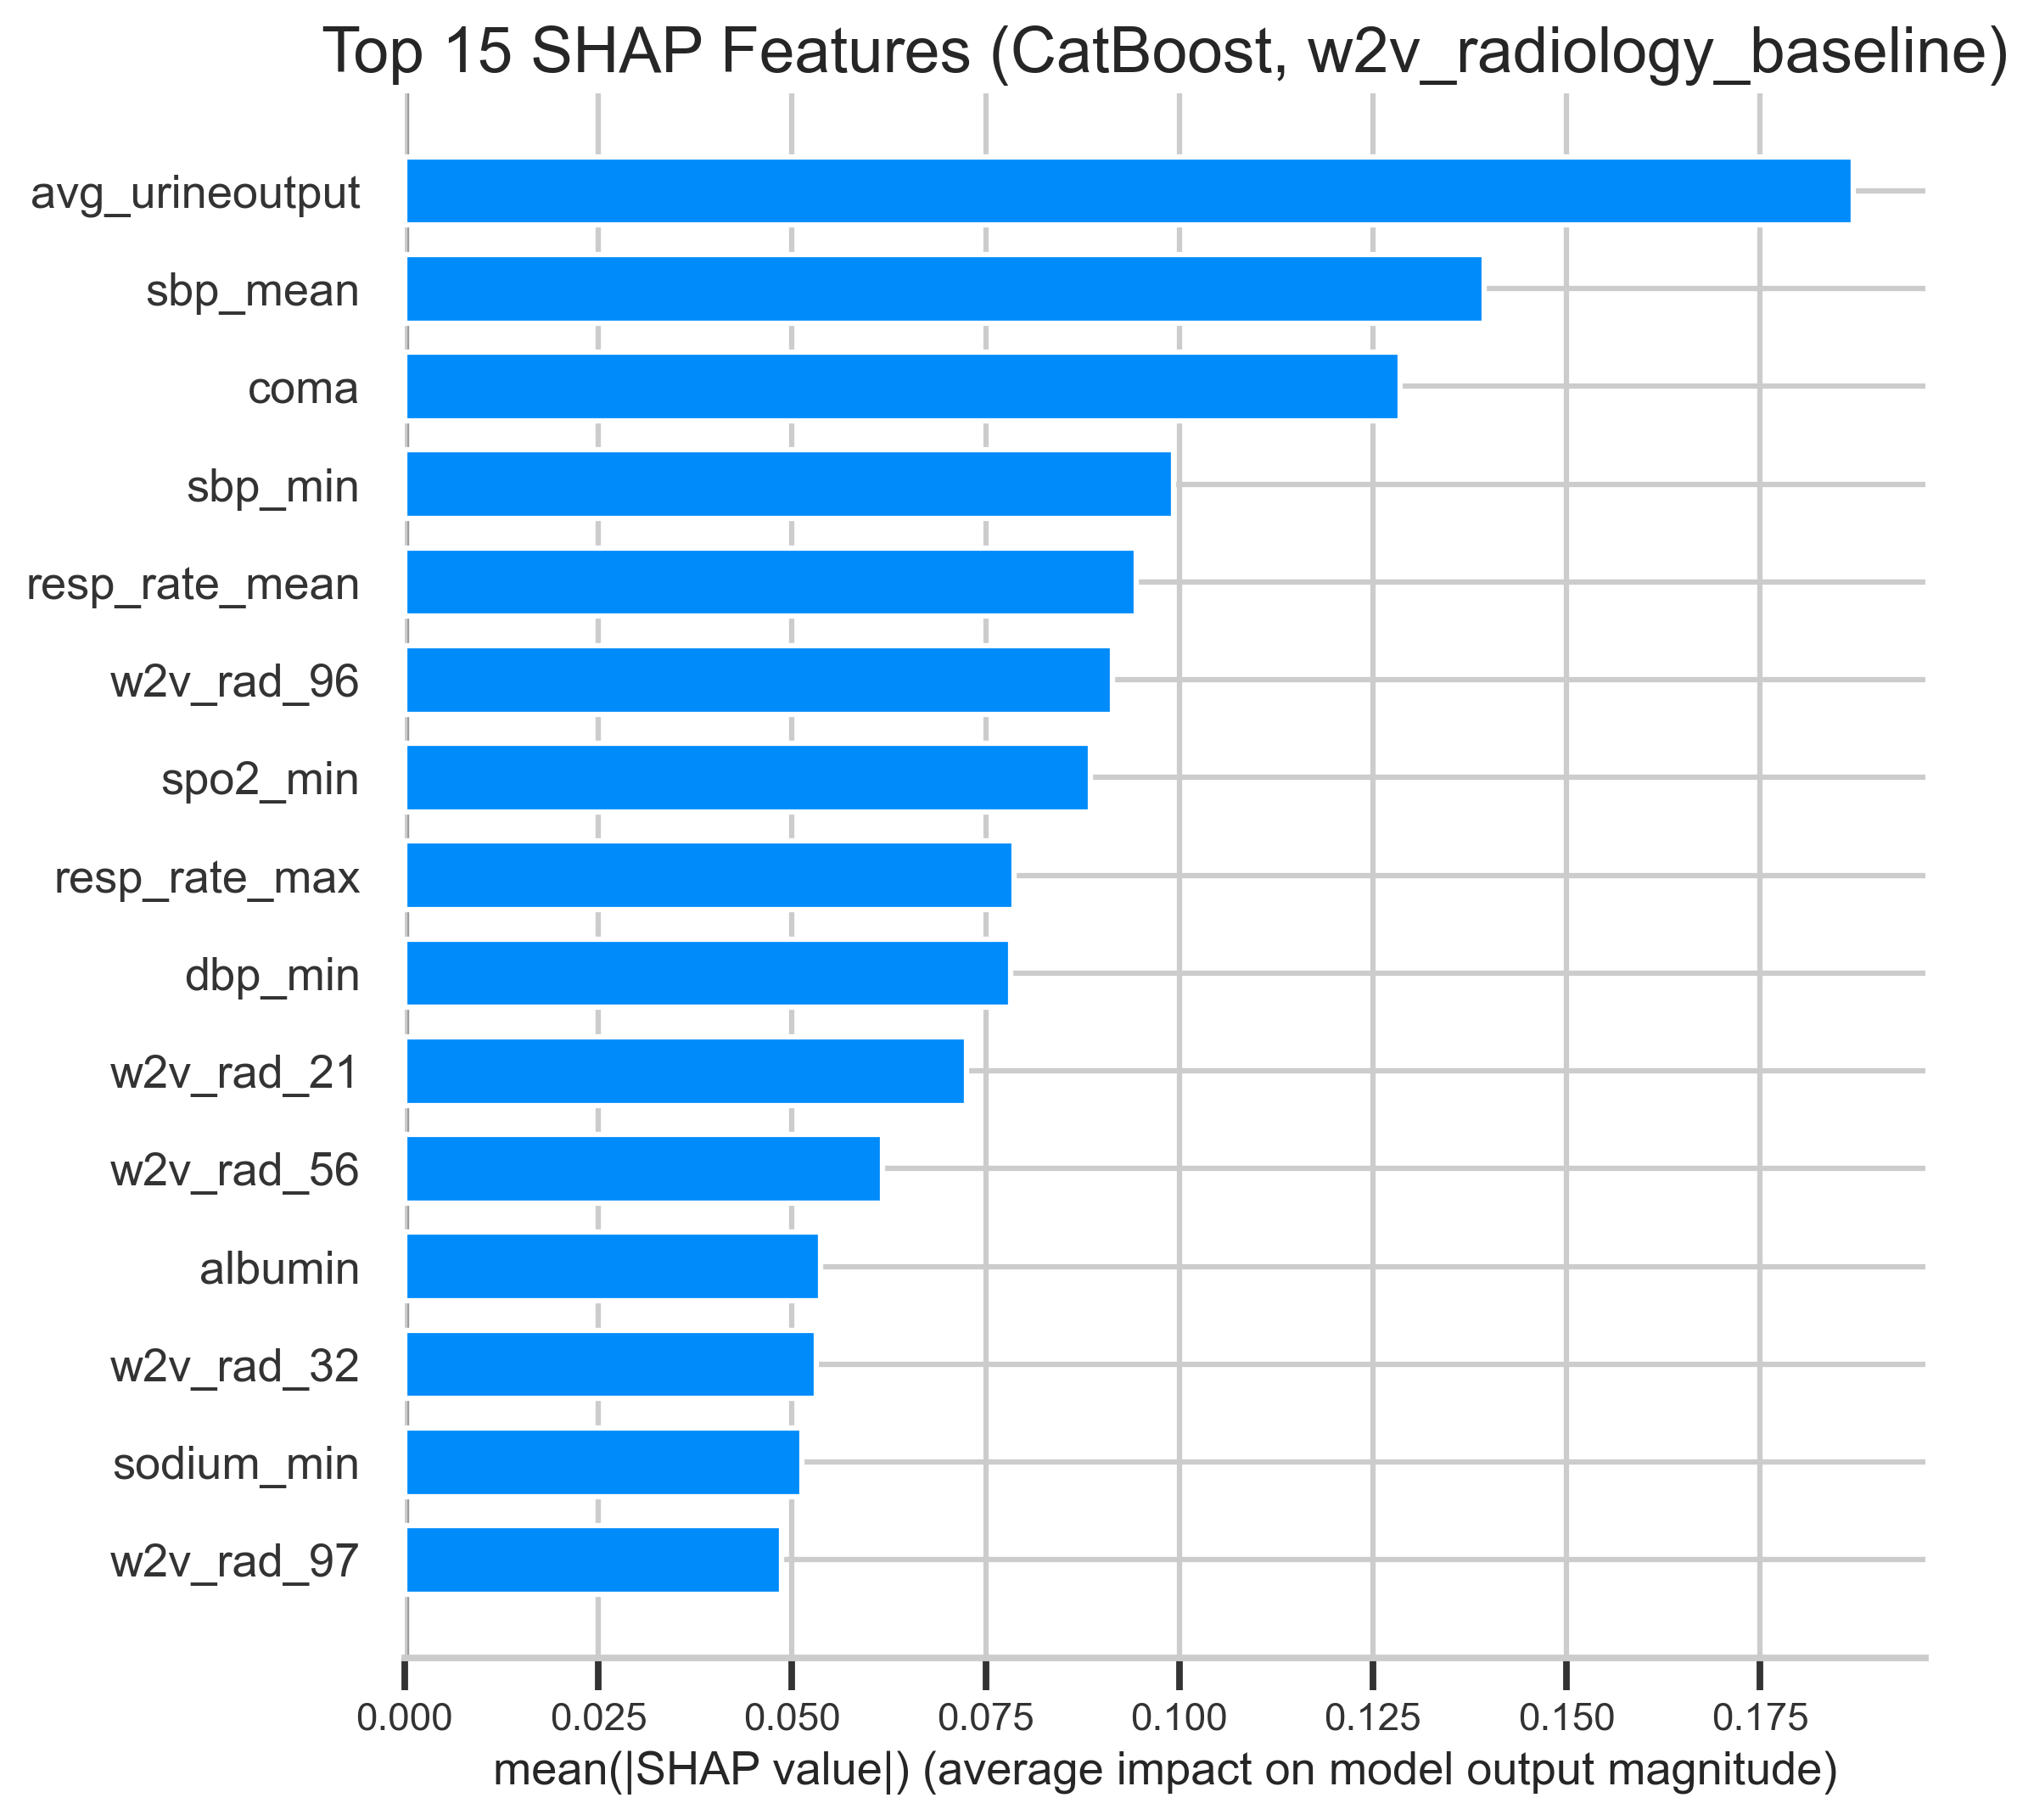

In [55]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_baseline/shap_summary_w2v_radiology_baseline_CatBoost.png")))

### Baseline Smote

In [56]:
for key, model in loaded_models_smote.items():
    # Example key: "w2v_radiology_smote_baseline_LogisticRegression"
    full_variant_smote, clf_name = key.rsplit("_", 1)

    # Map correct variant name (no regex confusion)
    if "w2v_radiology" in full_variant_smote:
        variant_lookup = "w2v_radiology"
    else:
        variant_lookup = "original"

    print(f"\n🔍 Explainability for {clf_name} ({full_variant_smote}) [lookup={variant_lookup}]")

    X_sample = X_samples.get(variant_lookup)
    if X_sample is None:
        print(f"⚠️ No sample data for {variant_lookup}, skipping.")
        continue

    # --- Safe unwrap for both pipelines and direct estimators ---
    if hasattr(model, "named_steps"):
        clf = model.named_steps.get("clf", model)
    else:
        clf = model

    # Create figure directory
    variant_fig_dir = resolve_path(f"results/figures/{full_variant_smote}/")
    variant_fig_dir.mkdir(parents=True, exist_ok=True)

    # ---------- Skip SVC (computationally heavy) ----------
    if clf_name == "SVC":
        print(f"ℹ️ Skipping explainability for {clf_name} (computationally expensive, low added value).")
        continue

    # ---------- Logistic Regression ----------
    if "LogisticRegression" in clf_name:
        coef = clf.coef_.ravel()
        features = getattr(model.named_steps.get("scaler", None), "feature_names_in_", None) \
                   if hasattr(model, "named_steps") else X_sample.columns
        if features is None:
            features = X_sample.columns

        importance_df = pd.DataFrame({"Feature": features, "Coefficient": coef})
        importance_df["AbsValue"] = importance_df["Coefficient"].abs()
        topn = importance_df.sort_values("AbsValue", ascending=False).head(15)

        plt.figure(figsize=(8,6))
        plt.barh(topn["Feature"][::-1], topn["Coefficient"][::-1], color="steelblue")
        plt.xlabel("Coefficient Value")
        plt.title(f"Top 15 Coefficients ({clf_name}, {full_variant_smote})")
        plt.tight_layout()
        save_coef = variant_fig_dir / f"coefficients_{full_variant_smote}_{clf_name}.png"
        plt.savefig(save_coef, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"📊 Saved coefficient plot → {save_coef}")
        continue

    # ---------- SHAP Explainability ----------
    try:
        X_bg = X_sample.sample(n=min(800, len(X_sample)), random_state=42)

        # Prefer TreeExplainer for trees
        if hasattr(clf, "get_booster") or hasattr(clf, "feature_importances_"):
            try:
                explainer = shap.TreeExplainer(clf, X_bg, feature_perturbation="interventional")
                shap_values = explainer(X_sample, check_additivity=False)
            except Exception:
                explainer = shap.Explainer(clf.predict, X_bg)
                shap_values = explainer(X_sample)
        else:
            # Non-tree models
            if hasattr(clf, "predict_proba"):
                explainer = shap.Explainer(clf.predict_proba, X_bg)
            elif hasattr(clf, "decision_function"):
                explainer = shap.Explainer(clf.decision_function, X_bg)
            else:
                print(f"⚠️ No callable probability or decision function for {clf_name}, skipping.")
                continue
            shap_values = explainer(X_sample)

        # Summary Plot
        shap.summary_plot(shap_values, X_sample, show=False, plot_type="bar", max_display=15)
        save_bar = variant_fig_dir / f"shap_summary_{full_variant_smote}_{clf_name}.png"
        plt.title(f"Top 15 SHAP Features ({clf_name}, {full_variant_smote})")
        plt.tight_layout()
        plt.savefig(save_bar, dpi=300, bbox_inches="tight")
        plt.close()
        print(f"📊 Saved SHAP summary → {save_bar}")

        # ---------- Dependence Plot (Robust + Fallback) ----------
        try:
            # Handle RandomForest / DecisionTree explicitly
            if isinstance(clf, (DecisionTreeClassifier, RandomForestClassifier)):
                vals = shap_values.values
                if isinstance(vals, list):
                    vals = vals[1] if len(vals) > 1 else vals[0]
                elif vals.ndim == 3:
                    vals = vals[:, :, 1]
                else:
                    vals = np.array(vals)

                if vals.ndim != 2 or vals.shape[1] != X_sample.shape[1]:
                    raise ValueError("Tree-based SHAP mismatch, falling back to permutation importance.")

                abs_mean = np.abs(vals).mean(0)
                top_feature = X_sample.columns[abs_mean.argmax()]
                shap.dependence_plot(top_feature, vals, X_sample, show=False)
                save_dep = variant_fig_dir / f"shap_dependence_{full_variant_smote}_{clf_name}_{top_feature}.png"
                plt.title(f"Dependence: {top_feature} ({clf_name}, {full_variant_smote})")
                plt.tight_layout()
                plt.savefig(save_dep, dpi=300, bbox_inches="tight")
                plt.close()
                print(f"📈 Saved dependence plot → {save_dep}")

            else:
                vals = getattr(shap_values, "values", shap_values)
                if vals is None or np.ndim(vals) != 2:
                    raise ValueError("Invalid SHAP output shape for dependence plot.")

                abs_mean = np.abs(vals).mean(0)
                top_feature = X_sample.columns[abs_mean.argmax()]
                shap.dependence_plot(top_feature, vals, X_sample, show=False)
                save_dep = variant_fig_dir / f"shap_dependence_{full_variant_smote}_{clf_name}_{top_feature}.png"
                plt.title(f"Dependence: {top_feature} ({clf_name}, {full_variant_smote})")
                plt.tight_layout()
                plt.savefig(save_dep, dpi=300, bbox_inches="tight")
                plt.close()
                print(f"📈 Saved dependence plot → {save_dep}")

        except Exception as e:
            # Permutation Importance fallback
            print(f"⚠️ Dependence SHAP failed for {clf_name} ({full_variant_smote}): {e}")
            try:
                result = permutation_importance(
                    clf, X_sample, y_tests[variant_lookup],
                    n_repeats=10, random_state=42
                )
                importances = pd.Series(result.importances_mean, index=X_sample.columns)
                top_imp = importances.sort_values(ascending=False).head(15)

                plt.figure(figsize=(8,6))
                plt.barh(top_imp.index[::-1], top_imp.values[::-1], color="darkorange")
                plt.title(f"Top 15 Permutation Importances ({clf_name}, {full_variant_smote})")
                plt.xlabel("Mean Importance (Δ Accuracy)")
                plt.tight_layout()
                save_perm = variant_fig_dir / f"perm_importance_{full_variant_smote}_{clf_name}.png"
                plt.savefig(save_perm, dpi=300, bbox_inches="tight")
                plt.close()
                print(f"🪄 Fallback: saved permutation importance plot → {save_perm}")
            except Exception as e2:
                print(f"⚠️ Dependence skipped for {clf_name} ({full_variant_smote}): {e2}")

    except Exception as e:
        print(f"⚠️ SHAP failed for {clf_name} ({full_variant_smote}): {e}")


🔍 Explainability for best (original_smote_baseline) [lookup=original]


 95%|=================== | 985/1042 [00:13<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_best.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_dependence_original_smote_baseline_best_avg_urineoutput.png

🔍 Explainability for CatBoost (original_smote_baseline) [lookup=original]


 95%|=================== | 994/1042 [00:13<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_CatBoost.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_dependence_original_smote_baseline_CatBoost_avg_urineoutput.png

🔍 Explainability for DecisionTree (original_smote_baseline) [lookup=original]
📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_DecisionTree.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_dependence_original_smote_baseline_DecisionTree_sbp_min.png

🔍 Explainability for GradientBoosting (original_smote_baseline) [lookup=original]
📊 Save

100%|===================| 1040/1042 [00:40<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_LGBM.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_dependence_original_smote_baseline_LGBM_avg_urineoutput.png

🔍 Explainability for LogisticRegression (original_smote_baseline) [lookup=original]
📊 Saved coefficient plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\coefficients_original_smote_baseline_LogisticRegression.png

🔍 Explainability for MLP (original_smote_baseline) [lookup=original]


PermutationExplainer explainer: 1043it [00:35, 20.94it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_MLP.png
⚠️ Dependence SHAP failed for MLP (original_smote_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\perm_importance_original_smote_baseline_MLP.png

🔍 Explainability for NaiveBayes (original_smote_baseline) [lookup=original]


PermutationExplainer explainer: 1043it [00:52, 15.93it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_NaiveBayes.png
⚠️ Dependence SHAP failed for NaiveBayes (original_smote_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\perm_importance_original_smote_baseline_NaiveBayes.png

🔍 Explainability for RandomForest (original_smote_baseline) [lookup=original]


100%|===================| 2078/2084 [04:29<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_RandomForest.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_dependence_original_smote_baseline_RandomForest_sbp_min.png

🔍 Explainability for SVC (original_smote_baseline) [lookup=original]
ℹ️ Skipping explainability for SVC (computationally expensive, low added value).

🔍 Explainability for XGB (original_smote_baseline) [lookup=original]


 98%|===================| 1025/1042 [00:14<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_summary_original_smote_baseline_XGB.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\shap_dependence_original_smote_baseline_XGB_spo2_min.png

🔍 Explainability for best (w2v_radiology_smote_baseline) [lookup=w2v_radiology]


PermutationExplainer explainer: 1043it [00:49, 16.83it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_best.png
⚠️ Dependence SHAP failed for best (w2v_radiology_smote_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\perm_importance_w2v_radiology_smote_baseline_best.png

🔍 Explainability for CatBoost (w2v_radiology_smote_baseline) [lookup=w2v_radiology]


100%|===================| 1038/1042 [00:40<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_CatBoost.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_dependence_w2v_radiology_smote_baseline_CatBoost_avg_urineoutput.png

🔍 Explainability for DecisionTree (w2v_radiology_smote_baseline) [lookup=w2v_radiology]
📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_DecisionTree.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_dependence_w2v_radiology_smote_baseline_DecisionTree_sbp_min.png

🔍 Explainability for GradientBoosting 

100%|===================| 1041/1042 [00:42<00:00]       

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_LGBM.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_dependence_w2v_radiology_smote_baseline_LGBM_avg_urineoutput.png

🔍 Explainability for LogisticRegression (w2v_radiology_smote_baseline) [lookup=w2v_radiology]
📊 Saved coefficient plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\coefficients_w2v_radiology_smote_baseline_LogisticRegression.png

🔍 Explainability for MLP (w2v_radiology_smote_baseline) [lookup=w2v_radiology]


PermutationExplainer explainer: 1043it [01:06, 13.33it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_MLP.png
⚠️ Dependence SHAP failed for MLP (w2v_radiology_smote_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\perm_importance_w2v_radiology_smote_baseline_MLP.png

🔍 Explainability for NaiveBayes (w2v_radiology_smote_baseline) [lookup=w2v_radiology]


PermutationExplainer explainer: 1043it [02:36,  6.24it/s]                                                              


📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_NaiveBayes.png
⚠️ Dependence SHAP failed for NaiveBayes (w2v_radiology_smote_baseline): Invalid SHAP output shape for dependence plot.
🪄 Fallback: saved permutation importance plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\perm_importance_w2v_radiology_smote_baseline_NaiveBayes.png

🔍 Explainability for RandomForest (w2v_radiology_smote_baseline) [lookup=w2v_radiology]


 99%|===================| 2070/2084 [01:36<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_RandomForest.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_dependence_w2v_radiology_smote_baseline_RandomForest_sofa_score.png

🔍 Explainability for SVC (w2v_radiology_smote_baseline) [lookup=w2v_radiology]
ℹ️ Skipping explainability for SVC (computationally expensive, low added value).

🔍 Explainability for XGB (w2v_radiology_smote_baseline) [lookup=w2v_radiology]


 99%|===================| 1031/1042 [01:04<00:00]        

📊 Saved SHAP summary → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_summary_w2v_radiology_smote_baseline_XGB.png
📈 Saved dependence plot → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\w2v_radiology_smote_baseline\shap_dependence_w2v_radiology_smote_baseline_XGB_avg_urineoutput.png


### Baseline Smote

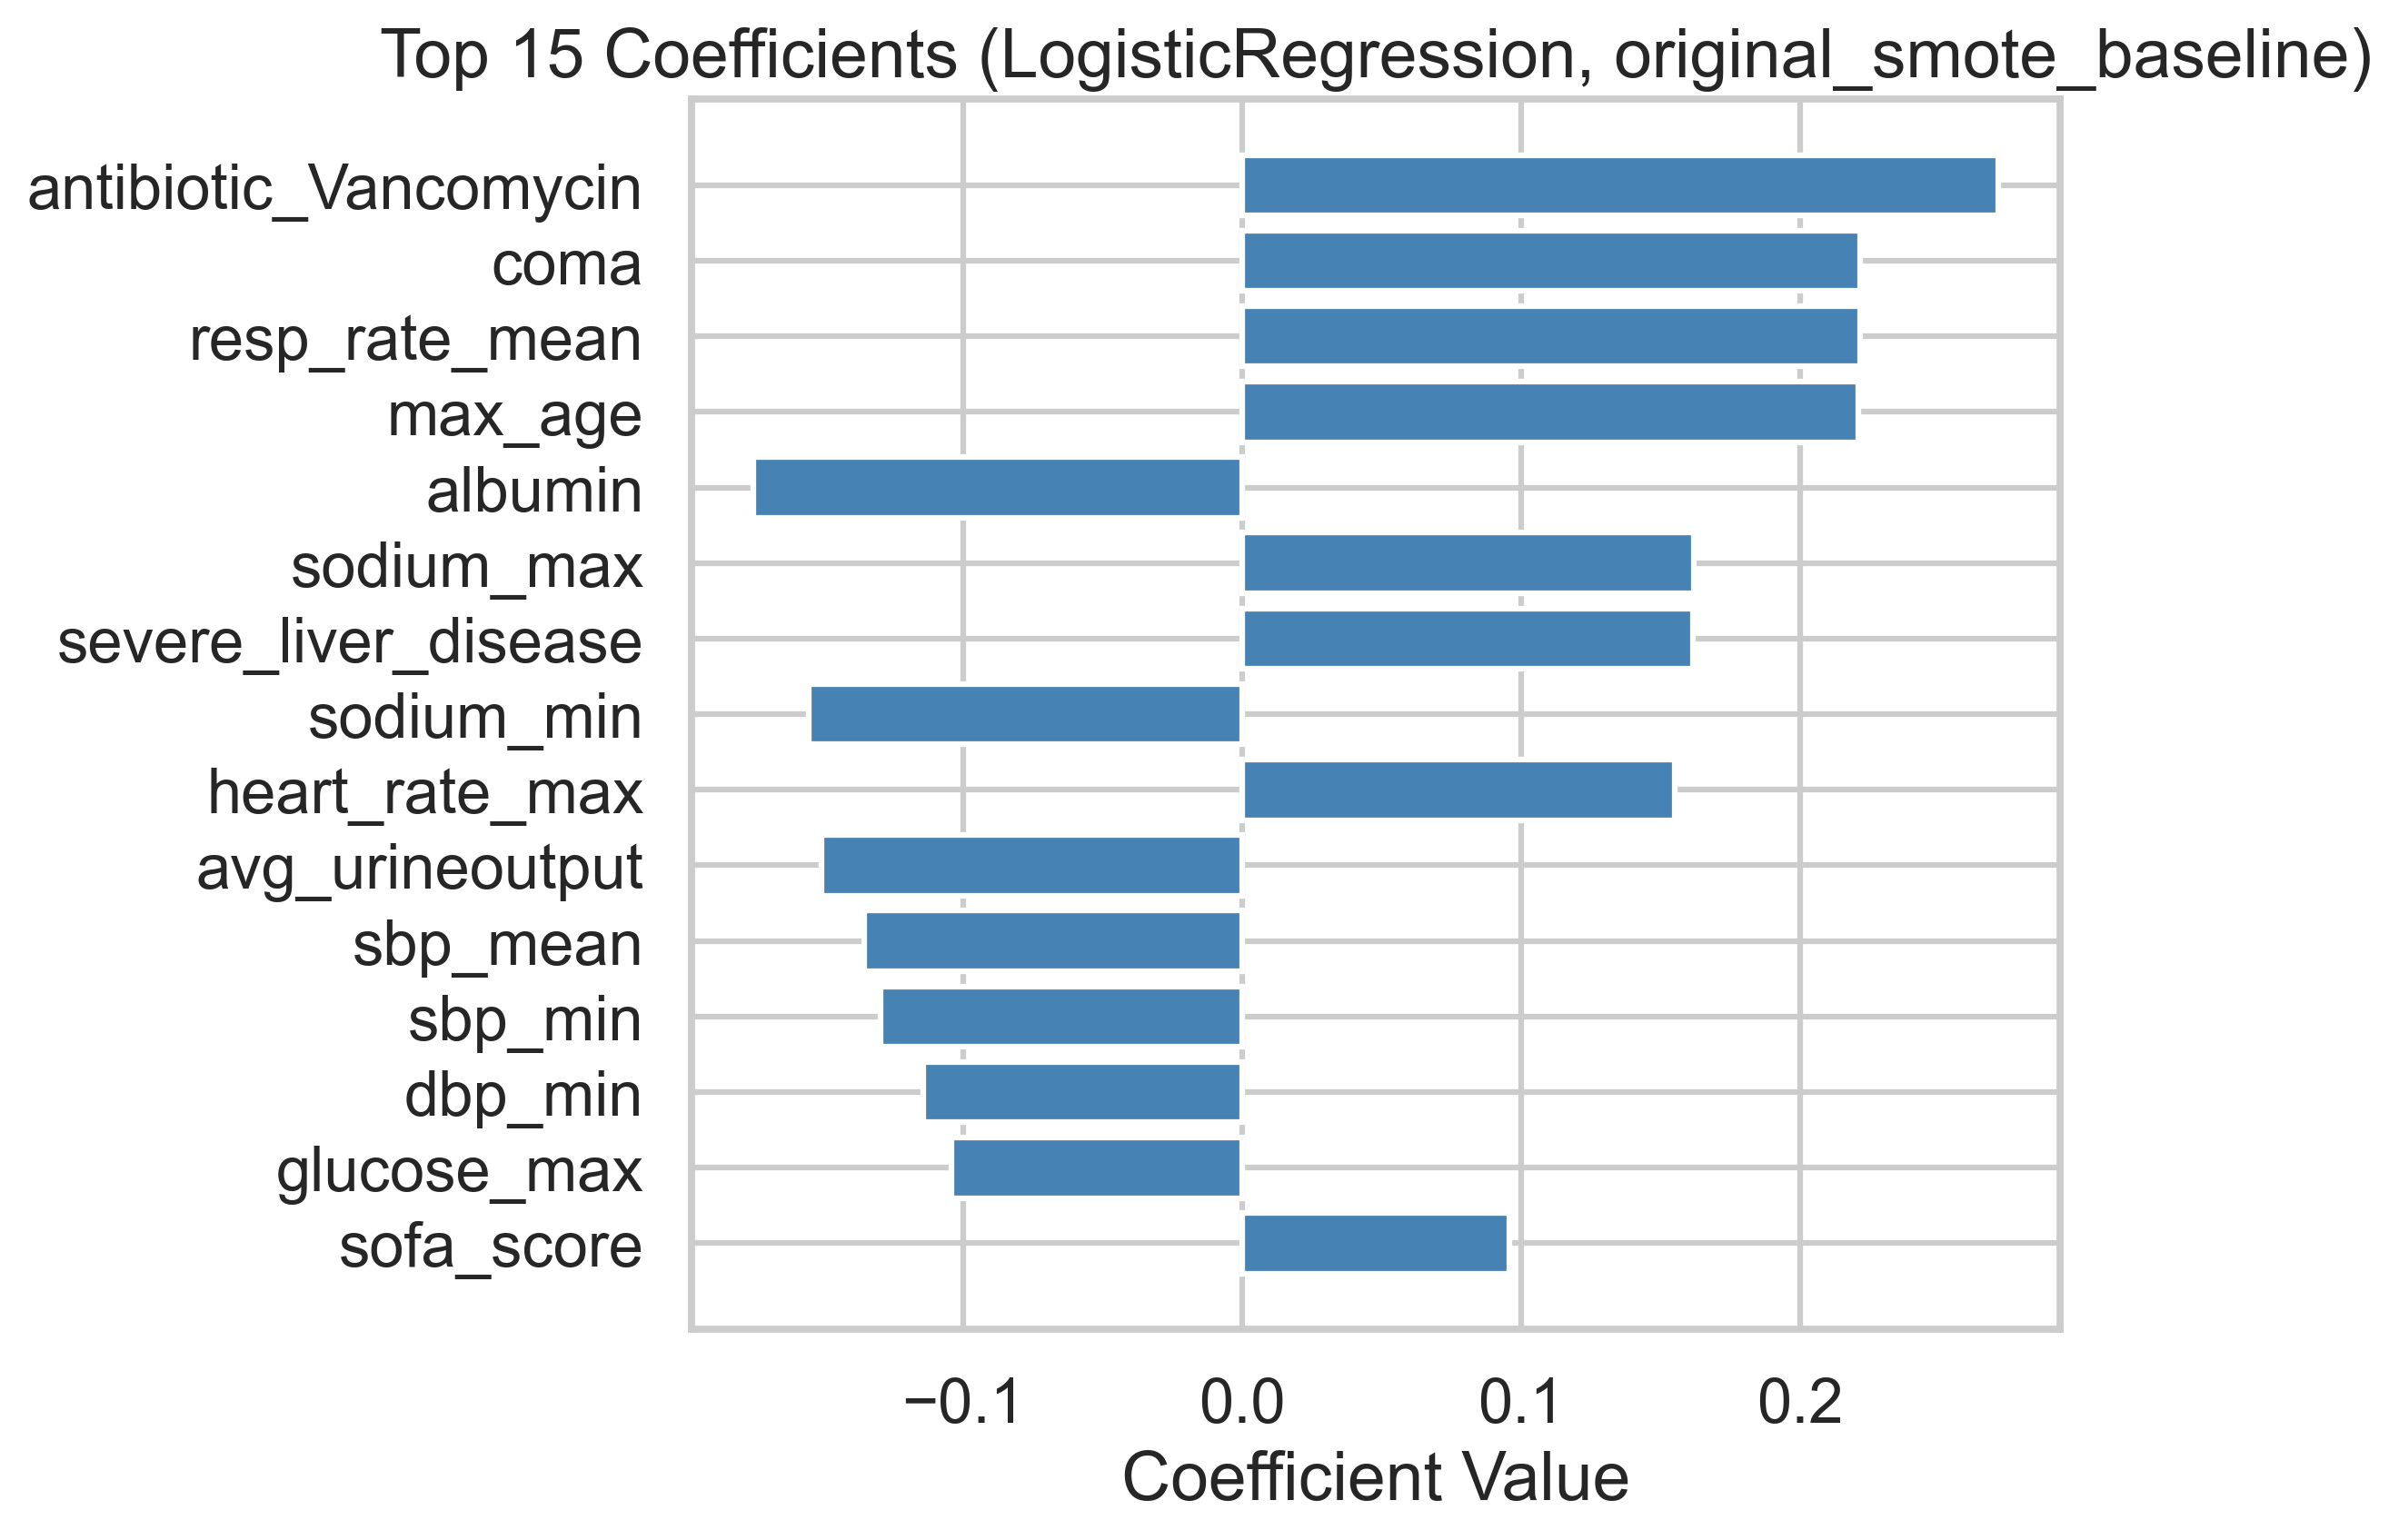

In [57]:
display(Image(filename=resolve_path("results/figures/original_smote_baseline/coefficients_original_smote_baseline_LogisticRegression.png")))

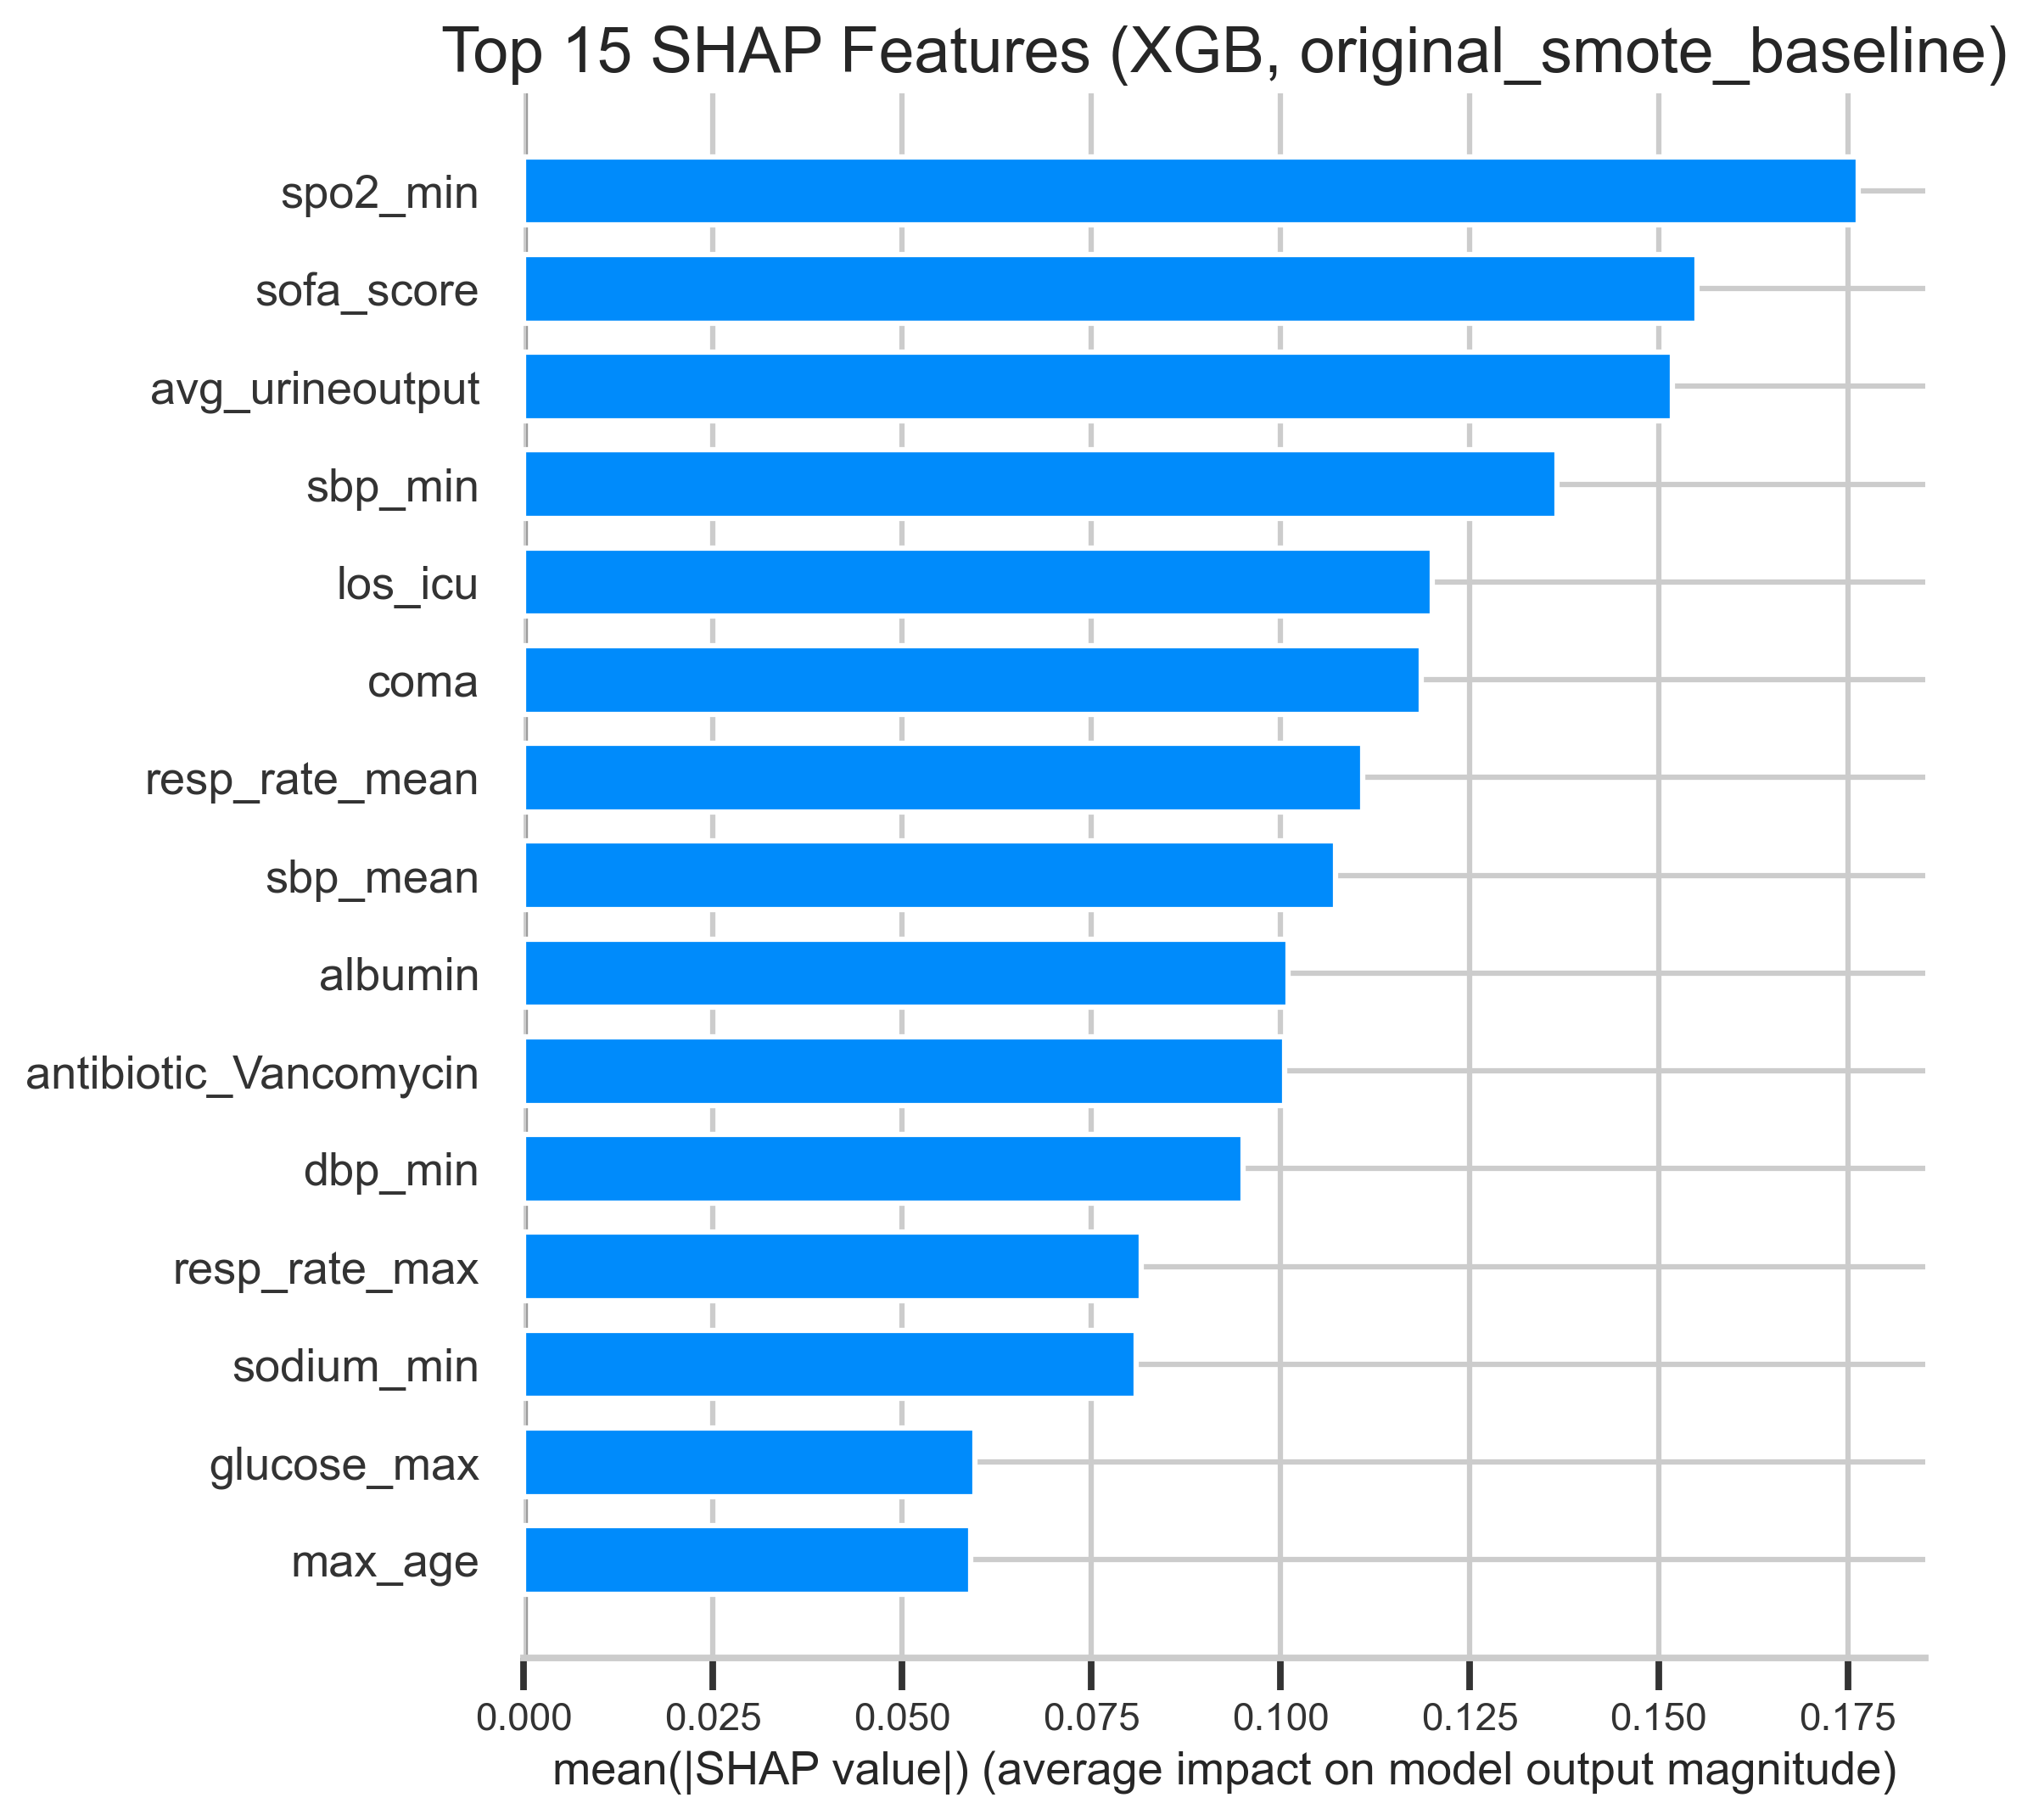

In [58]:
display(Image(filename=resolve_path("results/figures/original_smote_baseline/shap_summary_original_smote_baseline_XGB.png")))

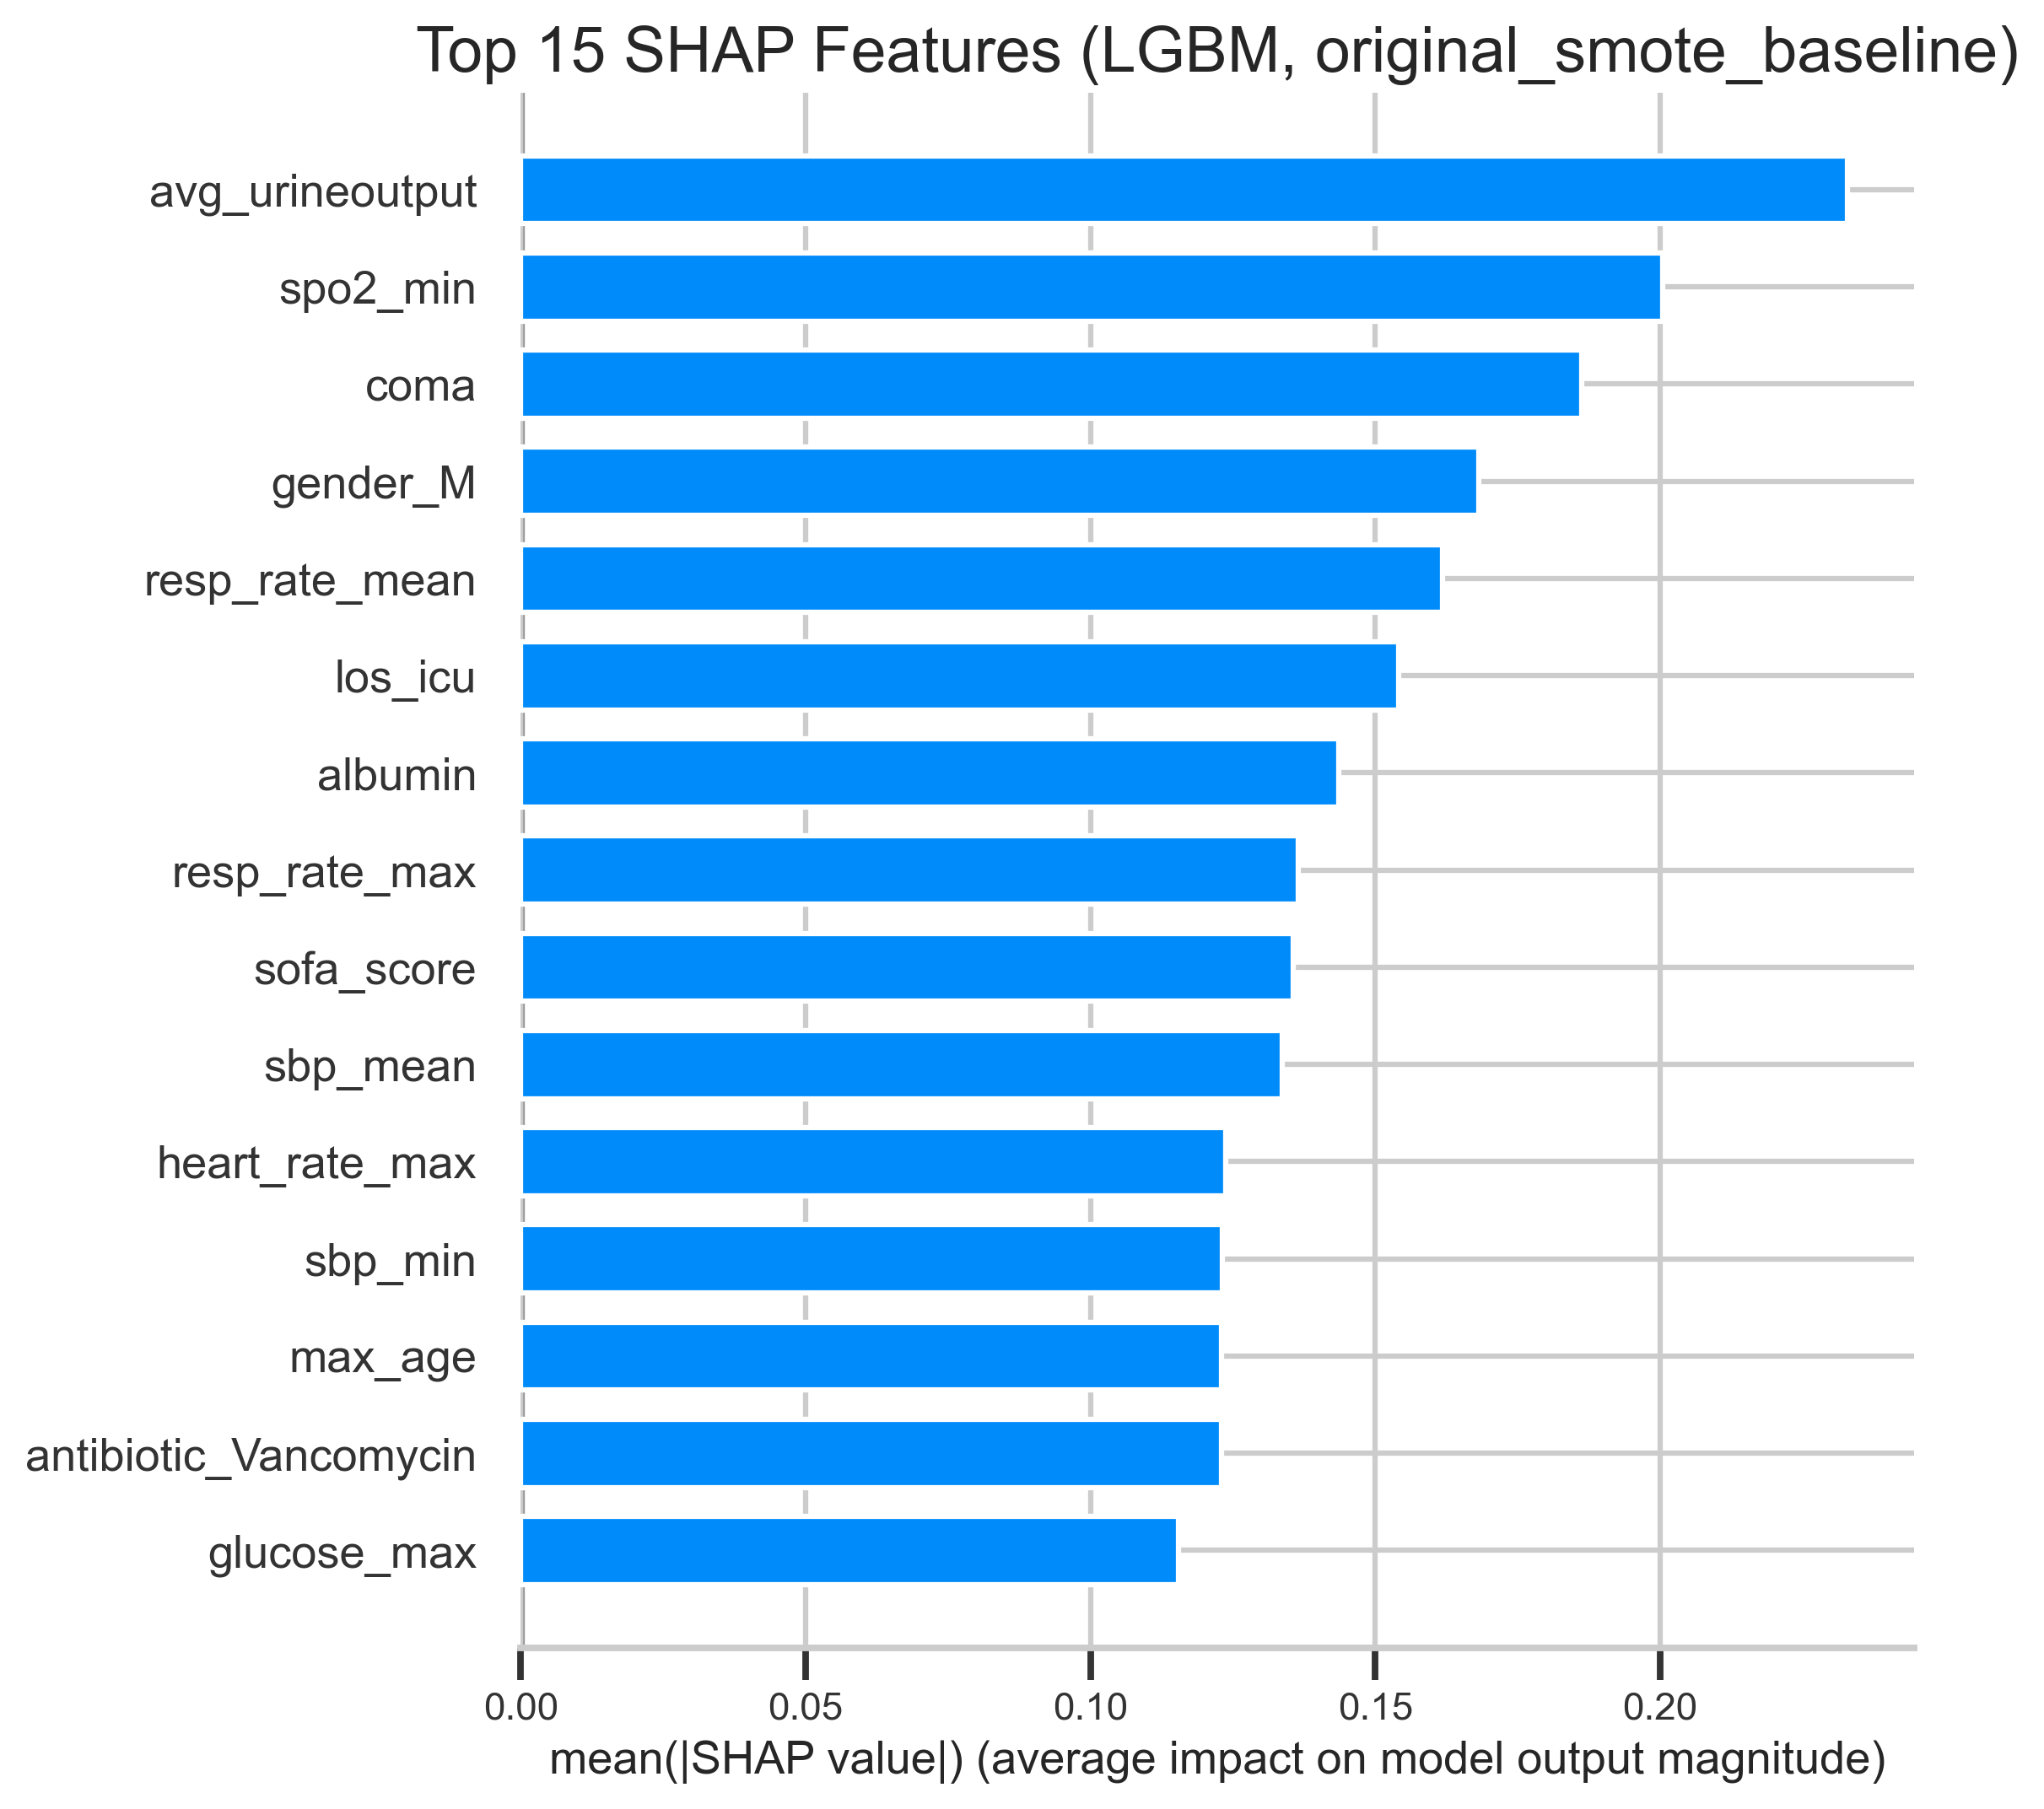

In [59]:
display(Image(filename=resolve_path("results/figures/original_smote_baseline/shap_summary_original_smote_baseline_LGBM.png")))

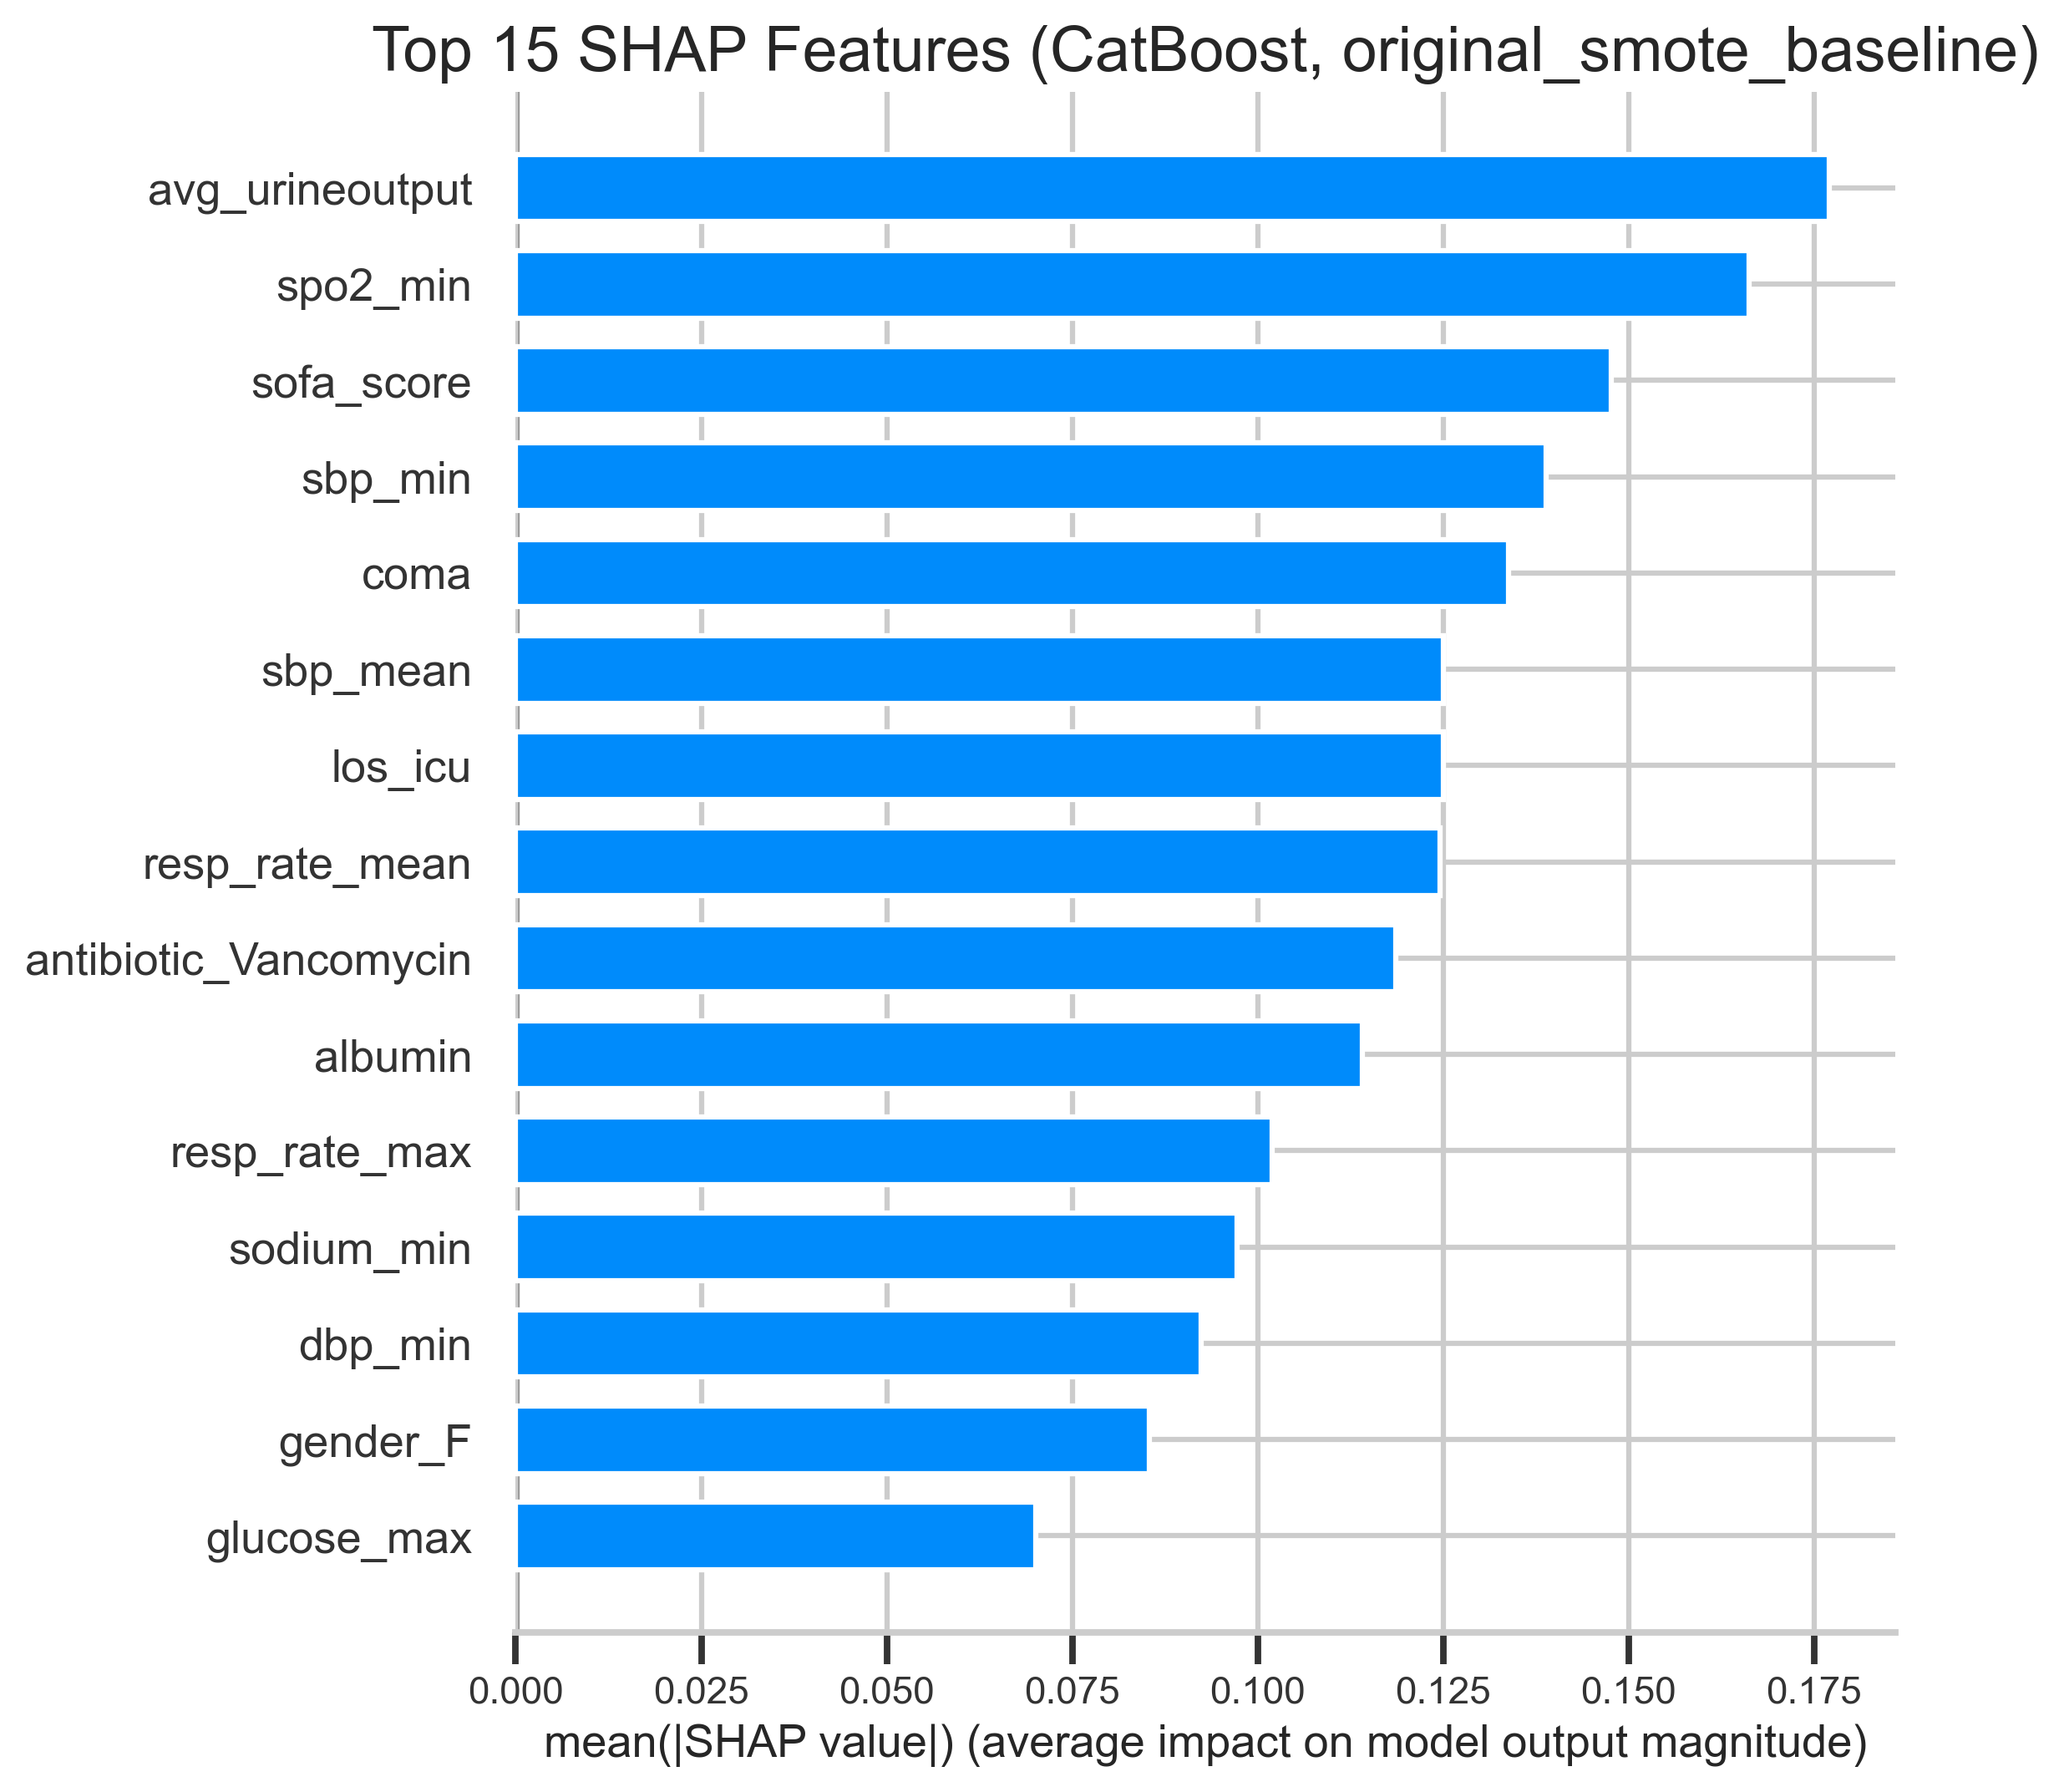

In [60]:
display(Image(filename=resolve_path("results/figures/original_smote_baseline/shap_summary_original_smote_baseline_CatBoost.png")))

### W2V Smote

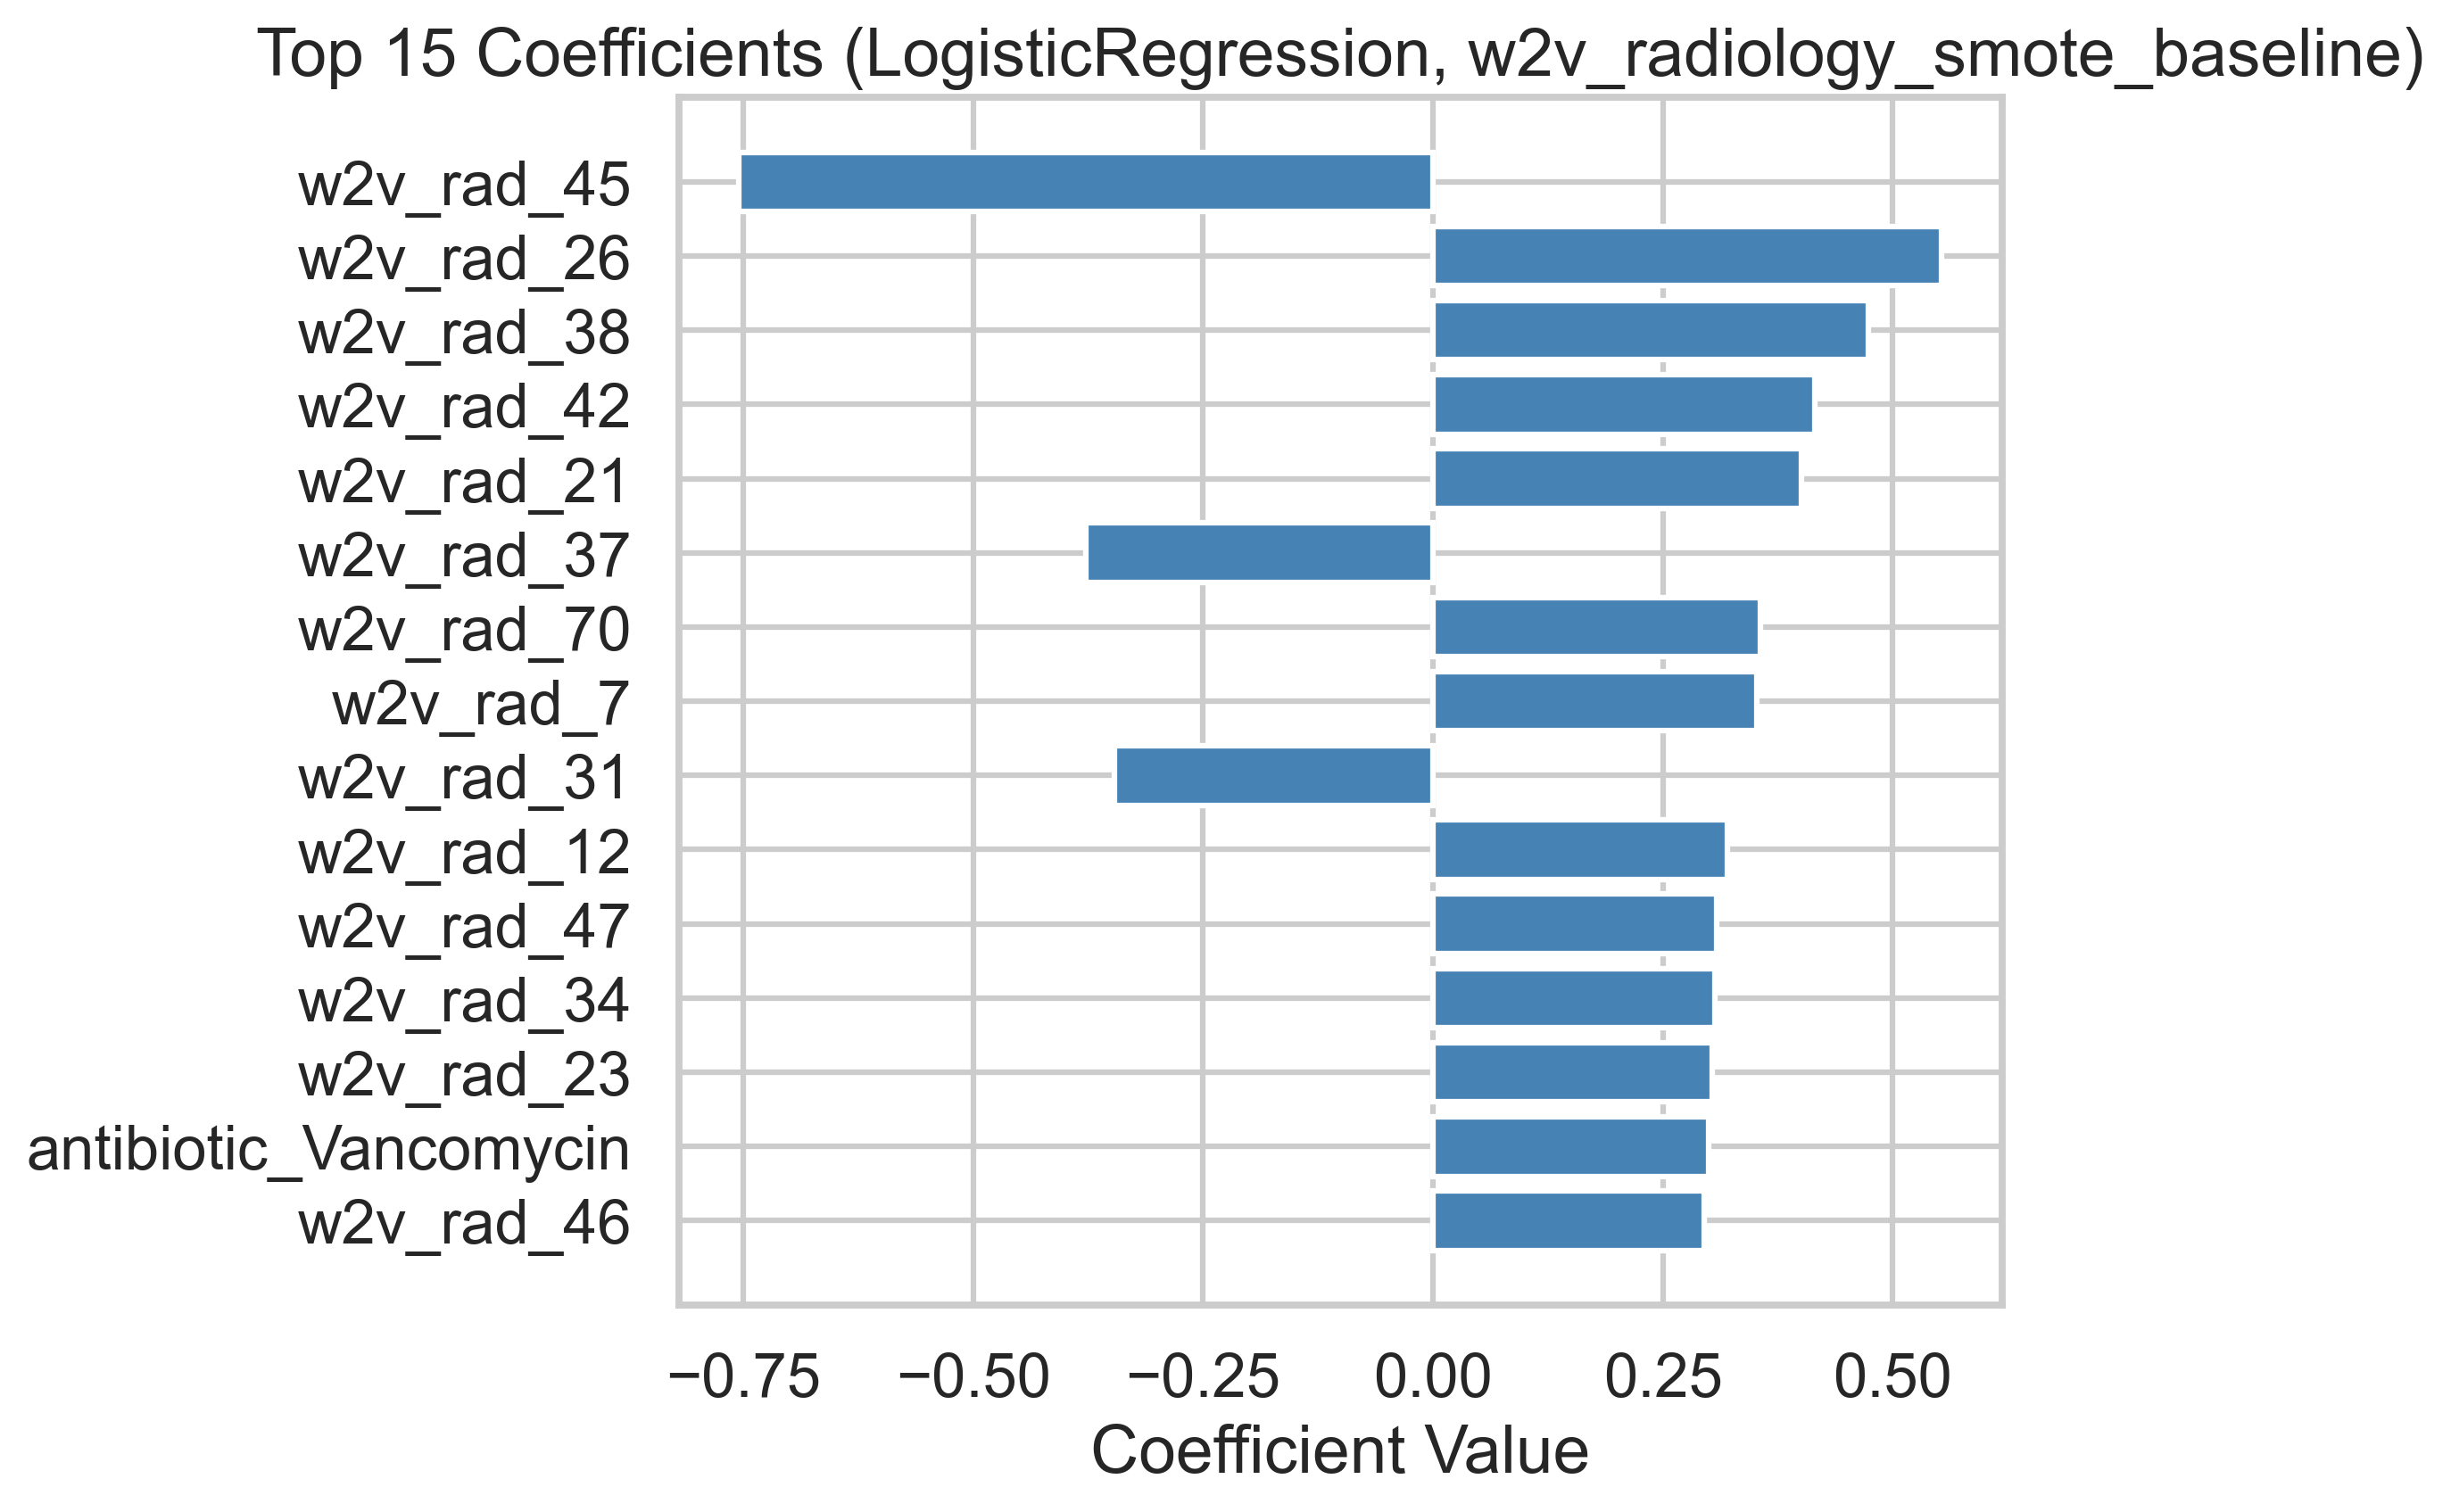

In [61]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_smote_baseline/coefficients_w2v_radiology_smote_baseline_LogisticRegression.png")))

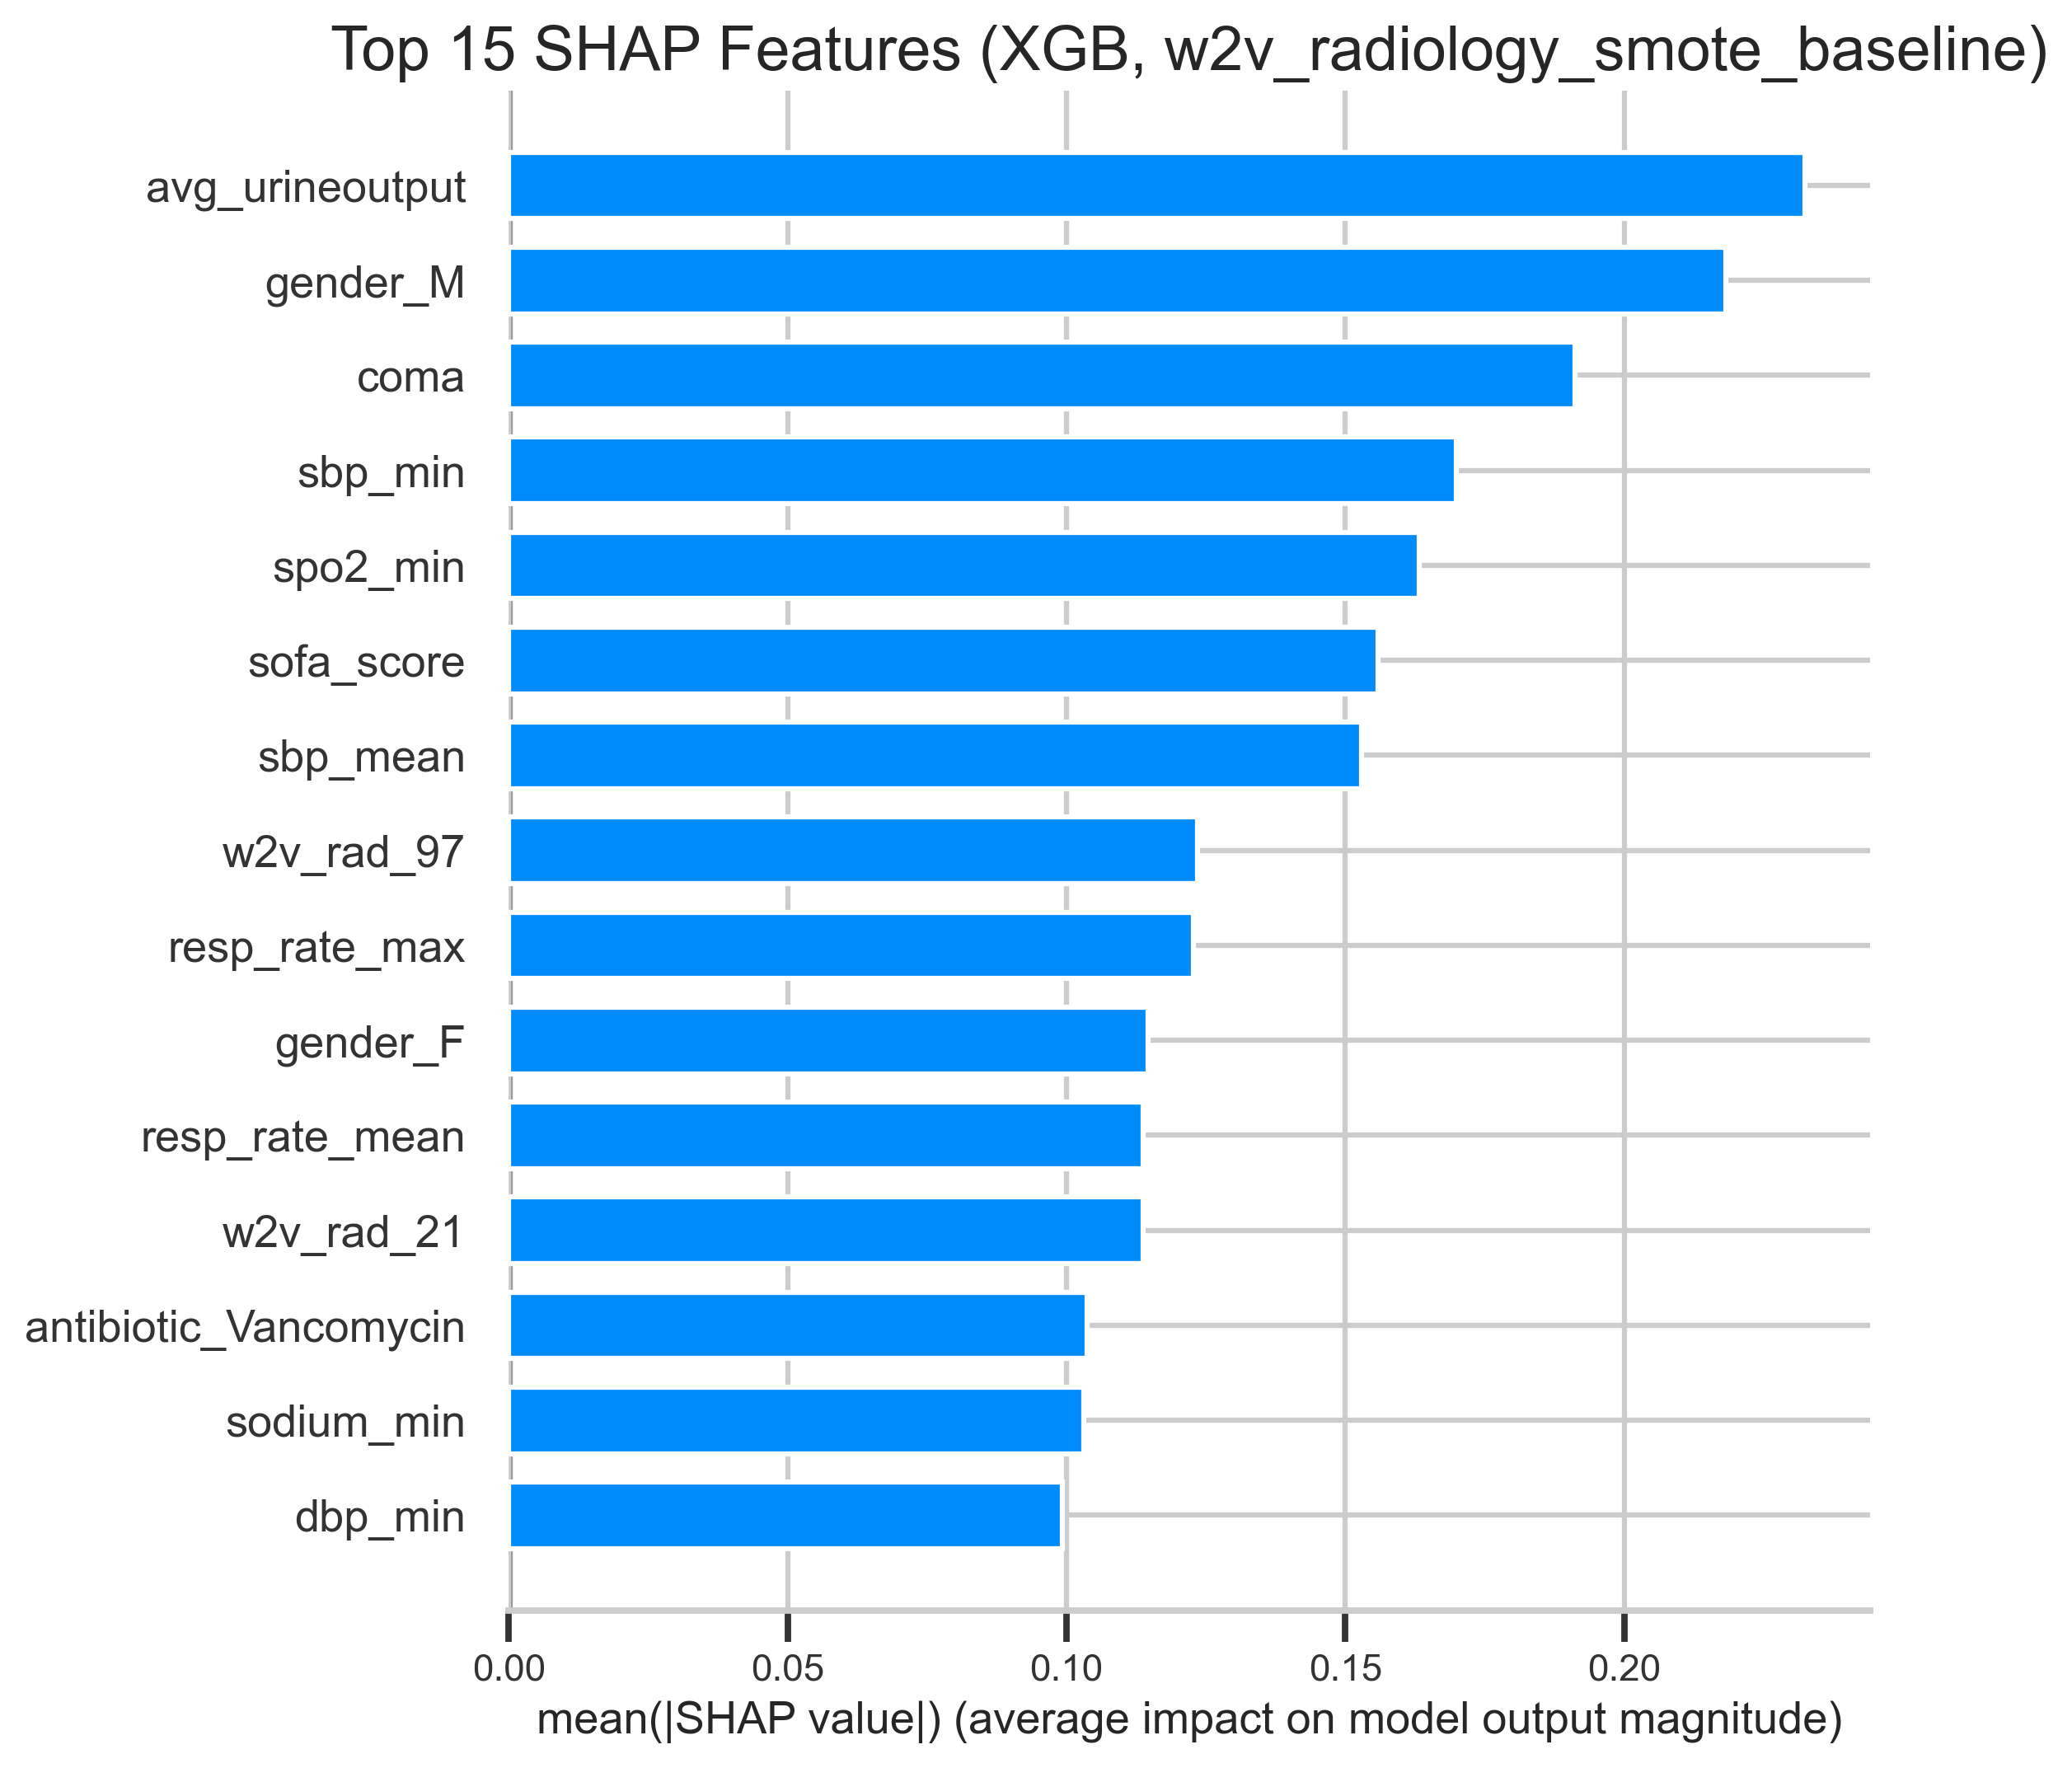

In [62]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_smote_baseline/shap_summary_w2v_radiology_smote_baseline_XGB.png")))

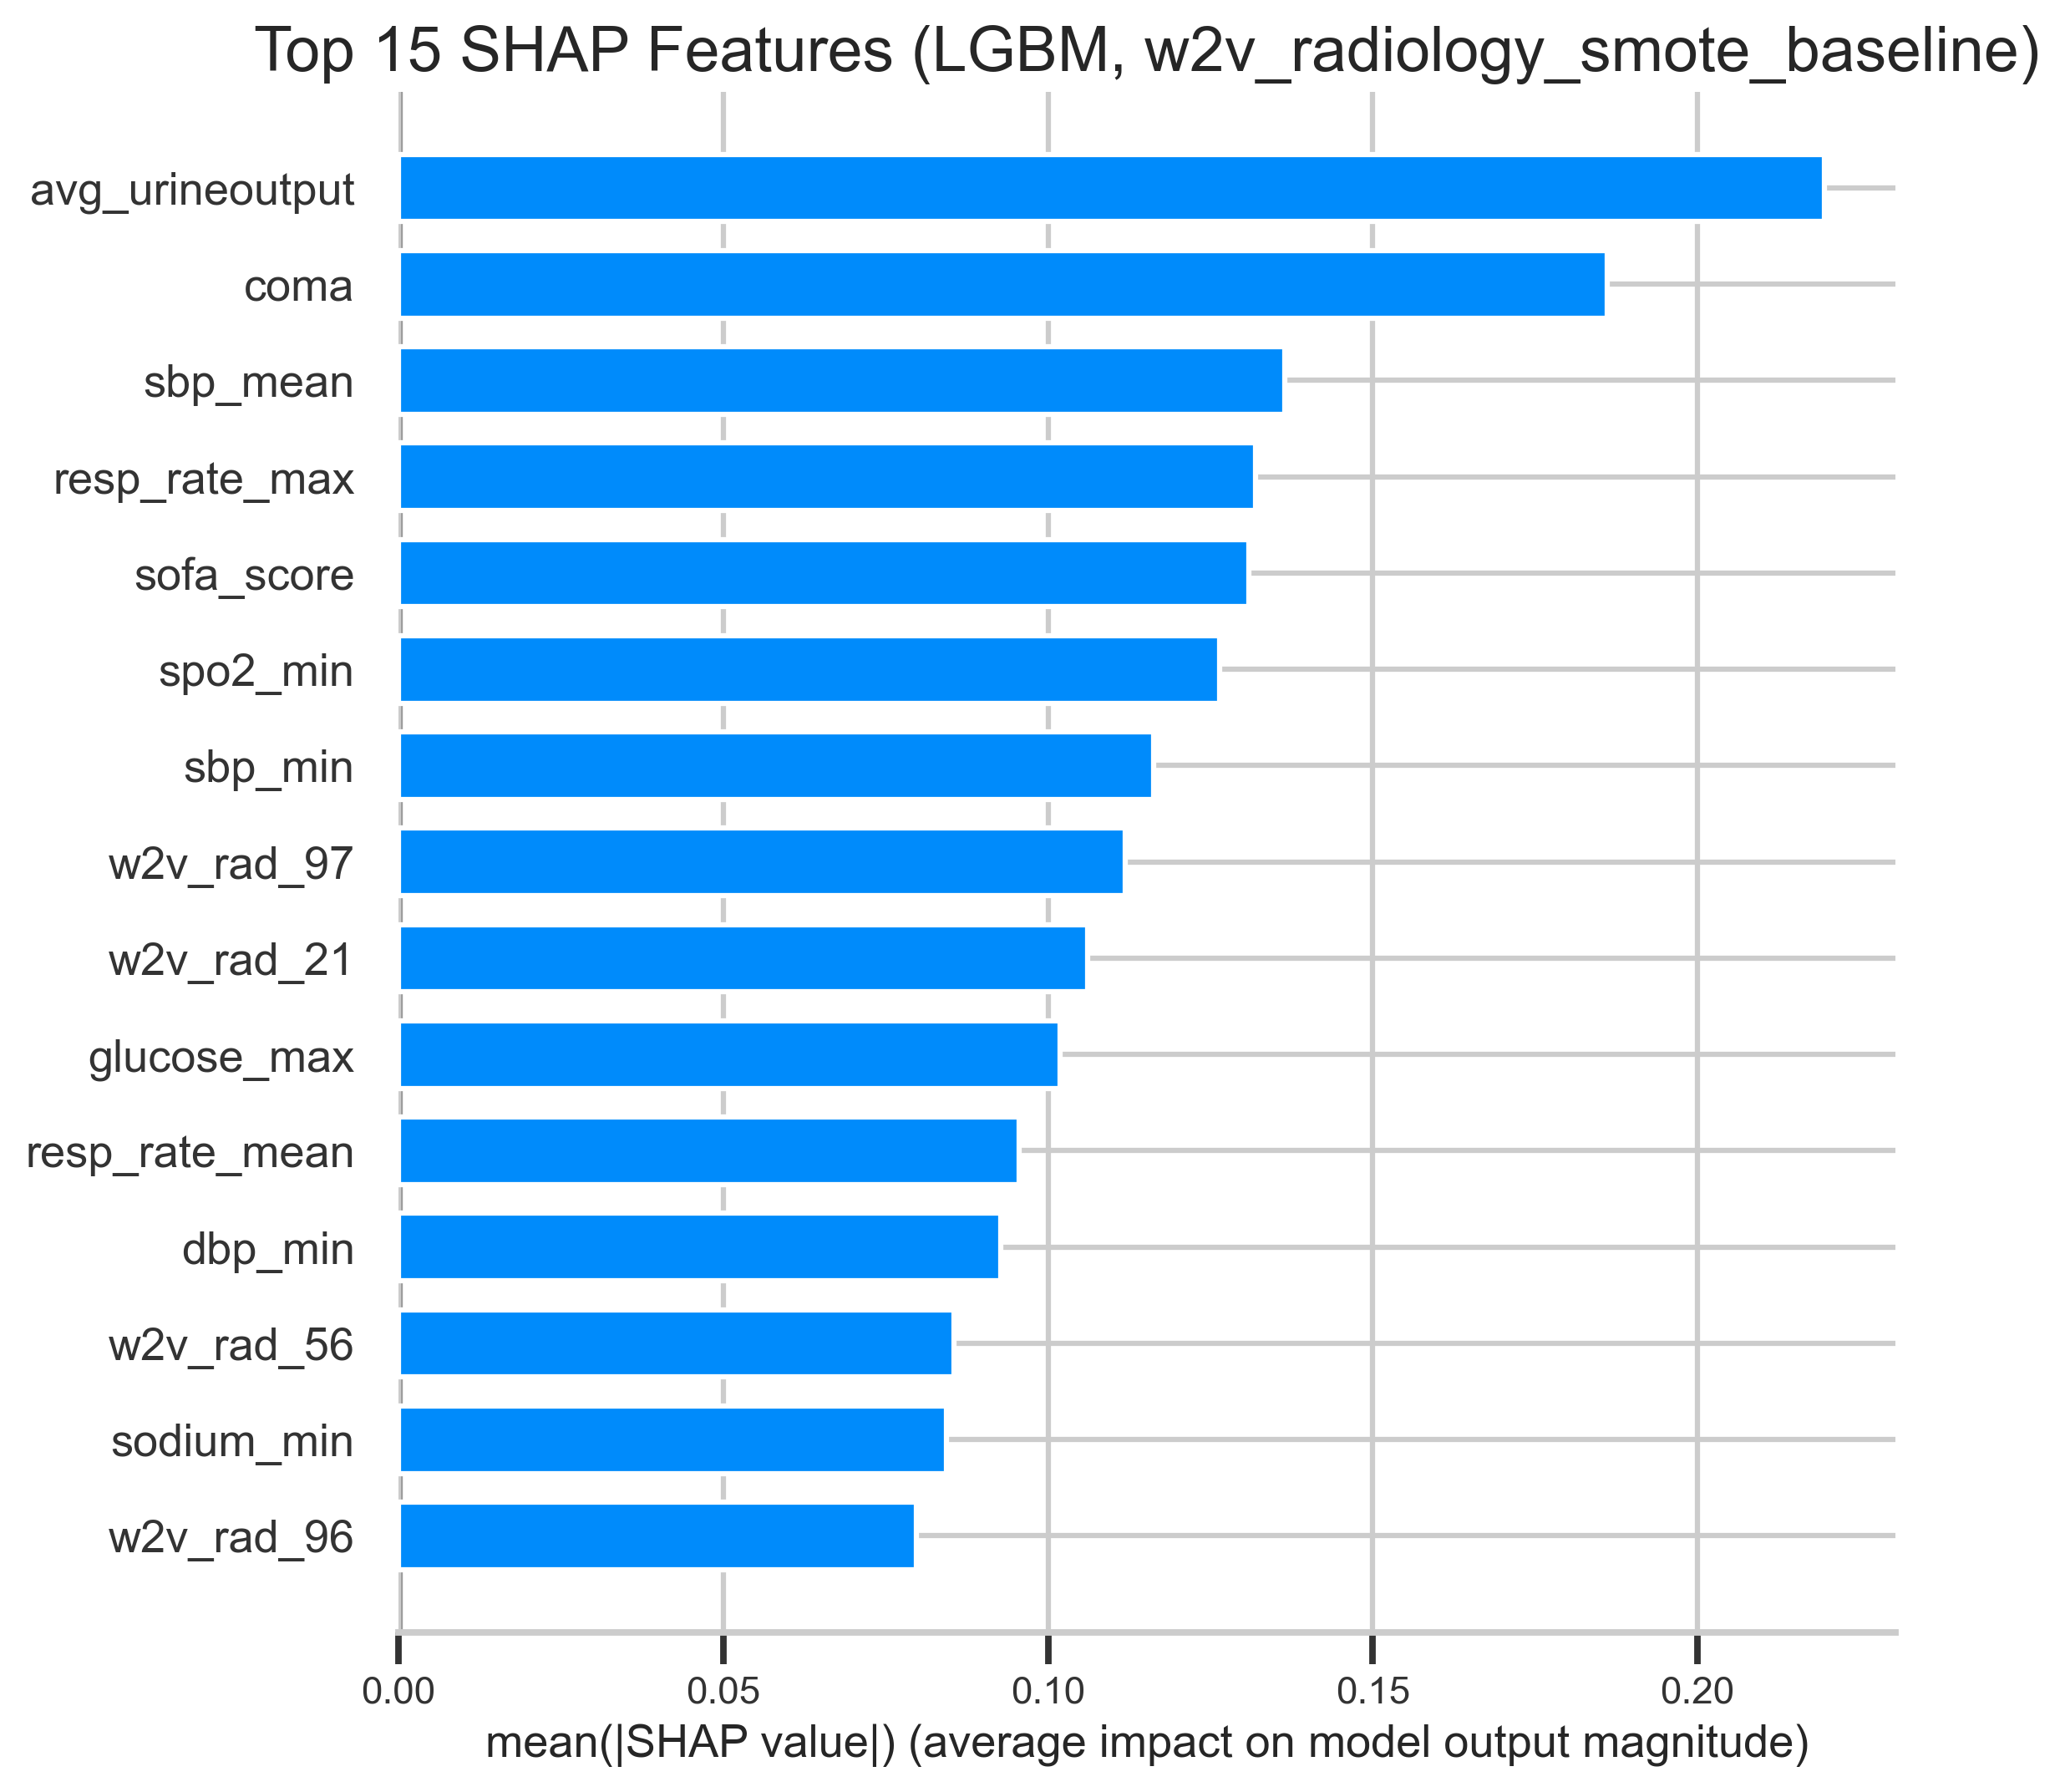

In [63]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_smote_baseline/shap_summary_w2v_radiology_smote_baseline_LGBM.png")))

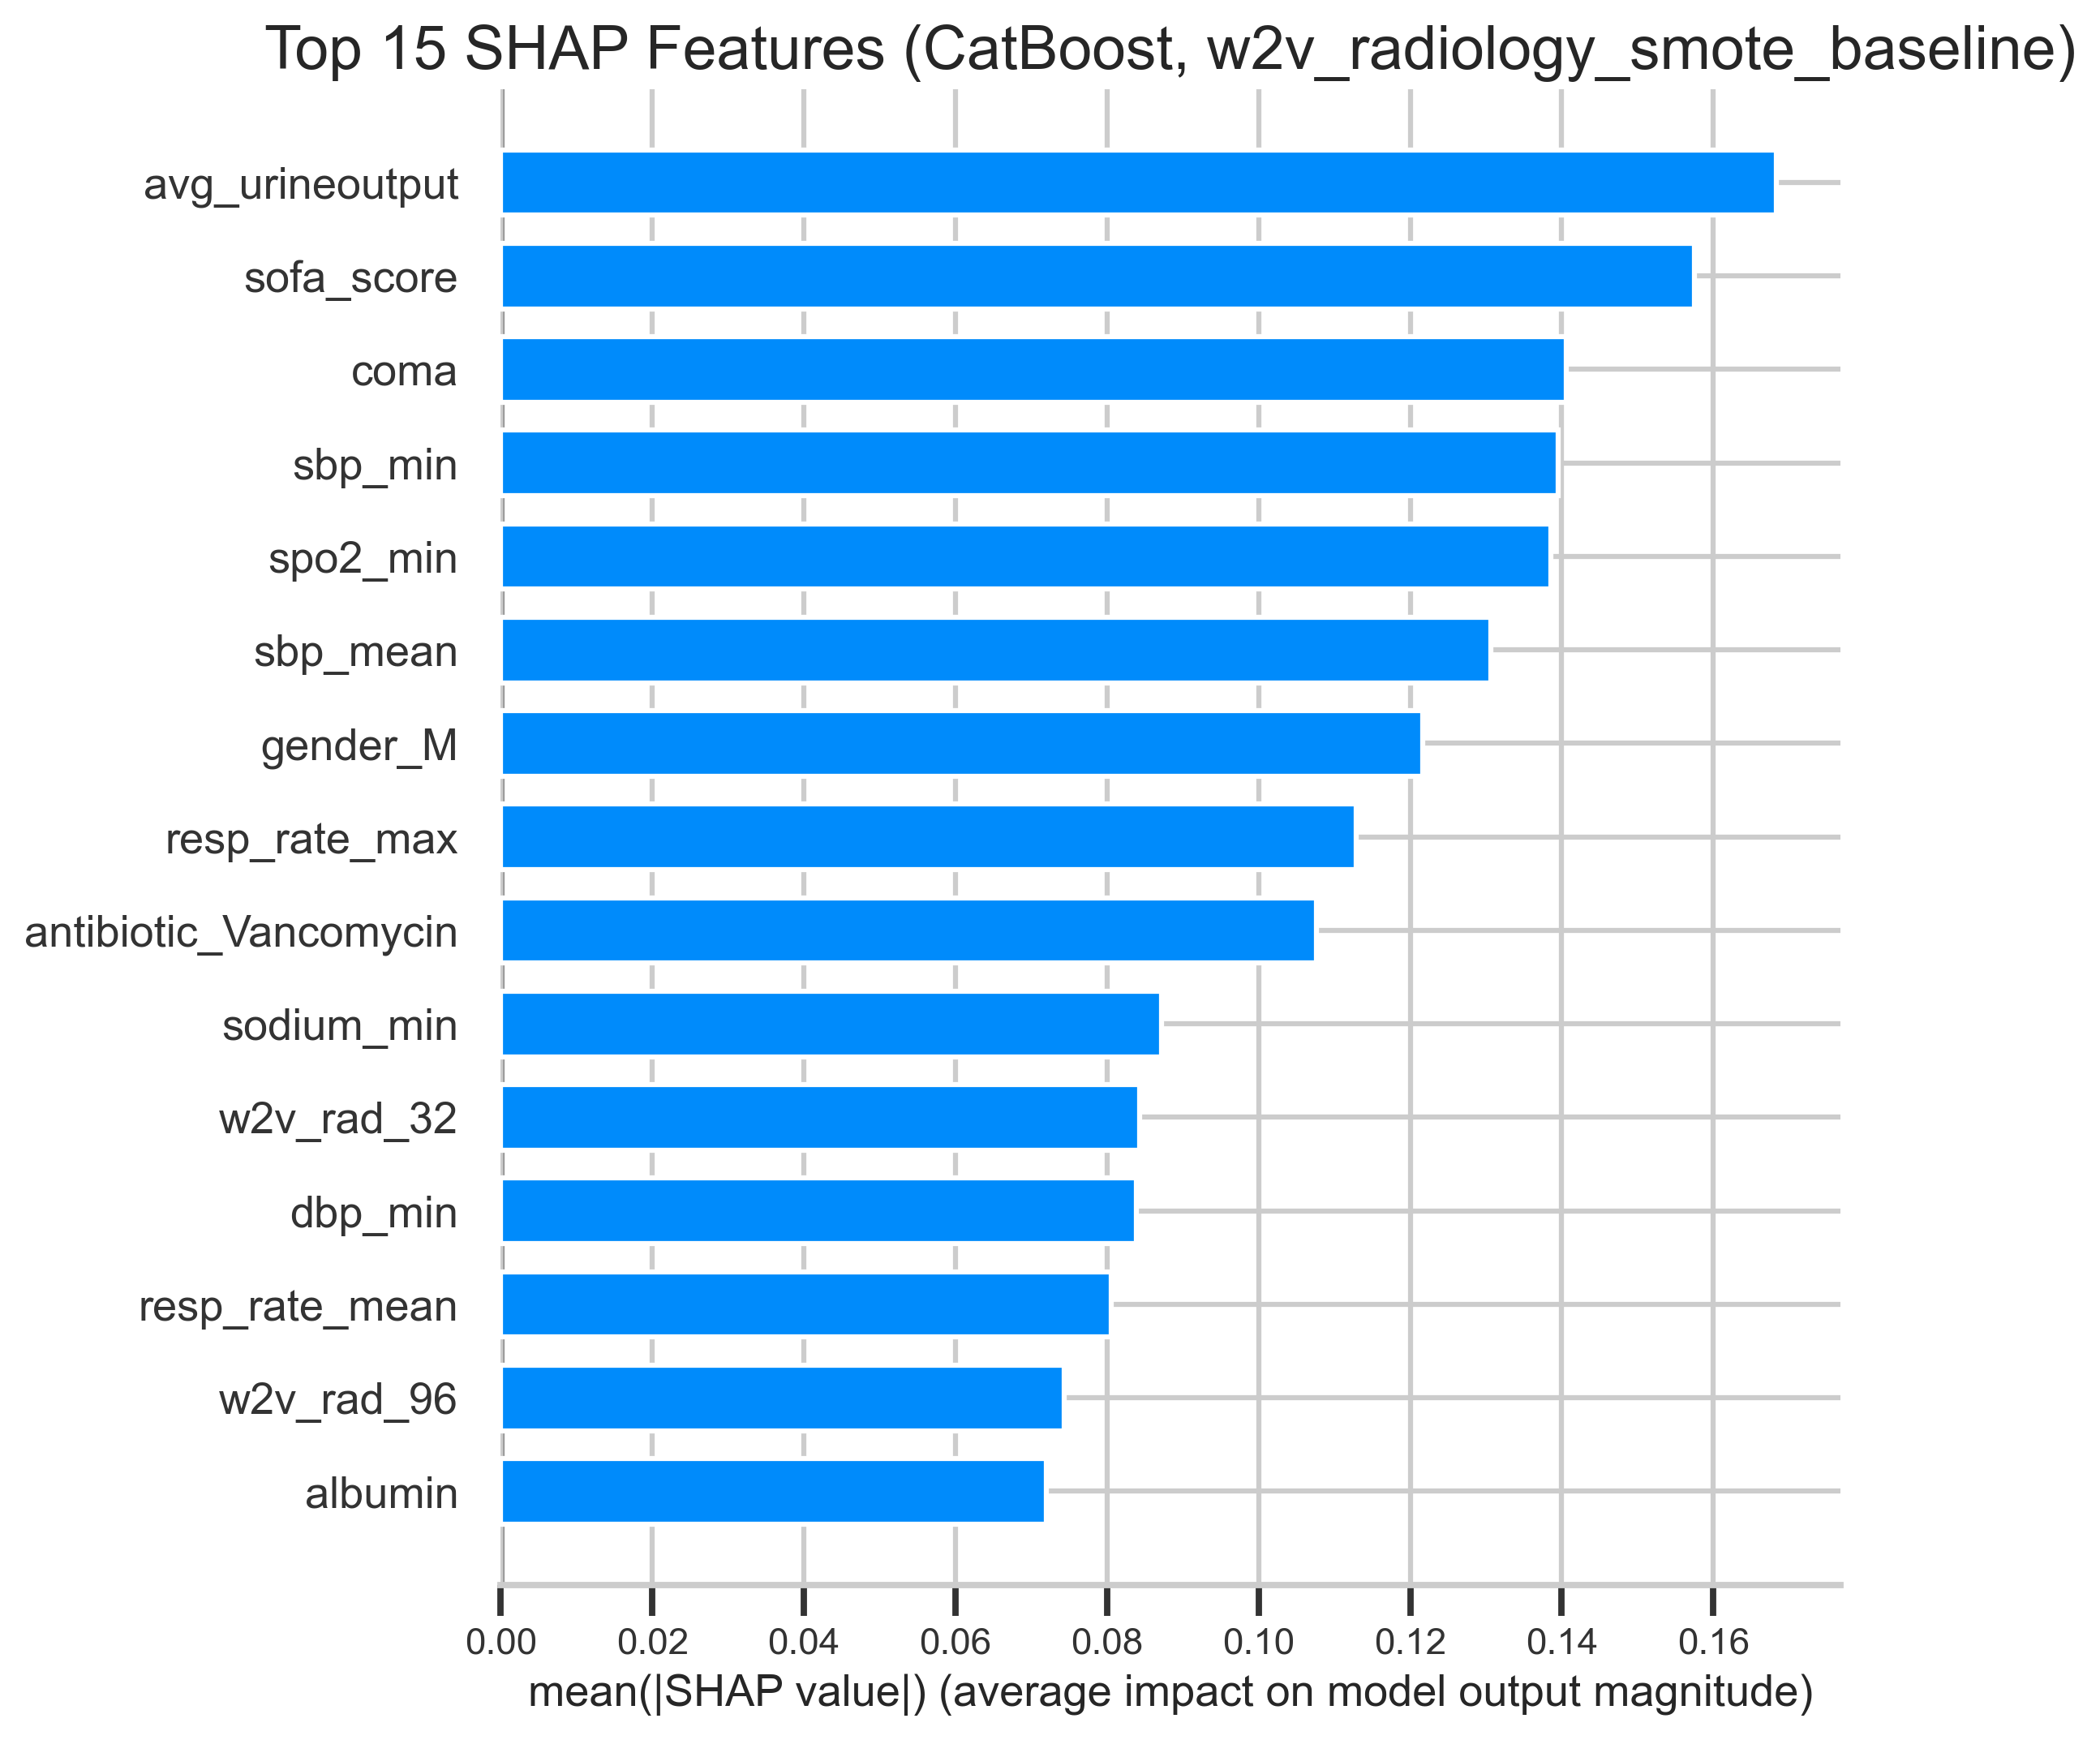

In [64]:
display(Image(filename=resolve_path("results/figures/w2v_radiology_smote_baseline/shap_summary_w2v_radiology_smote_baseline_CatBoost.png")))

# Part 4 Calibration and Reliability Plots

This section assesses how well model probabilities are calibrated.

**Objectives**
- Load the best models (Logistic, RF, XGB, LGBM).  
- Compute Brier scores and reliability curves.  
- Plot observed vs predicted probabilities.  
- Save figures → `results/figures/calibration/`.

## 14 Calibration Paths


In [65]:
# Directory for calibration plots
calib_dir = resolve_path("results/figures/calibration/")
calib_dir.mkdir(parents=True, exist_ok=True)
print(f"📁 Calibration figures will be saved to: {calib_dir}")

📁 Calibration figures will be saved to: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\calibration


## 15 Compute Brier Scores and Curves

For each model variant:
1. Get predicted probabilities.  
2. Compute Brier score.  
3. Plot reliability curve (observed vs predicted probability).

In [71]:
# ──────────────────────────────────────────────
# Baseline Brier Scores — saved to results/figures/{variant}_baseline/calibrations/
# ──────────────────────────────────────────────

records = []

for key, model in loaded_models_baseline.items():
    full_variant, clf_name = key.rsplit("_", 1)        # e.g., "original_baseline", "w2v_radiology_baseline"
    variant_lookup = full_variant.replace("_baseline", "")  # → original / w2v_radiology
    print(f"\n📏 Calibration: {clf_name} ({full_variant})")

    # --- Load matching test data ---
    X_test = X_tests.get(variant_lookup)
    y_test = y_tests.get(variant_lookup)
    if X_test is None or y_test is None:
        print(f"⚠️ Missing test data for {variant_lookup}")
        continue

    # --- Unwrap safely (pipeline or standalone) ---
    if hasattr(model, "named_steps"):
        clf = model.named_steps.get("clf", model)
    else:
        clf = model

    # --- Probability or decision score handling ---
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            # Normalize decision function outputs to [0,1]
            scores = clf.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            print(f"⚠️ {clf_name} provides neither predict_proba nor decision_function, skipping.")
            continue
    except Exception as e:
        print(f"⚠️ {clf_name} probability computation failed: {e}")
        continue

    # --- Compute calibration metrics ---
    brier = brier_score_loss(y_test, y_proba)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

    # --- Create variant-specific output directory ---
    variant_calib_dir = resolve_path(f"results/figures/{full_variant}/calibrations/")
    variant_calib_dir.mkdir(parents=True, exist_ok=True)

    # --- Plot calibration curve ---
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label=f"{clf_name} ({variant_lookup})")
    plt.plot([0,1],[0,1],'--',color='gray',label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Proportion")
    plt.title(f"Reliability Curve — {clf_name} ({full_variant})\nBrier Score = {brier:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Save under results/figures/{variant}_baseline/calibrations/ ---
    save_path = variant_calib_dir / f"calibration_{full_variant}_{clf_name}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"📊 Saved → {save_path}")

    # --- Record summary ---
    records.append({
        "Variant": full_variant,
        "Classifier": clf_name,
        "BrierScore": brier
    })



📏 Calibration: best (original_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_best.png

📏 Calibration: CatBoost (original_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_CatBoost.png

📏 Calibration: DecisionTree (original_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_DecisionTree.png

📏 Calibration: GradientBoosting (original_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_GradientBoosting.png

📏 Calibration: LGBM (original_baseline)
📊 Saved → C:\Users\tyler\On

In [72]:
# ──────────────────────────────────────────────
# SMOTE Baseline Brier Scores — saved to results/figures/{variant}_baseline_smote/calibrations/
# ──────────────────────────────────────────────

records_smote = []

for key, model in loaded_models_smote.items():
    # Example key: "w2v_radiology_smote_baseline_XGB"
    full_variant_smote, clf_name = key.rsplit("_", 1)
    variant_lookup = full_variant_smote.replace("_smote_baseline", "")  # → original / w2v_radiology
    print(f"\n📏 Calibration: {clf_name} ({full_variant_smote})")

    # --- Load matching test data ---
    X_test = X_tests.get(variant_lookup)
    y_test = y_tests.get(variant_lookup)
    if X_test is None or y_test is None:
        print(f"⚠️ Missing test data for {variant_lookup}")
        continue

    # --- Unwrap safely (pipeline or standalone) ---
    if hasattr(model, "named_steps"):
        clf = model.named_steps.get("clf", model)
    else:
        clf = model

    # --- Probability or decision score handling ---
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            # Normalize decision function outputs to [0,1]
            scores = clf.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            print(f"⚠️ {clf_name} provides neither predict_proba nor decision_function, skipping.")
            continue
    except Exception as e:
        print(f"⚠️ {clf_name} probability computation failed: {e}")
        continue

    # --- Compute calibration metrics ---
    brier = brier_score_loss(y_test, y_proba)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

    # --- Create variant-specific output directory ---
    variant_calib_dir = resolve_path(f"results/figures/{full_variant_smote}/calibrations/")
    variant_calib_dir.mkdir(parents=True, exist_ok=True)

    # --- Plot calibration curve ---
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label=f"{clf_name} ({full_variant_smote})")
    plt.plot([0,1],[0,1],'--',color='gray',label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Proportion")
    plt.title(f"Reliability Curve — {clf_name} ({full_variant_smote})\nBrier Score = {brier:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Save under results/figures/{variant}_baseline_smote/calibrations/ ---
    save_path = variant_calib_dir / f"calibration_{full_variant_smote}_{clf_name}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"📊 Saved → {save_path}")

    # --- Record summary ---
    records_smote.append({
        "Variant": full_variant_smote,
        "Classifier": clf_name,
        "BrierScore": brier
    })



📏 Calibration: best (original_smote_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_best.png

📏 Calibration: CatBoost (original_smote_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_CatBoost.png

📏 Calibration: DecisionTree (original_smote_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_DecisionTree.png

📏 Calibration: GradientBoosting (original_smote_baseline)
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_GradientBoosting.

## 16 Aggregate Results

Combine Brier scores into a summary table for later reporting.

In [74]:
# Baseline Brier Scores
records_baseline = []

for key, model in loaded_models_baseline.items():
    # Example key: "w2v_radiology_baseline_LogisticRegression"
    full_variant, clf_name = key.rsplit("_", 1)

    # Explicit mapping to test set
    variant_lookup = "w2v_radiology" if "w2v_radiology" in full_variant else "original"
    print(f"\n📏 Calibration: {clf_name} ({full_variant}) [lookup={variant_lookup}]")

    # --- Load test data ---
    X_test = X_tests.get(variant_lookup)
    y_test = y_tests.get(variant_lookup)
    if X_test is None or y_test is None:
        print(f"⚠️ Missing test data for {variant_lookup}, skipping.")
        continue

    # --- Unwrap pipeline safely ---
    clf = model.named_steps["clf"] if hasattr(model, "named_steps") and "clf" in model.named_steps else model

    # --- Compute predicted probabilities ---
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            # fallback for classifiers without predict_proba (e.g. linear SVC)
            scores = clf.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            print(f"⚠️ {clf_name} cannot produce probability scores, skipping.")
            continue
    except Exception as e:
        print(f"⚠️ Probability computation failed for {clf_name}: {e}")
        continue

    # --- Compute Brier score & reliability data ---
    brier = brier_score_loss(y_test, y_proba)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

    # --- Plot reliability curve ---
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label=f"{clf_name} ({full_variant})")
    plt.plot([0,1], [0,1], '--', color='gray', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Proportion")
    plt.title(f"Reliability Curve — {clf_name} ({full_variant})\nBrier Score = {brier:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)

    # Save under results/figures/{full_variant}/calibrations/
    variant_fig_dir = resolve_path(f"results/figures/{full_variant}/calibrations/")
    variant_fig_dir.mkdir(parents=True, exist_ok=True)
    save_path = variant_fig_dir / f"calibration_{full_variant}_{clf_name}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"📊 Saved → {save_path}")

    # --- Append to results list ---
    records_baseline.append({
        "Variant": full_variant,
        "Classifier": clf_name,
        "BrierScore": brier
    })

# --- Aggregate summary CSV ---
if records_baseline:
    calib_df_baseline = pd.DataFrame(records_baseline).sort_values("BrierScore")
    display(calib_df_baseline)

    out_csv = resolve_path("results/figures/calibration/calibration_summary_baseline.csv")
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    calib_df_baseline.to_csv(out_csv, index=False)
    print(f"✅ Baseline calibration summary saved → {out_csv}")
else:
    print("⚠️ No baseline calibration metrics computed.")


📏 Calibration: best (original_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_best.png

📏 Calibration: CatBoost (original_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_CatBoost.png

📏 Calibration: DecisionTree (original_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_DecisionTree.png

📏 Calibration: GradientBoosting (original_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_baseline\calibrations\calibration_original_baseline_GradientBoosting.

Variant          Classifier  BrierScore
12  w2v_radiology_baseline            CatBoost    0.152751
11  w2v_radiology_baseline                best    0.152751
16  w2v_radiology_baseline  LogisticRegression    0.153356
14  w2v_radiology_baseline    GradientBoosting    0.153871
15  w2v_radiology_baseline                LGBM    0.154570
0        original_baseline                best    0.156243
1        original_baseline            CatBoost    0.156243
20  w2v_radiology_baseline                 SVC    0.157036
17  w2v_radiology_baseline                 MLP    0.157420
3        original_baseline    GradientBoosting    0.157685
10       original_baseline                 XGB    0.158059
19  w2v_radiology_baseline        RandomForest    0.159005
8        original_baseline        RandomForest    0.159173
5        original_baseline  LogisticRegression    0.160314
4        original_baseline                LGBM    0.160426
21  w2v_radiology_baseline                 XGB    0.161069
9        original_baseline                 SVC    0.163489
6        original_baseline                 MLP    0.164434
2        original_baseline        DecisionTree    0.173380
13  w2v_radiology_baseline        DecisionTree    0.182252
7        original_baseline          NaiveBayes    0.213487
18  w2v_radiology_baseline          NaiveBayes    0.337463

✅ Baseline calibration summary saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\calibration\calibration_summary_baseline.csv


In [75]:
# Smote Baseline Brier Scores
records_smote = []

for key, model in loaded_models_smote.items():
    # Example key: "w2v_radiology_smote_baseline_LogisticRegression"
    full_variant_smote, clf_name = key.rsplit("_", 1)

    # Explicit mapping to correct test set
    variant_lookup = "w2v_radiology" if "w2v_radiology" in full_variant_smote else "original"
    print(f"\n📏 Calibration: {clf_name} ({full_variant_smote}) [lookup={variant_lookup}]")

    # --- Load test data ---
    X_test = X_tests.get(variant_lookup)
    y_test = y_tests.get(variant_lookup)
    if X_test is None or y_test is None:
        print(f"⚠️ Missing test data for {variant_lookup}, skipping.")
        continue

    # --- Unwrap classifier safely ---
    clf = model.named_steps["clf"] if hasattr(model, "named_steps") and "clf" in model.named_steps else model

    # --- Get probability predictions or decision scores ---
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            scores = clf.decision_function(X_test)
            y_proba = (scores - scores.min()) / (scores.max() - scores.min())
        else:
            print(f"⚠️ {clf_name} cannot produce probability scores, skipping.")
            continue
    except Exception as e:
        print(f"⚠️ Probability computation failed for {clf_name}: {e}")
        continue

    # --- Compute Brier score and calibration data ---
    brier = brier_score_loss(y_test, y_proba)
    prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10, strategy="uniform")

    # --- Plot reliability curve ---
    plt.figure(figsize=(6,6))
    plt.plot(prob_pred, prob_true, marker='o', label=f"{clf_name} ({full_variant_smote})")
    plt.plot([0,1],[0,1],'--',color='gray',label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Proportion")
    plt.title(f"Reliability Curve — {clf_name} ({full_variant_smote})\nBrier Score = {brier:.3f}")
    plt.legend()
    plt.grid(alpha=0.3)

    # --- Save under results/figures/{variant}_baseline_smote/calibrations/ ---
    variant_calib_dir = resolve_path(f"results/figures/{full_variant_smote}/calibrations/")
    variant_calib_dir.mkdir(parents=True, exist_ok=True)
    save_path = variant_calib_dir / f"calibration_{full_variant_smote}_{clf_name}.png"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.close()
    print(f"📊 Saved → {save_path}")

    # --- Append to results list ---
    records_smote.append({
        "Variant": full_variant_smote,
        "Classifier": clf_name,
        "BrierScore": brier
    })

# --- Aggregate summary CSV ---
if records_smote:
    calib_df_smote = pd.DataFrame(records_smote).sort_values("BrierScore")
    display(calib_df_smote)

    out_csv = resolve_path("results/figures/calibration/calibration_summary_smote.csv")
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    calib_df_smote.to_csv(out_csv, index=False)
    print(f"✅ SMOTE calibration summary saved → {out_csv}")
else:
    print("⚠️ No SMOTE calibration metrics computed.")



📏 Calibration: best (original_smote_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_best.png

📏 Calibration: CatBoost (original_smote_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_CatBoost.png

📏 Calibration: DecisionTree (original_smote_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_baseline\calibrations\calibration_original_smote_baseline_DecisionTree.png

📏 Calibration: GradientBoosting (original_smote_baseline) [lookup=original]
📊 Saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\original_smote_bas

Variant          Classifier  BrierScore
12  w2v_radiology_smote_baseline            CatBoost    0.158731
15  w2v_radiology_smote_baseline                LGBM    0.161362
21  w2v_radiology_smote_baseline                 XGB    0.163503
0        original_smote_baseline                best    0.166610
1        original_smote_baseline            CatBoost    0.166610
4        original_smote_baseline                LGBM    0.167779
10       original_smote_baseline                 XGB    0.175932
14  w2v_radiology_smote_baseline    GradientBoosting    0.176818
19  w2v_radiology_smote_baseline        RandomForest    0.182187
8        original_smote_baseline        RandomForest    0.193308
3        original_smote_baseline    GradientBoosting    0.198313
9        original_smote_baseline                 SVC    0.203831
13  w2v_radiology_smote_baseline        DecisionTree    0.206051
11  w2v_radiology_smote_baseline                best    0.206443
16  w2v_radiology_smote_baseline  LogisticRegression    0.206443
20  w2v_radiology_smote_baseline                 SVC    0.208865
17  w2v_radiology_smote_baseline                 MLP    0.219205
6        original_smote_baseline                 MLP    0.220000
2        original_smote_baseline        DecisionTree    0.220341
5        original_smote_baseline  LogisticRegression    0.222417
7        original_smote_baseline          NaiveBayes    0.311657
18  w2v_radiology_smote_baseline          NaiveBayes    0.394837

✅ SMOTE calibration summary saved → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\calibration\calibration_summary_smote.csv


In [81]:
# ──────────────────────────────────────────────
# Compare coefficients / parameters between baseline and SMOTE models
# ──────────────────────────────────────────────

def compare_model_params(baseline_dict, smote_dict, clf_name, variant_root="w2v_radiology"):
    """
    Compare mean absolute coefficient differences between baseline and SMOTE-trained models
    for a given classifier (e.g., LogisticRegression).
    """

    k_base  = f"{variant_root}_baseline_{clf_name}"
    k_smote = f"{variant_root}_smote_baseline_{clf_name}"

    if k_base not in baseline_dict or k_smote not in smote_dict:
        print(f"⚠️ Missing model keys for {clf_name} ({variant_root}).")
        return

    m1 = baseline_dict[k_base]
    m2 = smote_dict[k_smote]

    # Safely unwrap pipelines
    clf1 = m1.named_steps["clf"] if hasattr(m1, "named_steps") and "clf" in m1.named_steps else m1
    clf2 = m2.named_steps["clf"] if hasattr(m2, "named_steps") and "clf" in m2.named_steps else m2

    # Only works for linear models with coef_
    if not hasattr(clf1, "coef_") or not hasattr(clf2, "coef_"):
        print(f"⚠️ {clf_name} does not expose coefficients (skipping).")
        return

    c1 = clf1.coef_.ravel()
    c2 = clf2.coef_.ravel()

    diff = np.mean(np.abs(c1 - c2))
    print(f"Δ mean(|coef diff|) — {clf_name} ({variant_root}): {diff:.6f}")

# Example use
compare_model_params(loaded_models_baseline, loaded_models_smote, "LogisticRegression", "w2v_radiology")
compare_model_params(loaded_models_baseline, loaded_models_smote, "LogisticRegression", "original")


Δ mean(|coef diff|) — LogisticRegression (w2v_radiology): 0.049243
Δ mean(|coef diff|) — LogisticRegression (original): 0.031143


In [83]:
# ──────────────────────────────────────────────
# Compare predicted probabilities for all classifiers
# ──────────────────────────────────────────────

for variant_root in ["original", "w2v_radiology"]:
    print(f"\n🔍 Δ Predicted Probability Comparison — {variant_root.upper()}")
    for clf_name in classifiers:
        k_base  = f"{variant_root}_baseline_{clf_name}"
        k_smote = f"{variant_root}_smote_baseline_{clf_name}"

        if k_base not in loaded_models_baseline or k_smote not in loaded_models_smote:
            print(f"⚠️ Missing model for {clf_name} ({variant_root}), skipping.")
            continue

        m1 = loaded_models_baseline[k_base]
        m2 = loaded_models_smote[k_smote]

        # Safely unwrap pipelines
        clf1 = m1.named_steps.get("clf", m1) if hasattr(m1, "named_steps") else m1
        clf2 = m2.named_steps.get("clf", m2) if hasattr(m2, "named_steps") else m2

        X_test = X_tests[variant_root]

        try:
            if hasattr(clf1, "predict_proba") and hasattr(clf2, "predict_proba"):
                p1 = clf1.predict_proba(X_test)[:, 1]
                p2 = clf2.predict_proba(X_test)[:, 1]
            elif hasattr(clf1, "decision_function") and hasattr(clf2, "decision_function"):
                # Fallback for models without predict_proba (e.g., linear SVC)
                s1 = clf1.decision_function(X_test)
                s2 = clf2.decision_function(X_test)
                p1 = (s1 - s1.min()) / (s1.max() - s1.min())
                p2 = (s2 - s2.min()) / (s2.max() - s2.min())
            else:
                print(f"⚠️ {clf_name} provides neither predict_proba nor decision_function (skipping).")
                continue

            diff = np.mean(np.abs(p1 - p2))
            print(f"Δ mean(|prob diff|) — {clf_name:17s} ({variant_root}): {diff:.6f}")
        except Exception as e:
            print(f"⚠️ Probability comparison failed for {clf_name} ({variant_root}): {e}")



🔍 Δ Predicted Probability Comparison — ORIGINAL
Δ mean(|prob diff|) — LogisticRegression (original): 0.206357
Δ mean(|prob diff|) — DecisionTree      (original): 0.227217
Δ mean(|prob diff|) — RandomForest      (original): 0.169578
Δ mean(|prob diff|) — GradientBoosting  (original): 0.179819
Δ mean(|prob diff|) — XGB               (original): 0.120676
Δ mean(|prob diff|) — LGBM              (original): 0.069253
Δ mean(|prob diff|) — CatBoost          (original): 0.088930
Δ mean(|prob diff|) — SVC               (original): 0.186355
Δ mean(|prob diff|) — MLP               (original): 0.208223
Δ mean(|prob diff|) — NaiveBayes        (original): 0.249412

🔍 Δ Predicted Probability Comparison — W2V_RADIOLOGY
Δ mean(|prob diff|) — LogisticRegression (w2v_radiology): 0.201436
Δ mean(|prob diff|) — DecisionTree      (w2v_radiology): 0.212660
Δ mean(|prob diff|) — RandomForest      (w2v_radiology): 0.142891
Δ mean(|prob diff|) — GradientBoosting  (w2v_radiology): 0.134364
Δ mean(|prob diff|) —

# Part 5 Export and Consolidate Visualization Outputs

This section verifies and consolidates all generated figures, calibration results, and SHAP outputs.  
These exports are used downstream in:
- Reporting & Figures
- MLflow Integration

In [78]:
### --- Need to edit this ---  ###

from datetime import datetime

# Define root directories for outputs
figure_dirs = [
    resolve_path("results/figures/comparisons/"),
    resolve_path("results/figures/shap/"),
    resolve_path("results/figures/calibration/")
]
eval_dir = resolve_path("results/evaluation/")
timestamp = datetime.now().strftime("%Y%m%d_%H%M")

# Verify existing outputs
for fdir in figure_dirs:
    if fdir.exists():
        files = list(fdir.glob("*.png"))
        print(f"📁 {fdir.name}: {len(files)} files")
    else:
        print(f"⚠️ Missing figure directory: {fdir}")

# Gather summaries
summaries_csv = list(eval_dir.glob("*_summary.csv"))
if summaries_csv:
    print(f"📄 Found {len(summaries_csv)} evaluation summaries:")
    for f in summaries_csv:
        print("   •", f.name)
else:
    print("⚠️ No evaluation summaries found in results/evaluation/")

# Consolidate calibration summary
calib_summary = resolve_path("results/figures/calibration/calibration_summary.csv")
if calib_summary.exists():
    calib_df = pd.read_csv(calib_summary)
    calib_df.to_csv(resolve_path(f"results/exports/calibration_summary_{timestamp}.csv"), index=False)
    print(f"✅ Exported calibration summary → results/exports/calibration_summary_{timestamp}.csv")
else:
    print("⚠️ Calibration summary not found.")

# Combine all evaluation summaries (optional)
exports_dir = resolve_path("results/exports/")
exports_dir.mkdir(parents=True, exist_ok=True)

try:
    all_summaries = pd.concat([pd.read_csv(f) for f in summaries_csv], ignore_index=True)
    combined_csv = exports_dir / f"evaluation_summaries_{timestamp}.csv"
    all_summaries.to_csv(combined_csv, index=False)
    print(f"✅ Combined evaluation summaries → {combined_csv}")
except Exception as e:
    print(f"⚠️ Could not combine summaries: {e}")

📁 comparisons: 4 files
⚠️ Missing figure directory: C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\figures\shap
📁 calibration: 0 files
📄 Found 2 evaluation summaries:
   • original_summary.csv
   • w2v_radiology_summary.csv
⚠️ Calibration summary not found.
✅ Combined evaluation summaries → C:\Users\tyler\OneDrive - University of Pittsburgh\BIOST 2021 Thesis\Masters-Thesis\results\exports\evaluation_summaries_20251027_2212.csv


All key deliverables have been saved for downstream reporting:

| Output Type | Location |
|--------------|-----------|
| Combined evaluation summaries | `results/exports/evaluation_summaries_<date>.csv` |
| SHAP & Coefficient plots | `results/figures/shap/` |
| ROC / PR comparison plots | `results/figures/comparisons/` |
| Calibration reliability plots | `results/figures/calibration/` |
| Calibration summary table | `results/exports/calibration_summary_<date>.csv` |

These exports will be referenced in **Task 12 (Reporting)** for figure and table generation.

## ✅ Next Step: Task 8 — W2V Hyperparameter Search

Proceed to `07_w2v_hyperparam_search.ipynb` to optimize Word2Vec embedding parameters.

# Debugging tools for Writing

In [ ]:
'''
import joblib
from pathlib import Path

# Path to your specific retrained SMOTE model
model_path = Path("../results/models/w2v_radiology_baseline/w2v_radiology_baseline_20251012_0020/w2v_radiology_baseline_20251012_0020_LogisticRegression_smote_model.pkl")

# Load model
model = joblib.load(model_path)

# Unwrap pipeline components
if hasattr(model, "named_steps") and "clf" in model.named_steps:
    clf = model.named_steps["clf"]
    scaler = model.named_steps.get("scaler", None)
else:
    clf = model
    scaler = None

# Check feature-space metadata
n_features_model = getattr(clf, "n_features_in_", None)
feature_names = getattr(scaler, "feature_names_in_", None)

print(f"📦 Model file: {model_path.name}")
print(f"🔹 Classifier type: {type(clf).__name__}")
print(f"🔹 n_features_in_: {n_features_model}")
if feature_names is not None:
    print(f"🔹 Feature names detected ({len(feature_names)}):")
    print(feature_names[:10], "...")
else:
    print("⚠️ No feature_names_in_ stored in scaler — using n_features_in_ only.")
'''

In [ ]:
'''
# ==========================================================
# FINAL FIX — Refit W2V Radiology Baseline Models on SMOTE Data
# ==========================================================
import joblib, json, copy
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
from src.evaluation import unwrap_best_estimators

# ----------------------------------------------------------
# 1️⃣ Paths
# ----------------------------------------------------------
base_dir = Path("../results/models/w2v_radiology_baseline/w2v_radiology_baseline_20251012_0020")
full_pkl = base_dir / "w2v_radiology_baseline_20251012_0020_full.pkl"
smote_full_pkl = base_dir / "w2v_radiology_baseline_20251012_0020_smote_full.pkl"

# ----------------------------------------------------------
# 2️⃣ Load models + SMOTE data
# ----------------------------------------------------------
print(f"📦 Loading baseline model dictionary → {full_pkl}")
models_dict = unwrap_best_estimators(joblib.load(full_pkl))

X_train_smote = pd.read_csv("../data/processed/w2v_radiology/data_w2v_radiology_xtrain_res.csv")
y_train_smote = pd.read_csv("../data/processed/w2v_radiology/data_w2v_radiology_ytrain_res.csv").squeeze()
X_test = pd.read_csv("../data/processed/w2v_radiology/data_w2v_radiology_xtest.csv")
y_test = pd.read_csv("../data/processed/w2v_radiology/data_w2v_radiology_ytest.csv").squeeze()

print(f"✅ Loaded SMOTE W2V data → train={X_train_smote.shape}, test={X_test.shape}")

# ----------------------------------------------------------
# 3️⃣ Clone and retrain classifiers fresh
# ----------------------------------------------------------
retrained_dict = {}

for name, model in models_dict.items():
    print(f"\n🔁 Re-fitting {name} from scratch on W2V SMOTE data...")

    # Extract the original classifier
    clf = model.named_steps["clf"] if hasattr(model, "named_steps") and "clf" in model.named_steps else model
    clf_clone = clone(clf)  # fresh estimator (no cached weights)

    # Rebuild pipeline (in case scaling is added later)
    new_pipe = Pipeline([("clf", clf_clone)])
    new_pipe.fit(X_train_smote, y_train_smote)

    # --- Evaluate ---
    try:
        y_proba = new_pipe.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = new_pipe.decision_function(X_test)
        y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())

    y_pred = (y_proba > 0.5).astype(int)
    metrics = {
        "AUROC": float(roc_auc_score(y_test, y_proba)),
        "Accuracy": float(accuracy_score(y_test, y_pred)),
        "F1": float(f1_score(y_test, y_pred)),
        "Precision": float(precision_score(y_test, y_pred)),
        "Recall": float(recall_score(y_test, y_pred)),
    }

    # --- Save per-model files ---
    model_path = base_dir / f"w2v_radiology_baseline_20251012_0020_{name}_smote_model.pkl"
    metrics_path = base_dir / f"w2v_radiology_baseline_20251012_0020_{name}_metrics_smote.json"

    joblib.dump(new_pipe, model_path)
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=4)

    retrained_dict[name] = new_pipe
    print(f"💾 Saved model → {model_path.name}")
    print(f"📊 Saved metrics → {metrics_path.name}")
    print(f"   AUROC={metrics['AUROC']:.3f}, F1={metrics['F1']:.3f}")

# ----------------------------------------------------------
# 4️⃣ Save combined dictionary
# ----------------------------------------------------------
joblib.dump(retrained_dict, smote_full_pkl)
print(f"\n✅ Saved combined SMOTE model dictionary → {smote_full_pkl}")
print("🎯 W2V Radiology SMOTE retraining complete.")
'''

In [ ]:
import joblib
m = joblib.load(base_dir / "w2v_radiology_baseline_20251012_0020_LogisticRegression_smote_model.pkl")
print("n_features_in_:", m.named_steps["clf"].n_features_in_)


In [ ]:
compare_model_params(loaded_models_baseline, loaded_models_smote, "LogisticRegression")


In [ ]:
'''
from src.evaluation import unwrap_best_estimators
import joblib

base_dir = Path("../results/models/w2v_radiology_baseline/w2v_radiology_baseline_20251012_0020")
models_dict = joblib.load(base_dir / "w2v_radiology_baseline_20251012_0020_full.pkl")

unwrapped = unwrap_best_estimators(models_dict)
for k, v in unwrapped.items():
    print(f"{k}: type={type(v)} | has_fit={hasattr(v, 'fit')} | steps={getattr(v, 'named_steps', None)}")
    '''


In [ ]:
'''
import pandas as pd

# --- Load your original vs SMOTE versions ---
y_train_orig = pd.read_csv("../data/processed/w2v_radiology/data_w2v_radiology_ytrain.csv").squeeze()
y_train_smote = pd.read_csv("../data/processed/w2v_radiology/data_w2v_radiology_ytrain_res.csv").squeeze()

print("📏 Shapes:")
print(f"Original y_train: {y_train_orig.shape}")
print(f"SMOTE y_train_res: {y_train_smote.shape}")

print("\n📊 Class balance (original):")
print(y_train_orig.value_counts(normalize=True))

print("\n📊 Class balance (SMOTE):")
print(y_train_smote.value_counts(normalize=True))

'''


In [ ]:
'''
import joblib
from pathlib import Path

path = Path("../results/models/w2v_radiology_baseline/w2v_radiology_baseline_20251012_0020/w2v_radiology_baseline_20251012_0020_full.pkl")
models_dict = joblib.load(path)

print("Keys:", models_dict.keys())
for name, obj in models_dict.items():
    print(f"\n{name}: type={type(obj)}")
    if hasattr(obj, "best_estimator_"):
        print("  → contains best_estimator_ (likely a CV search object)")
    if hasattr(obj, "named_steps"):
        print("  → pipeline with steps:", obj.named_steps.keys())
'''

In [ ]:
'''
import joblib
from pathlib import Path

check_dir = Path("../results/models/w2v_radiology_baseline/w2v_radiology_baseline_20251012_0020")
for pkl in check_dir.glob("*_model.pkl"):
    print(f"📦 Checking {pkl.name}")
    m = joblib.load(pkl)
    clf = m.named_steps["clf"] if hasattr(m, "named_steps") else m
    print("  n_features_in_:", getattr(clf, "n_features_in_", "N/A"))
'''